# Unsupervised Spectral Unmixing with Autoencoders

By Joshua C. Agar, Shuyu Qin


- There are many times where you want to extract imporant features from high-dimensional data


- In essence, the goal is to compress data to some lower latent space where you can extract information


![](https://github.com/jagar2/m3_learning/blob/main/m3_learning/Tutorials/Unsupervised_Learning_with_AEs/figs/3-swissroll-unfolded.png?raw=true)


## Autoencoder

![imag](https://github.com/jagar2/m3_learning/blob/main/m3_learning/Tutorials/Unsupervised_Learning_with_AEs/figs/Autoencoder.png?raw=true)


- **Encoder** - Neural network that deconstructs the data into the most important statistical components


- **Embedding Layer(s)** - One or many layers were information is extracted


- **Decoder** - Neural network that translates the latent space to original dimensionality.


### Mathematical Objective


- Minimize the reconstruction loss based on some metric.
  - Mean squared error


- Good at avoiding influence of anomalies
  - Mean absolute error


- Good at capturing details within spectra


### Optimizers


- Standard optimizers like ADAM tend to be sufficient


- Can use more complex optimizers 2nd order, adhessian to optimize small models.


### Practical Objective


- Create an autoencoder that has performant reconstruction


- Create a low-dimensional and interpretable latent space
  - Reduce the dimensionality
  - Impose non-negativity contraints
  - Impose regularization
  - Impose sparsity
  - Impose constraints on the shape of the latent distribution
  - Impose soft-constraints that favor disentanglement


- Create a latent trajectory that is suitable for generation


# Imports Packages


In [1]:
# # installs the tutorial package
# !pip install m3_learning --no-deps
# !pip install -i https://test.pypi.org/simple/ IMC20-AI-Tutorial==0.0.4

In [1]:
import numpy as np
from skimage import io
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import inspect

from m3_learning.util.code import print_code


from m3_learning.viz.nn import embeddings, latent_generator
from m3_learning.nn.random import random_seed
from m3_learning.viz.style import set_style
from m3_learning.nn.time_series_nn.nn_util import Train, transform_nn, loss_function
from m3_learning.viz.layout import layout_fig, embedding_maps
from m3_learning.util.data_generators import generate_data

import copy
import torch
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary

set_style("default")
random_seed(seed=42)

default set for seaborn
default set for matplotlib
Pytorch seed was set to 42
Numpy seed was set to 42
tensorflow seed was set to 42


# Generating Data


- We want to generate a hyperspectral image


- This can be done by taking the RGB values of an image and using them as parameters for a function


## Loads and image of my dog Nala

- Painting by _Irene Dogmatic_


In [2]:
# Loads dog image
image = io.imread(
    "https://github.com/jagar2/m3_learning/blob/main/m3_learning/Tutorials/Unsupervised_Learning_with_AEs/figs/nala.jpg?raw=true"
)

# Crops dog image
image = image[200:1900:20, 100:1500:20] / 255


## Displays the image


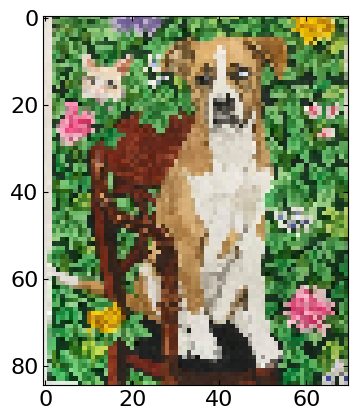

In [3]:
# Plots dog image
plt.imshow(image)


## Generating some data based on the image

### Define a non-linear function


![](https://github.com/jagar2/m3_learning/blob/main/m3_learning/Tutorials/Unsupervised_Learning_with_AEs/figs/generated.png?raw=true)


In [4]:
def non_linear_fn(t, x, y, z):
    tanh = nn.Tanh()
    selu = nn.SELU()
    sigmoid = nn.Sigmoid()

    # returns a function from variables
    return (
        tanh(torch.tensor(20 * (t - 2 * (x - 0.5))))
        + selu(torch.tensor((t - 2 * (y - 0.5))))
        + sigmoid(torch.tensor(-20 * (t - (z - 0.5))))
    )


In [5]:
print_code(generate_data)

24: def generate_data(values, function=default_nl_function, length=25, range_=[-1, 1]):
25:   """function to generate data based on an arbitrary function
26: 
27:   Args:
28:       values (array): Input values to use
29:       function (obj, optional): Function to use for generation. Defaults to default_nl_function.
30:       length (int, optional): length of the vector to generate. Defaults to 25.
31:       range_ (list, optional): range of spectra where you generate data. Defaults to [-1, 1].
32: 
33:   Returns:
34:       array: computed spectra
35:   """
36:   # build x vector
37:   x = np.linspace(range_[0], range_[1], length)
38: 
39:   data = np.zeros((values.shape[0], length))
40: 
41:   for i in range(values.shape[0]):
42:       data[i, :] = function(x, values[i, 0], values[i, 1], values[i, 2])
43: 
44:   return data
45: 


In [6]:
# generates a hyperspectral image
dog_data = generate_data(image.reshape(-1, 3),
                         length=10, function=non_linear_fn)


In [7]:
# Conducts a test train split.
# because we are training an autoencoder x and y are the same
X_train, X_test, _, _ = train_test_split(
    dog_data, dog_data, test_size=0.2, random_state=42
)


## Plots the generated data


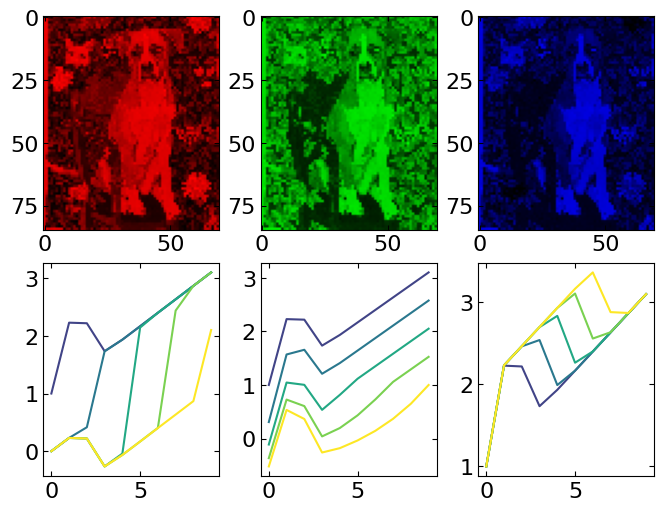

In [8]:
fig, ax = layout_fig(6, mod=3, figsize=(10, 5))

ax = ax.ravel()

cmap = plt.cm.viridis

for i, ax in enumerate(ax):
    # for the first three plots we plot the image
    if i < 3:
        img = np.zeros(image.shape)
        img[:, :, i] = image[:, :, i]
        ax.imshow(img)
    else:
        # for the last three plots we plot the hyperspectral image
        values = np.zeros((5, 3))
        
        # generates 5 linearly spaced values between 0 and 1
        values[:, i - 3] = np.linspace(0, 1, 5)
        
        # generates the spectra 
        y_data = generate_data(values, length=10)
        
        for j in range(y_data.shape[0]):
            
            # computes the colormap for each spectra based on the value
            color = cmap((j + 1) / y_data.shape[0])
            
            # plots the data
            ax.plot(y_data[j], c=color)


## Building a Simple Autoencoder


### Defines the encoder and the decoder


In [9]:
# sets the number of latent dimensions for the autoencoder
latent_dim = 12


class Encoder(nn.Module):
    """Encoder class for the autoencoder"""
    def __init__(self, latent_dim=12):
        self.latent_dim = latent_dim
        super(Encoder, self).__init__()
        self.dense_1 = nn.Linear(10, self.latent_dim)

    def forward(self, x):
        # single dense layer in the model
        x = self.dense_1(x)
        return x


class Decoder(nn.Module):
    """Decoder class for the autoencoder"""
    def __init__(self, latent_dim=12):
        self.latent_dim = latent_dim
        super(Decoder, self).__init__()
        self.dense_1 = nn.Linear(self.latent_dim, 10)

    def forward(self, x):
        # single dense layer in the decoder
        x = self.dense_1(x)
        return x


### Builds the autoencoder


In [10]:
class Autoencoder(nn.Module):
    """
    Autoencoder class that combines the encoder and decoder
    """
    
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, x):
        # encode
        embedding = self.encoder(x)
        # decode
        predicted = self.decoder(embedding)

        return predicted


### Instantiates the model


In [11]:
import cpuinfo

cpudata = cpuinfo.get_cpu_info()["brand_raw"]
cpuname = cpudata.split(" ")[1]

# choose a device based on your system 
if cpuname == "M1":
    device = "mps"
elif torch.cuda.device_count():
    device = "cuda"
else:
    device = "cpu"

print(f"You are running on a {device}")

# builds the encode, decoder, and autoencoder
encoder = Encoder().to(device)
decoder = Decoder().to(device)
model = Autoencoder(encoder, decoder).to(device)

# optimizer
optimizer = optim.Adam(model.parameters(), lr=3e-4)


You are running on a cuda


In [12]:
# prints the model structure

try:
    summary(model, ((X_train.shape[1:])))
except:
    model_cpu = copy.deepcopy(model).to("cpu")
    summary(model_cpu, ((X_train.shape[1:])))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 12]             132
           Encoder-2                   [-1, 12]               0
            Linear-3                   [-1, 10]             130
           Decoder-4                   [-1, 10]               0
Total params: 262
Trainable params: 262
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


- Encoder with 12 latent dimensions
- Decoder with with size 10 --> same as orignal spectral length
- Autoencoder considers time by saying each timestep is its own fully-uncorrelated sample


### Builds the dataloader


In [13]:

# builds a dataloader
train_iterator = torch.utils.data.DataLoader(
    X_train, batch_size=256, shuffle=True)


### Trains the model


In [14]:
print_code(Train)

201: def Train(
202:     model,
203:     encoder,
204:     decoder,
205:     train_iterator,
206:     optimizer,
207:     epochs,
208:     coef=0,
209:     coef_1=0,
210:     ln_parm=1,
211:     beta=None,
212:     mse=True,
213:     device="cuda",
214:     save_weight = False,
215: ):
216:     """Function that trains the model
217: 
218:     Args:
219:         model (Pytorch model): autoencoder model
220:         encoder (PyTorch model): encoder of the mode
221:         decoder (PyTorch model): decoder of the model
222:         train_iterator (iter): iterator used from straining
223:         optimizer (obj): optimization methods used
224:         epochs (int): number of epochs
225:         coef (int, optional): used to set the lambda value of the regularization. Defaults to 0.
226:         coef1 (int, optional): not implemented. Defaults to 0.
227:         ln_parm (int, optional): norm value. Defaults to 1.
228:         beta (float, optional): beta for variational autoencoder. Default

In [ ]:
# fixes the seed
random_seed(seed=42)

# trains the model
Train(model, encoder, decoder, train_iterator, optimizer, 500, device=device)


100%|██████████| 19/19 [00:00<00:00, 316.11it/s]


Epoch 0, Train Loss: 2.0557
.............................


100%|██████████| 19/19 [00:00<00:00, 353.56it/s]


Epoch 1, Train Loss: 1.8709
.............................


100%|██████████| 19/19 [00:00<00:00, 321.69it/s]


Epoch 2, Train Loss: 1.7014
.............................


100%|██████████| 19/19 [00:00<00:00, 327.64it/s]


Epoch 3, Train Loss: 1.5465
.............................


100%|██████████| 19/19 [00:00<00:00, 259.84it/s]


Epoch 4, Train Loss: 1.3983
.............................


100%|██████████| 19/19 [00:00<00:00, 381.99it/s]


Epoch 5, Train Loss: 1.2586
.............................


100%|██████████| 19/19 [00:00<00:00, 311.20it/s]


Epoch 6, Train Loss: 1.1299
.............................


100%|██████████| 19/19 [00:00<00:00, 364.45it/s]


Epoch 7, Train Loss: 1.0058
.............................


100%|██████████| 19/19 [00:00<00:00, 387.41it/s]


Epoch 8, Train Loss: 0.8919
.............................


100%|██████████| 19/19 [00:00<00:00, 368.66it/s]


Epoch 9, Train Loss: 0.7870
.............................


100%|██████████| 19/19 [00:00<00:00, 367.08it/s]


Epoch 10, Train Loss: 0.6910
.............................


100%|██████████| 19/19 [00:00<00:00, 413.06it/s]


Epoch 11, Train Loss: 0.6044
.............................


100%|██████████| 19/19 [00:00<00:00, 402.86it/s]


Epoch 12, Train Loss: 0.5278
.............................


100%|██████████| 19/19 [00:00<00:00, 434.03it/s]


Epoch 13, Train Loss: 0.4611
.............................


100%|██████████| 19/19 [00:00<00:00, 378.78it/s]


Epoch 14, Train Loss: 0.4038
.............................


100%|██████████| 19/19 [00:00<00:00, 396.31it/s]


Epoch 15, Train Loss: 0.3553
.............................


100%|██████████| 19/19 [00:00<00:00, 439.54it/s]


Epoch 16, Train Loss: 0.3155
.............................


100%|██████████| 19/19 [00:00<00:00, 444.58it/s]


Epoch 17, Train Loss: 0.2828
.............................


100%|██████████| 19/19 [00:00<00:00, 420.64it/s]


Epoch 18, Train Loss: 0.2565
.............................


100%|██████████| 19/19 [00:00<00:00, 443.30it/s]


Epoch 19, Train Loss: 0.2355
.............................


100%|██████████| 19/19 [00:00<00:00, 436.37it/s]


Epoch 20, Train Loss: 0.2191
.............................


100%|██████████| 19/19 [00:00<00:00, 399.75it/s]


Epoch 21, Train Loss: 0.2055
.............................


100%|██████████| 19/19 [00:00<00:00, 407.70it/s]


Epoch 22, Train Loss: 0.1945
.............................


100%|██████████| 19/19 [00:00<00:00, 408.49it/s]


Epoch 23, Train Loss: 0.1857
.............................


100%|██████████| 19/19 [00:00<00:00, 371.34it/s]


Epoch 24, Train Loss: 0.1780
.............................


100%|██████████| 19/19 [00:00<00:00, 371.77it/s]


Epoch 25, Train Loss: 0.1714
.............................


100%|██████████| 19/19 [00:00<00:00, 332.35it/s]


Epoch 26, Train Loss: 0.1664
.............................


100%|██████████| 19/19 [00:00<00:00, 321.14it/s]


Epoch 27, Train Loss: 0.1614
.............................


100%|██████████| 19/19 [00:00<00:00, 369.03it/s]


Epoch 28, Train Loss: 0.1573
.............................


100%|██████████| 19/19 [00:00<00:00, 323.73it/s]


Epoch 29, Train Loss: 0.1535
.............................


100%|██████████| 19/19 [00:00<00:00, 331.62it/s]


Epoch 30, Train Loss: 0.1501
.............................


100%|██████████| 19/19 [00:00<00:00, 334.90it/s]


Epoch 31, Train Loss: 0.1467
.............................


100%|██████████| 19/19 [00:00<00:00, 309.70it/s]


Epoch 32, Train Loss: 0.1440
.............................


100%|██████████| 19/19 [00:00<00:00, 361.03it/s]


Epoch 33, Train Loss: 0.1412
.............................


100%|██████████| 19/19 [00:00<00:00, 405.09it/s]


Epoch 34, Train Loss: 0.1385
.............................


100%|██████████| 19/19 [00:00<00:00, 377.94it/s]


Epoch 35, Train Loss: 0.1361
.............................


100%|██████████| 19/19 [00:00<00:00, 422.25it/s]


Epoch 36, Train Loss: 0.1338
.............................


100%|██████████| 19/19 [00:00<00:00, 419.00it/s]


Epoch 37, Train Loss: 0.1314
.............................


100%|██████████| 19/19 [00:00<00:00, 417.29it/s]


Epoch 38, Train Loss: 0.1291
.............................


100%|██████████| 19/19 [00:00<00:00, 383.04it/s]


Epoch 39, Train Loss: 0.1268
.............................


100%|██████████| 19/19 [00:00<00:00, 395.83it/s]


Epoch 40, Train Loss: 0.1245
.............................


100%|██████████| 19/19 [00:00<00:00, 400.00it/s]


Epoch 41, Train Loss: 0.1225
.............................


100%|██████████| 19/19 [00:00<00:00, 389.65it/s]


Epoch 42, Train Loss: 0.1204
.............................


100%|██████████| 19/19 [00:00<00:00, 327.32it/s]


Epoch 43, Train Loss: 0.1181
.............................


100%|██████████| 19/19 [00:00<00:00, 284.89it/s]


Epoch 44, Train Loss: 0.1161
.............................


100%|██████████| 19/19 [00:00<00:00, 403.26it/s]


Epoch 45, Train Loss: 0.1140
.............................


100%|██████████| 19/19 [00:00<00:00, 483.74it/s]


Epoch 46, Train Loss: 0.1121
.............................


100%|██████████| 19/19 [00:00<00:00, 479.57it/s]


Epoch 47, Train Loss: 0.1099
.............................


100%|██████████| 19/19 [00:00<00:00, 441.09it/s]


Epoch 48, Train Loss: 0.1081
.............................


100%|██████████| 19/19 [00:00<00:00, 526.47it/s]


Epoch 49, Train Loss: 0.1062
.............................


100%|██████████| 19/19 [00:00<00:00, 298.92it/s]


Epoch 50, Train Loss: 0.1044
.............................


100%|██████████| 19/19 [00:00<00:00, 375.52it/s]


Epoch 51, Train Loss: 0.1024
.............................


100%|██████████| 19/19 [00:00<00:00, 318.98it/s]


Epoch 52, Train Loss: 0.1005
.............................


100%|██████████| 19/19 [00:00<00:00, 392.10it/s]


Epoch 53, Train Loss: 0.0986
.............................


100%|██████████| 19/19 [00:00<00:00, 334.62it/s]


Epoch 54, Train Loss: 0.0969
.............................


100%|██████████| 19/19 [00:00<00:00, 258.70it/s]


Epoch 55, Train Loss: 0.0949
.............................


100%|██████████| 19/19 [00:00<00:00, 324.98it/s]


Epoch 56, Train Loss: 0.0933
.............................


100%|██████████| 19/19 [00:00<00:00, 331.78it/s]


Epoch 57, Train Loss: 0.0914
.............................


100%|██████████| 19/19 [00:00<00:00, 337.30it/s]


Epoch 58, Train Loss: 0.0897
.............................


100%|██████████| 19/19 [00:00<00:00, 332.51it/s]


Epoch 59, Train Loss: 0.0880
.............................


100%|██████████| 19/19 [00:00<00:00, 396.08it/s]


Epoch 60, Train Loss: 0.0863
.............................


100%|██████████| 19/19 [00:00<00:00, 344.19it/s]


Epoch 61, Train Loss: 0.0847
.............................


100%|██████████| 19/19 [00:00<00:00, 322.67it/s]


Epoch 62, Train Loss: 0.0831
.............................


100%|██████████| 19/19 [00:00<00:00, 383.76it/s]


Epoch 63, Train Loss: 0.0816
.............................


100%|██████████| 19/19 [00:00<00:00, 313.99it/s]


Epoch 64, Train Loss: 0.0801
.............................


100%|██████████| 19/19 [00:00<00:00, 422.16it/s]


Epoch 65, Train Loss: 0.0784
.............................


100%|██████████| 19/19 [00:00<00:00, 319.73it/s]


Epoch 66, Train Loss: 0.0771
.............................


100%|██████████| 19/19 [00:00<00:00, 368.81it/s]


Epoch 67, Train Loss: 0.0755
.............................


100%|██████████| 19/19 [00:00<00:00, 364.83it/s]


Epoch 68, Train Loss: 0.0743
.............................


100%|██████████| 19/19 [00:00<00:00, 235.95it/s]


Epoch 69, Train Loss: 0.0727
.............................


100%|██████████| 19/19 [00:00<00:00, 383.66it/s]


Epoch 70, Train Loss: 0.0713
.............................


100%|██████████| 19/19 [00:00<00:00, 383.47it/s]


Epoch 71, Train Loss: 0.0701
.............................


100%|██████████| 19/19 [00:00<00:00, 413.62it/s]


Epoch 72, Train Loss: 0.0689
.............................


100%|██████████| 19/19 [00:00<00:00, 422.24it/s]


Epoch 73, Train Loss: 0.0676
.............................


100%|██████████| 19/19 [00:00<00:00, 357.51it/s]


Epoch 74, Train Loss: 0.0664
.............................


100%|██████████| 19/19 [00:00<00:00, 419.54it/s]


Epoch 75, Train Loss: 0.0651
.............................


100%|██████████| 19/19 [00:00<00:00, 413.77it/s]


Epoch 76, Train Loss: 0.0639
.............................


100%|██████████| 19/19 [00:00<00:00, 333.06it/s]


Epoch 77, Train Loss: 0.0628
.............................


100%|██████████| 19/19 [00:00<00:00, 270.71it/s]


Epoch 78, Train Loss: 0.0618
.............................


100%|██████████| 19/19 [00:00<00:00, 251.43it/s]


Epoch 79, Train Loss: 0.0607
.............................


100%|██████████| 19/19 [00:00<00:00, 250.20it/s]


Epoch 80, Train Loss: 0.0597
.............................


100%|██████████| 19/19 [00:00<00:00, 277.39it/s]


Epoch 81, Train Loss: 0.0586
.............................


100%|██████████| 19/19 [00:00<00:00, 320.92it/s]


Epoch 82, Train Loss: 0.0577
.............................


100%|██████████| 19/19 [00:00<00:00, 267.58it/s]


Epoch 83, Train Loss: 0.0568
.............................


100%|██████████| 19/19 [00:00<00:00, 276.92it/s]


Epoch 84, Train Loss: 0.0558
.............................


100%|██████████| 19/19 [00:00<00:00, 368.26it/s]


Epoch 85, Train Loss: 0.0549
.............................


100%|██████████| 19/19 [00:00<00:00, 344.05it/s]


Epoch 86, Train Loss: 0.0539
.............................


100%|██████████| 19/19 [00:00<00:00, 387.54it/s]


Epoch 87, Train Loss: 0.0531
.............................


100%|██████████| 19/19 [00:00<00:00, 404.51it/s]


Epoch 88, Train Loss: 0.0524
.............................


100%|██████████| 19/19 [00:00<00:00, 397.38it/s]


Epoch 89, Train Loss: 0.0515
.............................


100%|██████████| 19/19 [00:00<00:00, 491.82it/s]


Epoch 90, Train Loss: 0.0507
.............................


100%|██████████| 19/19 [00:00<00:00, 510.14it/s]


Epoch 91, Train Loss: 0.0500
.............................


100%|██████████| 19/19 [00:00<00:00, 622.70it/s]


Epoch 92, Train Loss: 0.0492
.............................


100%|██████████| 19/19 [00:00<00:00, 510.65it/s]


Epoch 93, Train Loss: 0.0484
.............................


100%|██████████| 19/19 [00:00<00:00, 524.98it/s]


Epoch 94, Train Loss: 0.0477
.............................


100%|██████████| 19/19 [00:00<00:00, 639.76it/s]


Epoch 95, Train Loss: 0.0470
.............................


100%|██████████| 19/19 [00:00<00:00, 509.76it/s]


Epoch 96, Train Loss: 0.0463
.............................


100%|██████████| 19/19 [00:00<00:00, 534.02it/s]


Epoch 97, Train Loss: 0.0457
.............................


100%|██████████| 19/19 [00:00<00:00, 549.52it/s]


Epoch 98, Train Loss: 0.0451
.............................


100%|██████████| 19/19 [00:00<00:00, 623.16it/s]


Epoch 99, Train Loss: 0.0445
.............................


100%|██████████| 19/19 [00:00<00:00, 603.03it/s]


Epoch 100, Train Loss: 0.0437
.............................


100%|██████████| 19/19 [00:00<00:00, 567.00it/s]


Epoch 101, Train Loss: 0.0431
.............................


100%|██████████| 19/19 [00:00<00:00, 558.81it/s]


Epoch 102, Train Loss: 0.0425
.............................


100%|██████████| 19/19 [00:00<00:00, 576.36it/s]


Epoch 103, Train Loss: 0.0420
.............................


100%|██████████| 19/19 [00:00<00:00, 567.36it/s]


Epoch 104, Train Loss: 0.0415
.............................


100%|██████████| 19/19 [00:00<00:00, 375.20it/s]


Epoch 105, Train Loss: 0.0409
.............................


100%|██████████| 19/19 [00:00<00:00, 268.39it/s]


Epoch 106, Train Loss: 0.0403
.............................


100%|██████████| 19/19 [00:00<00:00, 336.18it/s]


Epoch 107, Train Loss: 0.0397
.............................


100%|██████████| 19/19 [00:00<00:00, 377.48it/s]


Epoch 108, Train Loss: 0.0392
.............................


100%|██████████| 19/19 [00:00<00:00, 371.46it/s]


Epoch 109, Train Loss: 0.0388
.............................


100%|██████████| 19/19 [00:00<00:00, 353.62it/s]


Epoch 110, Train Loss: 0.0382
.............................


100%|██████████| 19/19 [00:00<00:00, 357.69it/s]


Epoch 111, Train Loss: 0.0378
.............................


100%|██████████| 19/19 [00:00<00:00, 314.74it/s]


Epoch 112, Train Loss: 0.0373
.............................


100%|██████████| 19/19 [00:00<00:00, 379.64it/s]


Epoch 113, Train Loss: 0.0369
.............................


100%|██████████| 19/19 [00:00<00:00, 379.93it/s]


Epoch 114, Train Loss: 0.0365
.............................


100%|██████████| 19/19 [00:00<00:00, 337.03it/s]


Epoch 115, Train Loss: 0.0359
.............................


100%|██████████| 19/19 [00:00<00:00, 355.02it/s]


Epoch 116, Train Loss: 0.0354
.............................


100%|██████████| 19/19 [00:00<00:00, 364.15it/s]


Epoch 117, Train Loss: 0.0350
.............................


100%|██████████| 19/19 [00:00<00:00, 373.76it/s]


Epoch 118, Train Loss: 0.0346
.............................


100%|██████████| 19/19 [00:00<00:00, 365.47it/s]


Epoch 119, Train Loss: 0.0341
.............................


100%|██████████| 19/19 [00:00<00:00, 383.22it/s]


Epoch 120, Train Loss: 0.0338
.............................


100%|██████████| 19/19 [00:00<00:00, 275.07it/s]


Epoch 121, Train Loss: 0.0333
.............................


100%|██████████| 19/19 [00:00<00:00, 283.69it/s]


Epoch 122, Train Loss: 0.0330
.............................


100%|██████████| 19/19 [00:00<00:00, 379.97it/s]


Epoch 123, Train Loss: 0.0326
.............................


100%|██████████| 19/19 [00:00<00:00, 378.73it/s]


Epoch 124, Train Loss: 0.0321
.............................


100%|██████████| 19/19 [00:00<00:00, 348.57it/s]


Epoch 125, Train Loss: 0.0318
.............................


100%|██████████| 19/19 [00:00<00:00, 376.01it/s]


Epoch 126, Train Loss: 0.0314
.............................


100%|██████████| 19/19 [00:00<00:00, 355.63it/s]


Epoch 127, Train Loss: 0.0311
.............................


100%|██████████| 19/19 [00:00<00:00, 399.90it/s]


Epoch 128, Train Loss: 0.0307
.............................


100%|██████████| 19/19 [00:00<00:00, 409.95it/s]


Epoch 129, Train Loss: 0.0304
.............................


100%|██████████| 19/19 [00:00<00:00, 408.05it/s]


Epoch 130, Train Loss: 0.0300
.............................


100%|██████████| 19/19 [00:00<00:00, 403.94it/s]


Epoch 131, Train Loss: 0.0297
.............................


100%|██████████| 19/19 [00:00<00:00, 445.06it/s]


Epoch 132, Train Loss: 0.0294
.............................


100%|██████████| 19/19 [00:00<00:00, 427.88it/s]


Epoch 133, Train Loss: 0.0290
.............................


100%|██████████| 19/19 [00:00<00:00, 431.22it/s]


Epoch 134, Train Loss: 0.0287
.............................


100%|██████████| 19/19 [00:00<00:00, 429.33it/s]


Epoch 135, Train Loss: 0.0283
.............................


100%|██████████| 19/19 [00:00<00:00, 470.41it/s]


Epoch 136, Train Loss: 0.0280
.............................


100%|██████████| 19/19 [00:00<00:00, 423.40it/s]


Epoch 137, Train Loss: 0.0278
.............................


100%|██████████| 19/19 [00:00<00:00, 394.58it/s]


Epoch 138, Train Loss: 0.0274
.............................


100%|██████████| 19/19 [00:00<00:00, 252.23it/s]


Epoch 139, Train Loss: 0.0271
.............................


100%|██████████| 19/19 [00:00<00:00, 378.37it/s]


Epoch 140, Train Loss: 0.0268
.............................


100%|██████████| 19/19 [00:00<00:00, 383.00it/s]


Epoch 141, Train Loss: 0.0266
.............................


100%|██████████| 19/19 [00:00<00:00, 361.74it/s]


Epoch 142, Train Loss: 0.0262
.............................


100%|██████████| 19/19 [00:00<00:00, 351.83it/s]


Epoch 143, Train Loss: 0.0259
.............................


100%|██████████| 19/19 [00:00<00:00, 405.82it/s]


Epoch 144, Train Loss: 0.0257
.............................


100%|██████████| 19/19 [00:00<00:00, 385.22it/s]


Epoch 145, Train Loss: 0.0254
.............................


100%|██████████| 19/19 [00:00<00:00, 373.53it/s]


Epoch 146, Train Loss: 0.0252
.............................


100%|██████████| 19/19 [00:00<00:00, 398.01it/s]


Epoch 147, Train Loss: 0.0250
.............................


100%|██████████| 19/19 [00:00<00:00, 363.99it/s]


Epoch 148, Train Loss: 0.0246
.............................


100%|██████████| 19/19 [00:00<00:00, 382.98it/s]


Epoch 149, Train Loss: 0.0245
.............................


100%|██████████| 19/19 [00:00<00:00, 431.35it/s]


Epoch 150, Train Loss: 0.0242
.............................


100%|██████████| 19/19 [00:00<00:00, 465.48it/s]


Epoch 151, Train Loss: 0.0239
.............................


100%|██████████| 19/19 [00:00<00:00, 432.01it/s]


Epoch 152, Train Loss: 0.0237
.............................


100%|██████████| 19/19 [00:00<00:00, 383.81it/s]


Epoch 153, Train Loss: 0.0234
.............................


100%|██████████| 19/19 [00:00<00:00, 370.33it/s]


Epoch 154, Train Loss: 0.0232
.............................


100%|██████████| 19/19 [00:00<00:00, 360.88it/s]


Epoch 155, Train Loss: 0.0230
.............................


100%|██████████| 19/19 [00:00<00:00, 306.04it/s]


Epoch 156, Train Loss: 0.0227
.............................


100%|██████████| 19/19 [00:00<00:00, 389.61it/s]


Epoch 157, Train Loss: 0.0225
.............................


100%|██████████| 19/19 [00:00<00:00, 448.04it/s]


Epoch 158, Train Loss: 0.0224
.............................


100%|██████████| 19/19 [00:00<00:00, 400.89it/s]


Epoch 159, Train Loss: 0.0220
.............................


100%|██████████| 19/19 [00:00<00:00, 423.18it/s]


Epoch 160, Train Loss: 0.0218
.............................


100%|██████████| 19/19 [00:00<00:00, 413.09it/s]


Epoch 161, Train Loss: 0.0217
.............................


100%|██████████| 19/19 [00:00<00:00, 449.18it/s]


Epoch 162, Train Loss: 0.0215
.............................


100%|██████████| 19/19 [00:00<00:00, 429.15it/s]


Epoch 163, Train Loss: 0.0212
.............................


100%|██████████| 19/19 [00:00<00:00, 405.68it/s]


Epoch 164, Train Loss: 0.0211
.............................


100%|██████████| 19/19 [00:00<00:00, 388.84it/s]


Epoch 165, Train Loss: 0.0208
.............................


100%|██████████| 19/19 [00:00<00:00, 405.38it/s]


Epoch 166, Train Loss: 0.0207
.............................


100%|██████████| 19/19 [00:00<00:00, 428.25it/s]


Epoch 167, Train Loss: 0.0204
.............................


100%|██████████| 19/19 [00:00<00:00, 419.89it/s]


Epoch 168, Train Loss: 0.0202
.............................


100%|██████████| 19/19 [00:00<00:00, 412.04it/s]


Epoch 169, Train Loss: 0.0201
.............................


100%|██████████| 19/19 [00:00<00:00, 366.09it/s]


Epoch 170, Train Loss: 0.0199
.............................


100%|██████████| 19/19 [00:00<00:00, 356.92it/s]


Epoch 171, Train Loss: 0.0197
.............................


100%|██████████| 19/19 [00:00<00:00, 291.95it/s]


Epoch 172, Train Loss: 0.0195
.............................


100%|██████████| 19/19 [00:00<00:00, 298.49it/s]


Epoch 173, Train Loss: 0.0193
.............................


100%|██████████| 19/19 [00:00<00:00, 273.31it/s]


Epoch 174, Train Loss: 0.0192
.............................


100%|██████████| 19/19 [00:00<00:00, 338.17it/s]


Epoch 175, Train Loss: 0.0190
.............................


100%|██████████| 19/19 [00:00<00:00, 408.17it/s]


Epoch 176, Train Loss: 0.0187
.............................


100%|██████████| 19/19 [00:00<00:00, 334.31it/s]


Epoch 177, Train Loss: 0.0187
.............................


100%|██████████| 19/19 [00:00<00:00, 331.17it/s]


Epoch 178, Train Loss: 0.0185
.............................


100%|██████████| 19/19 [00:00<00:00, 390.10it/s]


Epoch 179, Train Loss: 0.0182
.............................


100%|██████████| 19/19 [00:00<00:00, 364.99it/s]


Epoch 180, Train Loss: 0.0181
.............................


100%|██████████| 19/19 [00:00<00:00, 313.29it/s]


Epoch 181, Train Loss: 0.0179
.............................


100%|██████████| 19/19 [00:00<00:00, 490.73it/s]


Epoch 182, Train Loss: 0.0178
.............................


100%|██████████| 19/19 [00:00<00:00, 243.11it/s]


Epoch 183, Train Loss: 0.0176
.............................


100%|██████████| 19/19 [00:00<00:00, 380.85it/s]


Epoch 184, Train Loss: 0.0174
.............................


100%|██████████| 19/19 [00:00<00:00, 470.21it/s]


Epoch 185, Train Loss: 0.0173
.............................


100%|██████████| 19/19 [00:00<00:00, 400.75it/s]


Epoch 186, Train Loss: 0.0171
.............................


100%|██████████| 19/19 [00:00<00:00, 372.46it/s]


Epoch 187, Train Loss: 0.0169
.............................


100%|██████████| 19/19 [00:00<00:00, 489.05it/s]


Epoch 188, Train Loss: 0.0168
.............................


100%|██████████| 19/19 [00:00<00:00, 394.60it/s]


Epoch 189, Train Loss: 0.0166
.............................


100%|██████████| 19/19 [00:00<00:00, 355.53it/s]


Epoch 190, Train Loss: 0.0165
.............................


100%|██████████| 19/19 [00:00<00:00, 341.85it/s]


Epoch 191, Train Loss: 0.0164
.............................


100%|██████████| 19/19 [00:00<00:00, 446.01it/s]


Epoch 192, Train Loss: 0.0162
.............................


100%|██████████| 19/19 [00:00<00:00, 411.01it/s]


Epoch 193, Train Loss: 0.0161
.............................


100%|██████████| 19/19 [00:00<00:00, 313.18it/s]


Epoch 194, Train Loss: 0.0159
.............................


100%|██████████| 19/19 [00:00<00:00, 310.35it/s]


Epoch 195, Train Loss: 0.0158
.............................


100%|██████████| 19/19 [00:00<00:00, 270.66it/s]


Epoch 196, Train Loss: 0.0156
.............................


100%|██████████| 19/19 [00:00<00:00, 369.18it/s]


Epoch 197, Train Loss: 0.0155
.............................


100%|██████████| 19/19 [00:00<00:00, 499.52it/s]


Epoch 198, Train Loss: 0.0153
.............................


100%|██████████| 19/19 [00:00<00:00, 393.40it/s]


Epoch 199, Train Loss: 0.0152
.............................


100%|██████████| 19/19 [00:00<00:00, 363.10it/s]


Epoch 200, Train Loss: 0.0150
.............................


100%|██████████| 19/19 [00:00<00:00, 324.34it/s]


Epoch 201, Train Loss: 0.0148
.............................


100%|██████████| 19/19 [00:00<00:00, 318.35it/s]


Epoch 202, Train Loss: 0.0147
.............................


100%|██████████| 19/19 [00:00<00:00, 542.42it/s]


Epoch 203, Train Loss: 0.0145
.............................


100%|██████████| 19/19 [00:00<00:00, 378.34it/s]


Epoch 204, Train Loss: 0.0144
.............................


100%|██████████| 19/19 [00:00<00:00, 306.41it/s]


Epoch 205, Train Loss: 0.0143
.............................


100%|██████████| 19/19 [00:00<00:00, 317.88it/s]


Epoch 206, Train Loss: 0.0141
.............................


100%|██████████| 19/19 [00:00<00:00, 364.13it/s]


Epoch 207, Train Loss: 0.0139
.............................


100%|██████████| 19/19 [00:00<00:00, 327.71it/s]


Epoch 208, Train Loss: 0.0138
.............................


100%|██████████| 19/19 [00:00<00:00, 347.41it/s]


Epoch 209, Train Loss: 0.0136
.............................


100%|██████████| 19/19 [00:00<00:00, 357.22it/s]


Epoch 210, Train Loss: 0.0135
.............................


100%|██████████| 19/19 [00:00<00:00, 296.86it/s]


Epoch 211, Train Loss: 0.0134
.............................


100%|██████████| 19/19 [00:00<00:00, 338.88it/s]


Epoch 212, Train Loss: 0.0133
.............................


100%|██████████| 19/19 [00:00<00:00, 336.96it/s]


Epoch 213, Train Loss: 0.0131
.............................


100%|██████████| 19/19 [00:00<00:00, 270.49it/s]


Epoch 214, Train Loss: 0.0129
.............................


100%|██████████| 19/19 [00:00<00:00, 402.59it/s]


Epoch 215, Train Loss: 0.0128
.............................


100%|██████████| 19/19 [00:00<00:00, 425.50it/s]


Epoch 216, Train Loss: 0.0127
.............................


100%|██████████| 19/19 [00:00<00:00, 354.20it/s]


Epoch 217, Train Loss: 0.0125
.............................


100%|██████████| 19/19 [00:00<00:00, 319.38it/s]


Epoch 218, Train Loss: 0.0123
.............................


100%|██████████| 19/19 [00:00<00:00, 276.19it/s]


Epoch 219, Train Loss: 0.0122
.............................


100%|██████████| 19/19 [00:00<00:00, 430.60it/s]


Epoch 220, Train Loss: 0.0120
.............................


100%|██████████| 19/19 [00:00<00:00, 434.04it/s]


Epoch 221, Train Loss: 0.0119
.............................


100%|██████████| 19/19 [00:00<00:00, 455.10it/s]


Epoch 222, Train Loss: 0.0118
.............................


100%|██████████| 19/19 [00:00<00:00, 367.75it/s]


Epoch 223, Train Loss: 0.0116
.............................


100%|██████████| 19/19 [00:00<00:00, 441.89it/s]


Epoch 224, Train Loss: 0.0115
.............................


100%|██████████| 19/19 [00:00<00:00, 339.04it/s]


Epoch 225, Train Loss: 0.0114
.............................


100%|██████████| 19/19 [00:00<00:00, 392.45it/s]


Epoch 226, Train Loss: 0.0112
.............................


100%|██████████| 19/19 [00:00<00:00, 417.86it/s]


Epoch 227, Train Loss: 0.0110
.............................


100%|██████████| 19/19 [00:00<00:00, 431.50it/s]


Epoch 228, Train Loss: 0.0109
.............................


100%|██████████| 19/19 [00:00<00:00, 340.73it/s]


Epoch 229, Train Loss: 0.0108
.............................


100%|██████████| 19/19 [00:00<00:00, 294.58it/s]


Epoch 230, Train Loss: 0.0106
.............................


100%|██████████| 19/19 [00:00<00:00, 286.31it/s]


Epoch 231, Train Loss: 0.0105
.............................


100%|██████████| 19/19 [00:00<00:00, 319.19it/s]


Epoch 232, Train Loss: 0.0104
.............................


100%|██████████| 19/19 [00:00<00:00, 334.53it/s]


Epoch 233, Train Loss: 0.0102
.............................


100%|██████████| 19/19 [00:00<00:00, 276.28it/s]


Epoch 234, Train Loss: 0.0101
.............................


100%|██████████| 19/19 [00:00<00:00, 348.14it/s]


Epoch 235, Train Loss: 0.0099
.............................


100%|██████████| 19/19 [00:00<00:00, 336.40it/s]


Epoch 236, Train Loss: 0.0098
.............................


100%|██████████| 19/19 [00:00<00:00, 256.74it/s]


Epoch 237, Train Loss: 0.0096
.............................


100%|██████████| 19/19 [00:00<00:00, 342.30it/s]


Epoch 238, Train Loss: 0.0096
.............................


100%|██████████| 19/19 [00:00<00:00, 447.07it/s]


Epoch 239, Train Loss: 0.0094
.............................


100%|██████████| 19/19 [00:00<00:00, 460.65it/s]


Epoch 240, Train Loss: 0.0093
.............................


100%|██████████| 19/19 [00:00<00:00, 474.78it/s]


Epoch 241, Train Loss: 0.0092
.............................


100%|██████████| 19/19 [00:00<00:00, 315.81it/s]


Epoch 242, Train Loss: 0.0090
.............................


100%|██████████| 19/19 [00:00<00:00, 452.35it/s]


Epoch 243, Train Loss: 0.0088
.............................


100%|██████████| 19/19 [00:00<00:00, 330.33it/s]


Epoch 244, Train Loss: 0.0087
.............................


100%|██████████| 19/19 [00:00<00:00, 431.57it/s]


Epoch 245, Train Loss: 0.0086
.............................


100%|██████████| 19/19 [00:00<00:00, 287.89it/s]


Epoch 246, Train Loss: 0.0084
.............................


100%|██████████| 19/19 [00:00<00:00, 349.82it/s]


Epoch 247, Train Loss: 0.0083
.............................


100%|██████████| 19/19 [00:00<00:00, 376.65it/s]


Epoch 248, Train Loss: 0.0082
.............................


100%|██████████| 19/19 [00:00<00:00, 432.79it/s]


Epoch 249, Train Loss: 0.0080
.............................


100%|██████████| 19/19 [00:00<00:00, 351.87it/s]


Epoch 250, Train Loss: 0.0079
.............................


100%|██████████| 19/19 [00:00<00:00, 329.03it/s]


Epoch 251, Train Loss: 0.0078
.............................


100%|██████████| 19/19 [00:00<00:00, 463.36it/s]


Epoch 252, Train Loss: 0.0077
.............................


100%|██████████| 19/19 [00:00<00:00, 423.33it/s]


Epoch 253, Train Loss: 0.0075
.............................


100%|██████████| 19/19 [00:00<00:00, 421.40it/s]


Epoch 254, Train Loss: 0.0074
.............................


100%|██████████| 19/19 [00:00<00:00, 480.18it/s]


Epoch 255, Train Loss: 0.0073
.............................


100%|██████████| 19/19 [00:00<00:00, 279.63it/s]


Epoch 256, Train Loss: 0.0071
.............................


100%|██████████| 19/19 [00:00<00:00, 357.11it/s]


Epoch 257, Train Loss: 0.0070
.............................


100%|██████████| 19/19 [00:00<00:00, 333.45it/s]


Epoch 258, Train Loss: 0.0069
.............................


100%|██████████| 19/19 [00:00<00:00, 339.10it/s]


Epoch 259, Train Loss: 0.0067
.............................


100%|██████████| 19/19 [00:00<00:00, 366.56it/s]


Epoch 260, Train Loss: 0.0066
.............................


100%|██████████| 19/19 [00:00<00:00, 372.15it/s]


Epoch 261, Train Loss: 0.0065
.............................


100%|██████████| 19/19 [00:00<00:00, 445.71it/s]


Epoch 262, Train Loss: 0.0064
.............................


100%|██████████| 19/19 [00:00<00:00, 355.91it/s]


Epoch 263, Train Loss: 0.0062
.............................


100%|██████████| 19/19 [00:00<00:00, 492.81it/s]


Epoch 264, Train Loss: 0.0061
.............................


100%|██████████| 19/19 [00:00<00:00, 509.32it/s]


Epoch 265, Train Loss: 0.0060
.............................


100%|██████████| 19/19 [00:00<00:00, 480.02it/s]


Epoch 266, Train Loss: 0.0059
.............................


100%|██████████| 19/19 [00:00<00:00, 387.72it/s]


Epoch 267, Train Loss: 0.0057
.............................


100%|██████████| 19/19 [00:00<00:00, 383.61it/s]


Epoch 268, Train Loss: 0.0056
.............................


100%|██████████| 19/19 [00:00<00:00, 513.30it/s]


Epoch 269, Train Loss: 0.0055
.............................


100%|██████████| 19/19 [00:00<00:00, 437.98it/s]


Epoch 270, Train Loss: 0.0054
.............................


100%|██████████| 19/19 [00:00<00:00, 431.82it/s]


Epoch 271, Train Loss: 0.0052
.............................


100%|██████████| 19/19 [00:00<00:00, 315.81it/s]


Epoch 272, Train Loss: 0.0052
.............................


100%|██████████| 19/19 [00:00<00:00, 422.19it/s]


Epoch 273, Train Loss: 0.0050
.............................


100%|██████████| 19/19 [00:00<00:00, 399.85it/s]


Epoch 274, Train Loss: 0.0049
.............................


100%|██████████| 19/19 [00:00<00:00, 474.78it/s]


Epoch 275, Train Loss: 0.0048
.............................


100%|██████████| 19/19 [00:00<00:00, 476.32it/s]


Epoch 276, Train Loss: 0.0047
.............................


100%|██████████| 19/19 [00:00<00:00, 451.17it/s]


Epoch 277, Train Loss: 0.0046
.............................


100%|██████████| 19/19 [00:00<00:00, 431.92it/s]


Epoch 278, Train Loss: 0.0045
.............................


100%|██████████| 19/19 [00:00<00:00, 449.78it/s]


Epoch 279, Train Loss: 0.0043
.............................


100%|██████████| 19/19 [00:00<00:00, 526.95it/s]


Epoch 280, Train Loss: 0.0042
.............................


100%|██████████| 19/19 [00:00<00:00, 457.96it/s]


Epoch 281, Train Loss: 0.0041
.............................


100%|██████████| 19/19 [00:00<00:00, 491.05it/s]


Epoch 282, Train Loss: 0.0040
.............................


100%|██████████| 19/19 [00:00<00:00, 524.72it/s]


Epoch 283, Train Loss: 0.0039
.............................


100%|██████████| 19/19 [00:00<00:00, 511.27it/s]


Epoch 284, Train Loss: 0.0038
.............................


100%|██████████| 19/19 [00:00<00:00, 512.86it/s]


Epoch 285, Train Loss: 0.0037
.............................


100%|██████████| 19/19 [00:00<00:00, 372.54it/s]


Epoch 286, Train Loss: 0.0036
.............................


100%|██████████| 19/19 [00:00<00:00, 410.25it/s]


Epoch 287, Train Loss: 0.0035
.............................


100%|██████████| 19/19 [00:00<00:00, 452.19it/s]


Epoch 288, Train Loss: 0.0034
.............................


100%|██████████| 19/19 [00:00<00:00, 486.72it/s]


Epoch 289, Train Loss: 0.0033
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 381.17it/s]


Epoch 290, Train Loss: 0.0032
.............................


100%|██████████| 19/19 [00:00<00:00, 311.10it/s]


Epoch 291, Train Loss: 0.0031
.............................


100%|██████████| 19/19 [00:00<00:00, 404.26it/s]


Epoch 292, Train Loss: 0.0030
.............................


100%|██████████| 19/19 [00:00<00:00, 392.59it/s]


Epoch 293, Train Loss: 0.0029
.............................


100%|██████████| 19/19 [00:00<00:00, 356.57it/s]


Epoch 294, Train Loss: 0.0028
.............................


100%|██████████| 19/19 [00:00<00:00, 359.51it/s]


Epoch 295, Train Loss: 0.0027
.............................


100%|██████████| 19/19 [00:00<00:00, 452.38it/s]


Epoch 296, Train Loss: 0.0026
.............................


100%|██████████| 19/19 [00:00<00:00, 409.38it/s]


Epoch 297, Train Loss: 0.0025
.............................


100%|██████████| 19/19 [00:00<00:00, 475.01it/s]


Epoch 298, Train Loss: 0.0024
.............................


100%|██████████| 19/19 [00:00<00:00, 426.81it/s]


Epoch 299, Train Loss: 0.0023
.............................


100%|██████████| 19/19 [00:00<00:00, 452.51it/s]


Epoch 300, Train Loss: 0.0023
.............................


100%|██████████| 19/19 [00:00<00:00, 474.98it/s]


Epoch 301, Train Loss: 0.0022
.............................


100%|██████████| 19/19 [00:00<00:00, 371.59it/s]


Epoch 302, Train Loss: 0.0021
.............................


100%|██████████| 19/19 [00:00<00:00, 433.03it/s]


Epoch 303, Train Loss: 0.0020
.............................


100%|██████████| 19/19 [00:00<00:00, 416.43it/s]


Epoch 304, Train Loss: 0.0019
.............................


100%|██████████| 19/19 [00:00<00:00, 412.78it/s]


Epoch 305, Train Loss: 0.0019
.............................


100%|██████████| 19/19 [00:00<00:00, 436.06it/s]


Epoch 306, Train Loss: 0.0018
.............................


100%|██████████| 19/19 [00:00<00:00, 315.98it/s]


Epoch 307, Train Loss: 0.0017
.............................


100%|██████████| 19/19 [00:00<00:00, 396.14it/s]


Epoch 308, Train Loss: 0.0016
.............................


100%|██████████| 19/19 [00:00<00:00, 448.04it/s]


Epoch 309, Train Loss: 0.0016
.............................


100%|██████████| 19/19 [00:00<00:00, 408.73it/s]


Epoch 310, Train Loss: 0.0015
.............................


100%|██████████| 19/19 [00:00<00:00, 417.15it/s]


Epoch 311, Train Loss: 0.0014
.............................


100%|██████████| 19/19 [00:00<00:00, 452.14it/s]


Epoch 312, Train Loss: 0.0014
.............................


100%|██████████| 19/19 [00:00<00:00, 436.77it/s]


Epoch 313, Train Loss: 0.0013
.............................


100%|██████████| 19/19 [00:00<00:00, 461.59it/s]


Epoch 314, Train Loss: 0.0013
.............................


100%|██████████| 19/19 [00:00<00:00, 448.34it/s]


Epoch 315, Train Loss: 0.0012
.............................


100%|██████████| 19/19 [00:00<00:00, 424.01it/s]


Epoch 316, Train Loss: 0.0011
.............................


100%|██████████| 19/19 [00:00<00:00, 485.32it/s]


Epoch 317, Train Loss: 0.0011
.............................


100%|██████████| 19/19 [00:00<00:00, 421.02it/s]


Epoch 318, Train Loss: 0.0010
.............................


100%|██████████| 19/19 [00:00<00:00, 463.35it/s]


Epoch 319, Train Loss: 0.0010
.............................


100%|██████████| 19/19 [00:00<00:00, 446.37it/s]


Epoch 320, Train Loss: 0.0009
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

### Evaluates the model after training


In [17]:
print_code(transform_nn)

278: def transform_nn(data, encoder, decoder, device = 'cuda'):
279:     """Extracts the inference from the autoencoder
280: 
281:     Args:
282:         data (array, float): input data
283:         encoder (PyTorch model): encoder block
284:         decoder (PyTorch model): decoder block
285:         device (str, optional): selects the device to use. Defaults to "cuda".
286: 
287:     Returns:
288:         array, float: encoder results, decoder results
289:     """
290:     try:
291:         encoded_spectra = encoder(
292:             torch.tensor(np.atleast_3d(data), dtype=torch.float32).to(device)
293:         )
294:     except:
295:         pass
296: 
297:     try:
298:         encoded_spectra = encoder(torch.tensor(data, dtype=torch.float32).to(device))
299:     except:
300:         pass
301: 
302:     decoded_spectra = decoder(encoded_spectra)
303: 
304:     encoded_spectra = encoded_spectra.to("cpu")
305:     encoded_spectra = encoded_spectra.detach().numpy()
306:     decoded_sp

In [18]:
# evaluates the model
encode, decode = transform_nn(dog_data, encoder, decoder, device=device)


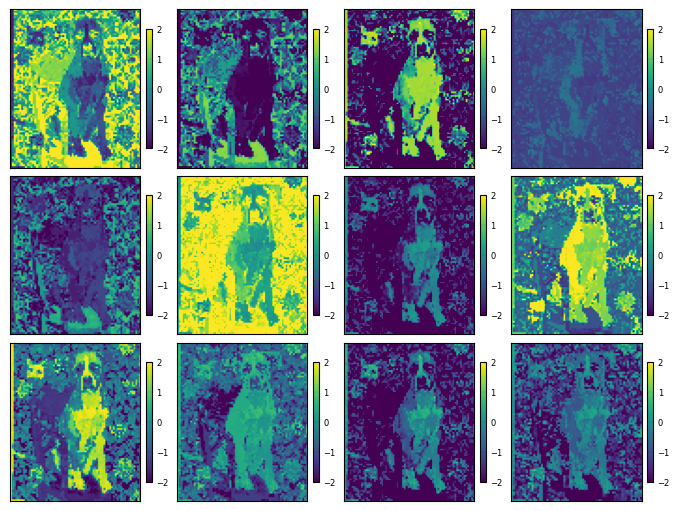

In [19]:
# computes the embeddings
embeddings(encode, shape_=image.shape[0:2], figsize=(15, 5), clim=(-2, 2))


- This is clearly an overcomplete example since we are learning 10 timesteps with 12 latent variables


- We know that we only have 3 intrinsic latent variables


## Model with 3 latent variables

### Instantiates the model (3 latent variables)


In [20]:
# rebuilds the model with 3 latent dimensions
encoder = Encoder(latent_dim=3).to(device)
decoder = Decoder(latent_dim=3).to(device)
model = Autoencoder(encoder, decoder).to(device)

# optimizer
optimizer = optim.Adam(model.parameters(), lr=3e-4)


In [21]:
# prints the summary of the model
summary(model, ((X_train.shape[1:])))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                    [-1, 3]              33
           Encoder-2                    [-1, 3]               0
            Linear-3                   [-1, 10]              40
           Decoder-4                   [-1, 10]               0
Total params: 73
Trainable params: 73
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


- Encoder with 3 latent dimensions
- Decoder with with size 10 --> same as orignal spectral length
- Autoencoder considers time by saying each timestep is its own fully-uncorrelated sample


In [22]:
train_iterator = torch.utils.data.DataLoader(
    X_train, batch_size=256, shuffle=True)


### Trains the model


In [23]:
random_seed(seed=42)
Train(model, encoder, decoder, train_iterator, optimizer, 500, device=device)


100%|██████████| 19/19 [00:00<00:00, 228.10it/s]


Epoch 0, Train Loss: 2.3594
.............................


100%|██████████| 19/19 [00:00<00:00, 222.58it/s]


Epoch 1, Train Loss: 2.3181
.............................


100%|██████████| 19/19 [00:00<00:00, 159.43it/s]


Epoch 2, Train Loss: 2.2805
.............................


100%|██████████| 19/19 [00:00<00:00, 187.25it/s]


Epoch 3, Train Loss: 2.2494
.............................


100%|██████████| 19/19 [00:00<00:00, 191.35it/s]


Epoch 4, Train Loss: 2.2163
.............................


100%|██████████| 19/19 [00:00<00:00, 203.32it/s]


Epoch 5, Train Loss: 2.1850
.............................


100%|██████████| 19/19 [00:00<00:00, 214.83it/s]


Epoch 6, Train Loss: 2.1561
.............................


100%|██████████| 19/19 [00:00<00:00, 224.29it/s]


Epoch 7, Train Loss: 2.1224
.............................


100%|██████████| 19/19 [00:00<00:00, 215.31it/s]


Epoch 8, Train Loss: 2.0912
.............................


100%|██████████| 19/19 [00:00<00:00, 217.12it/s]


Epoch 9, Train Loss: 2.0593
.............................


100%|██████████| 19/19 [00:00<00:00, 208.05it/s]


Epoch 10, Train Loss: 2.0236
.............................


100%|██████████| 19/19 [00:00<00:00, 208.84it/s]


Epoch 11, Train Loss: 1.9853
.............................


100%|██████████| 19/19 [00:00<00:00, 216.19it/s]


Epoch 12, Train Loss: 1.9495
.............................


100%|██████████| 19/19 [00:00<00:00, 194.15it/s]


Epoch 13, Train Loss: 1.9113
.............................


100%|██████████| 19/19 [00:00<00:00, 178.22it/s]


Epoch 14, Train Loss: 1.8703
.............................


100%|██████████| 19/19 [00:00<00:00, 191.30it/s]


Epoch 15, Train Loss: 1.8264
.............................


100%|██████████| 19/19 [00:00<00:00, 188.58it/s]


Epoch 16, Train Loss: 1.7808
.............................


100%|██████████| 19/19 [00:00<00:00, 194.26it/s]


Epoch 17, Train Loss: 1.7369
.............................


100%|██████████| 19/19 [00:00<00:00, 199.85it/s]


Epoch 18, Train Loss: 1.6876
.............................


100%|██████████| 19/19 [00:00<00:00, 192.36it/s]


Epoch 19, Train Loss: 1.6333
.............................


100%|██████████| 19/19 [00:00<00:00, 208.55it/s]


Epoch 20, Train Loss: 1.5798
.............................


100%|██████████| 19/19 [00:00<00:00, 241.38it/s]


Epoch 21, Train Loss: 1.5261
.............................


100%|██████████| 19/19 [00:00<00:00, 253.16it/s]


Epoch 22, Train Loss: 1.4660
.............................


100%|██████████| 19/19 [00:00<00:00, 260.17it/s]


Epoch 23, Train Loss: 1.4064
.............................


100%|██████████| 19/19 [00:00<00:00, 242.14it/s]


Epoch 24, Train Loss: 1.3457
.............................


100%|██████████| 19/19 [00:00<00:00, 240.58it/s]


Epoch 25, Train Loss: 1.2864
.............................


100%|██████████| 19/19 [00:00<00:00, 234.42it/s]


Epoch 26, Train Loss: 1.2266
.............................


100%|██████████| 19/19 [00:00<00:00, 265.69it/s]


Epoch 27, Train Loss: 1.1686
.............................


100%|██████████| 19/19 [00:00<00:00, 274.65it/s]


Epoch 28, Train Loss: 1.1097
.............................


100%|██████████| 19/19 [00:00<00:00, 282.24it/s]


Epoch 29, Train Loss: 1.0524
.............................


100%|██████████| 19/19 [00:00<00:00, 272.11it/s]


Epoch 30, Train Loss: 0.9975
.............................


100%|██████████| 19/19 [00:00<00:00, 279.40it/s]


Epoch 31, Train Loss: 0.9439
.............................


100%|██████████| 19/19 [00:00<00:00, 215.95it/s]


Epoch 32, Train Loss: 0.8917
.............................


100%|██████████| 19/19 [00:00<00:00, 219.06it/s]


Epoch 33, Train Loss: 0.8427
.............................


100%|██████████| 19/19 [00:00<00:00, 258.10it/s]


Epoch 34, Train Loss: 0.7950
.............................


100%|██████████| 19/19 [00:00<00:00, 265.09it/s]


Epoch 35, Train Loss: 0.7502
.............................


100%|██████████| 19/19 [00:00<00:00, 284.35it/s]


Epoch 36, Train Loss: 0.7077
.............................


100%|██████████| 19/19 [00:00<00:00, 276.88it/s]


Epoch 37, Train Loss: 0.6668
.............................


100%|██████████| 19/19 [00:00<00:00, 273.21it/s]


Epoch 38, Train Loss: 0.6293
.............................


100%|██████████| 19/19 [00:00<00:00, 269.57it/s]


Epoch 39, Train Loss: 0.5935
.............................


100%|██████████| 19/19 [00:00<00:00, 281.54it/s]


Epoch 40, Train Loss: 0.5598
.............................


100%|██████████| 19/19 [00:00<00:00, 263.88it/s]


Epoch 41, Train Loss: 0.5290
.............................


100%|██████████| 19/19 [00:00<00:00, 284.66it/s]


Epoch 42, Train Loss: 0.5001
.............................


100%|██████████| 19/19 [00:00<00:00, 283.64it/s]


Epoch 43, Train Loss: 0.4723
.............................


100%|██████████| 19/19 [00:00<00:00, 278.82it/s]


Epoch 44, Train Loss: 0.4470
.............................


100%|██████████| 19/19 [00:00<00:00, 288.24it/s]


Epoch 45, Train Loss: 0.4242
.............................


100%|██████████| 19/19 [00:00<00:00, 275.68it/s]


Epoch 46, Train Loss: 0.4030
.............................


100%|██████████| 19/19 [00:00<00:00, 292.98it/s]


Epoch 47, Train Loss: 0.3825
.............................


100%|██████████| 19/19 [00:00<00:00, 308.32it/s]


Epoch 48, Train Loss: 0.3655
.............................


100%|██████████| 19/19 [00:00<00:00, 298.76it/s]


Epoch 49, Train Loss: 0.3486
.............................


100%|██████████| 19/19 [00:00<00:00, 253.28it/s]


Epoch 50, Train Loss: 0.3335
.............................


100%|██████████| 19/19 [00:00<00:00, 271.81it/s]


Epoch 51, Train Loss: 0.3193
.............................


100%|██████████| 19/19 [00:00<00:00, 172.48it/s]


Epoch 52, Train Loss: 0.3065
.............................


100%|██████████| 19/19 [00:00<00:00, 234.04it/s]


Epoch 53, Train Loss: 0.2943
.............................


100%|██████████| 19/19 [00:00<00:00, 214.68it/s]


Epoch 54, Train Loss: 0.2836
.............................


100%|██████████| 19/19 [00:00<00:00, 251.42it/s]


Epoch 55, Train Loss: 0.2732
.............................


100%|██████████| 19/19 [00:00<00:00, 252.27it/s]


Epoch 56, Train Loss: 0.2647
.............................


100%|██████████| 19/19 [00:00<00:00, 272.19it/s]


Epoch 57, Train Loss: 0.2565
.............................


100%|██████████| 19/19 [00:00<00:00, 259.68it/s]


Epoch 58, Train Loss: 0.2486
.............................


100%|██████████| 19/19 [00:00<00:00, 255.05it/s]


Epoch 59, Train Loss: 0.2418
.............................


100%|██████████| 19/19 [00:00<00:00, 279.13it/s]


Epoch 60, Train Loss: 0.2354
.............................


100%|██████████| 19/19 [00:00<00:00, 307.24it/s]


Epoch 61, Train Loss: 0.2295
.............................


100%|██████████| 19/19 [00:00<00:00, 315.57it/s]


Epoch 62, Train Loss: 0.2243
.............................


100%|██████████| 19/19 [00:00<00:00, 302.81it/s]


Epoch 63, Train Loss: 0.2194
.............................


100%|██████████| 19/19 [00:00<00:00, 299.17it/s]


Epoch 64, Train Loss: 0.2149
.............................


100%|██████████| 19/19 [00:00<00:00, 316.98it/s]


Epoch 65, Train Loss: 0.2106
.............................


100%|██████████| 19/19 [00:00<00:00, 332.44it/s]


Epoch 66, Train Loss: 0.2071
.............................


100%|██████████| 19/19 [00:00<00:00, 353.74it/s]


Epoch 67, Train Loss: 0.2032
.............................


100%|██████████| 19/19 [00:00<00:00, 328.47it/s]


Epoch 68, Train Loss: 0.2003
.............................


100%|██████████| 19/19 [00:00<00:00, 324.85it/s]


Epoch 69, Train Loss: 0.1968
.............................


100%|██████████| 19/19 [00:00<00:00, 305.30it/s]


Epoch 70, Train Loss: 0.1943
.............................


100%|██████████| 19/19 [00:00<00:00, 216.59it/s]


Epoch 71, Train Loss: 0.1916
.............................


100%|██████████| 19/19 [00:00<00:00, 251.94it/s]


Epoch 72, Train Loss: 0.1892
.............................


100%|██████████| 19/19 [00:00<00:00, 237.73it/s]


Epoch 73, Train Loss: 0.1871
.............................


100%|██████████| 19/19 [00:00<00:00, 243.79it/s]


Epoch 74, Train Loss: 0.1847
.............................


100%|██████████| 19/19 [00:00<00:00, 294.46it/s]


Epoch 75, Train Loss: 0.1827
.............................


100%|██████████| 19/19 [00:00<00:00, 289.09it/s]


Epoch 76, Train Loss: 0.1810
.............................


100%|██████████| 19/19 [00:00<00:00, 329.43it/s]


Epoch 77, Train Loss: 0.1790
.............................


100%|██████████| 19/19 [00:00<00:00, 309.00it/s]


Epoch 78, Train Loss: 0.1775
.............................


100%|██████████| 19/19 [00:00<00:00, 320.68it/s]


Epoch 79, Train Loss: 0.1761
.............................


100%|██████████| 19/19 [00:00<00:00, 322.99it/s]


Epoch 80, Train Loss: 0.1748
.............................


100%|██████████| 19/19 [00:00<00:00, 284.82it/s]


Epoch 81, Train Loss: 0.1733
.............................


100%|██████████| 19/19 [00:00<00:00, 286.50it/s]


Epoch 82, Train Loss: 0.1723
.............................


100%|██████████| 19/19 [00:00<00:00, 291.60it/s]


Epoch 83, Train Loss: 0.1712
.............................


100%|██████████| 19/19 [00:00<00:00, 284.51it/s]


Epoch 84, Train Loss: 0.1699
.............................


100%|██████████| 19/19 [00:00<00:00, 275.28it/s]


Epoch 85, Train Loss: 0.1690
.............................


100%|██████████| 19/19 [00:00<00:00, 268.79it/s]


Epoch 86, Train Loss: 0.1679
.............................


100%|██████████| 19/19 [00:00<00:00, 247.23it/s]


Epoch 87, Train Loss: 0.1672
.............................


100%|██████████| 19/19 [00:00<00:00, 286.87it/s]


Epoch 88, Train Loss: 0.1664
.............................


100%|██████████| 19/19 [00:00<00:00, 260.92it/s]


Epoch 89, Train Loss: 0.1657
.............................


100%|██████████| 19/19 [00:00<00:00, 212.01it/s]


Epoch 90, Train Loss: 0.1649
.............................


100%|██████████| 19/19 [00:00<00:00, 249.46it/s]


Epoch 91, Train Loss: 0.1641
.............................


100%|██████████| 19/19 [00:00<00:00, 265.61it/s]


Epoch 92, Train Loss: 0.1634
.............................


100%|██████████| 19/19 [00:00<00:00, 266.85it/s]


Epoch 93, Train Loss: 0.1628
.............................


100%|██████████| 19/19 [00:00<00:00, 276.79it/s]


Epoch 94, Train Loss: 0.1623
.............................


100%|██████████| 19/19 [00:00<00:00, 293.32it/s]


Epoch 95, Train Loss: 0.1619
.............................


100%|██████████| 19/19 [00:00<00:00, 308.70it/s]


Epoch 96, Train Loss: 0.1612
.............................


100%|██████████| 19/19 [00:00<00:00, 327.43it/s]


Epoch 97, Train Loss: 0.1608
.............................


100%|██████████| 19/19 [00:00<00:00, 293.64it/s]


Epoch 98, Train Loss: 0.1604
.............................


100%|██████████| 19/19 [00:00<00:00, 325.84it/s]


Epoch 99, Train Loss: 0.1599
.............................


100%|██████████| 19/19 [00:00<00:00, 298.98it/s]


Epoch 100, Train Loss: 0.1595
.............................


100%|██████████| 19/19 [00:00<00:00, 277.06it/s]


Epoch 101, Train Loss: 0.1592
.............................


100%|██████████| 19/19 [00:00<00:00, 321.40it/s]


Epoch 102, Train Loss: 0.1587
.............................


100%|██████████| 19/19 [00:00<00:00, 300.23it/s]


Epoch 103, Train Loss: 0.1585
.............................


100%|██████████| 19/19 [00:00<00:00, 303.97it/s]


Epoch 104, Train Loss: 0.1581
.............................


100%|██████████| 19/19 [00:00<00:00, 300.15it/s]


Epoch 105, Train Loss: 0.1578
.............................


100%|██████████| 19/19 [00:00<00:00, 336.88it/s]


Epoch 106, Train Loss: 0.1574
.............................


100%|██████████| 19/19 [00:00<00:00, 347.13it/s]


Epoch 107, Train Loss: 0.1570
.............................


100%|██████████| 19/19 [00:00<00:00, 256.17it/s]


Epoch 108, Train Loss: 0.1569
.............................


100%|██████████| 19/19 [00:00<00:00, 301.51it/s]


Epoch 109, Train Loss: 0.1566
.............................


100%|██████████| 19/19 [00:00<00:00, 331.72it/s]


Epoch 110, Train Loss: 0.1563
.............................


100%|██████████| 19/19 [00:00<00:00, 332.98it/s]


Epoch 111, Train Loss: 0.1561
.............................


100%|██████████| 19/19 [00:00<00:00, 322.49it/s]


Epoch 112, Train Loss: 0.1559
.............................


100%|██████████| 19/19 [00:00<00:00, 341.43it/s]


Epoch 113, Train Loss: 0.1558
.............................


100%|██████████| 19/19 [00:00<00:00, 315.01it/s]


Epoch 114, Train Loss: 0.1554
.............................


100%|██████████| 19/19 [00:00<00:00, 299.88it/s]


Epoch 115, Train Loss: 0.1551
.............................


100%|██████████| 19/19 [00:00<00:00, 283.26it/s]


Epoch 116, Train Loss: 0.1547
.............................


100%|██████████| 19/19 [00:00<00:00, 318.87it/s]


Epoch 117, Train Loss: 0.1545
.............................


100%|██████████| 19/19 [00:00<00:00, 263.08it/s]


Epoch 118, Train Loss: 0.1544
.............................


100%|██████████| 19/19 [00:00<00:00, 223.81it/s]


Epoch 119, Train Loss: 0.1540
.............................


100%|██████████| 19/19 [00:00<00:00, 238.20it/s]


Epoch 120, Train Loss: 0.1540
.............................


100%|██████████| 19/19 [00:00<00:00, 234.80it/s]


Epoch 121, Train Loss: 0.1537
.............................


100%|██████████| 19/19 [00:00<00:00, 203.91it/s]


Epoch 122, Train Loss: 0.1535
.............................


100%|██████████| 19/19 [00:00<00:00, 234.83it/s]


Epoch 123, Train Loss: 0.1534
.............................


100%|██████████| 19/19 [00:00<00:00, 225.87it/s]


Epoch 124, Train Loss: 0.1530
.............................


100%|██████████| 19/19 [00:00<00:00, 195.77it/s]


Epoch 125, Train Loss: 0.1527
.............................


100%|██████████| 19/19 [00:00<00:00, 250.39it/s]


Epoch 126, Train Loss: 0.1527
.............................


100%|██████████| 19/19 [00:00<00:00, 259.05it/s]


Epoch 127, Train Loss: 0.1524
.............................


100%|██████████| 19/19 [00:00<00:00, 261.59it/s]


Epoch 128, Train Loss: 0.1520
.............................


100%|██████████| 19/19 [00:00<00:00, 278.49it/s]


Epoch 129, Train Loss: 0.1518
.............................


100%|██████████| 19/19 [00:00<00:00, 283.49it/s]


Epoch 130, Train Loss: 0.1518
.............................


100%|██████████| 19/19 [00:00<00:00, 261.69it/s]


Epoch 131, Train Loss: 0.1514
.............................


100%|██████████| 19/19 [00:00<00:00, 294.43it/s]


Epoch 132, Train Loss: 0.1514
.............................


100%|██████████| 19/19 [00:00<00:00, 332.73it/s]


Epoch 133, Train Loss: 0.1510
.............................


100%|██████████| 19/19 [00:00<00:00, 323.29it/s]


Epoch 134, Train Loss: 0.1509
.............................


100%|██████████| 19/19 [00:00<00:00, 346.55it/s]


Epoch 135, Train Loss: 0.1506
.............................


100%|██████████| 19/19 [00:00<00:00, 341.84it/s]


Epoch 136, Train Loss: 0.1505
.............................


100%|██████████| 19/19 [00:00<00:00, 343.80it/s]


Epoch 137, Train Loss: 0.1501
.............................


100%|██████████| 19/19 [00:00<00:00, 342.53it/s]


Epoch 138, Train Loss: 0.1499
.............................


100%|██████████| 19/19 [00:00<00:00, 319.66it/s]


Epoch 139, Train Loss: 0.1496
.............................


100%|██████████| 19/19 [00:00<00:00, 331.78it/s]


Epoch 140, Train Loss: 0.1493
.............................


100%|██████████| 19/19 [00:00<00:00, 297.50it/s]


Epoch 141, Train Loss: 0.1493
.............................


100%|██████████| 19/19 [00:00<00:00, 299.31it/s]


Epoch 142, Train Loss: 0.1490
.............................


100%|██████████| 19/19 [00:00<00:00, 269.62it/s]


Epoch 143, Train Loss: 0.1486
.............................


100%|██████████| 19/19 [00:00<00:00, 223.50it/s]


Epoch 144, Train Loss: 0.1485
.............................


100%|██████████| 19/19 [00:00<00:00, 287.30it/s]


Epoch 145, Train Loss: 0.1483
.............................


100%|██████████| 19/19 [00:00<00:00, 271.77it/s]


Epoch 146, Train Loss: 0.1479
.............................


100%|██████████| 19/19 [00:00<00:00, 274.06it/s]


Epoch 147, Train Loss: 0.1478
.............................


100%|██████████| 19/19 [00:00<00:00, 271.30it/s]


Epoch 148, Train Loss: 0.1474
.............................


100%|██████████| 19/19 [00:00<00:00, 264.93it/s]


Epoch 149, Train Loss: 0.1474
.............................


100%|██████████| 19/19 [00:00<00:00, 295.81it/s]


Epoch 150, Train Loss: 0.1470
.............................


100%|██████████| 19/19 [00:00<00:00, 324.33it/s]


Epoch 151, Train Loss: 0.1469
.............................


100%|██████████| 19/19 [00:00<00:00, 316.99it/s]


Epoch 152, Train Loss: 0.1466
.............................


100%|██████████| 19/19 [00:00<00:00, 333.17it/s]


Epoch 153, Train Loss: 0.1463
.............................


100%|██████████| 19/19 [00:00<00:00, 300.44it/s]


Epoch 154, Train Loss: 0.1461
.............................


100%|██████████| 19/19 [00:00<00:00, 255.35it/s]


Epoch 155, Train Loss: 0.1458
.............................


100%|██████████| 19/19 [00:00<00:00, 265.11it/s]


Epoch 156, Train Loss: 0.1456
.............................


100%|██████████| 19/19 [00:00<00:00, 252.64it/s]


Epoch 157, Train Loss: 0.1452
.............................


100%|██████████| 19/19 [00:00<00:00, 264.29it/s]


Epoch 158, Train Loss: 0.1451
.............................


100%|██████████| 19/19 [00:00<00:00, 272.54it/s]


Epoch 159, Train Loss: 0.1447
.............................


100%|██████████| 19/19 [00:00<00:00, 223.46it/s]


Epoch 160, Train Loss: 0.1445
.............................


100%|██████████| 19/19 [00:00<00:00, 281.27it/s]


Epoch 161, Train Loss: 0.1441
.............................


100%|██████████| 19/19 [00:00<00:00, 252.58it/s]


Epoch 162, Train Loss: 0.1440
.............................


100%|██████████| 19/19 [00:00<00:00, 257.79it/s]


Epoch 163, Train Loss: 0.1438
.............................


100%|██████████| 19/19 [00:00<00:00, 285.38it/s]


Epoch 164, Train Loss: 0.1434
.............................


100%|██████████| 19/19 [00:00<00:00, 306.79it/s]


Epoch 165, Train Loss: 0.1431
.............................


100%|██████████| 19/19 [00:00<00:00, 315.31it/s]


Epoch 166, Train Loss: 0.1429
.............................


100%|██████████| 19/19 [00:00<00:00, 334.27it/s]


Epoch 167, Train Loss: 0.1426
.............................


100%|██████████| 19/19 [00:00<00:00, 330.54it/s]


Epoch 168, Train Loss: 0.1425
.............................


100%|██████████| 19/19 [00:00<00:00, 336.94it/s]


Epoch 169, Train Loss: 0.1422
.............................


100%|██████████| 19/19 [00:00<00:00, 308.53it/s]


Epoch 170, Train Loss: 0.1420
.............................


100%|██████████| 19/19 [00:00<00:00, 316.29it/s]


Epoch 171, Train Loss: 0.1414
.............................


100%|██████████| 19/19 [00:00<00:00, 316.32it/s]


Epoch 172, Train Loss: 0.1412
.............................


100%|██████████| 19/19 [00:00<00:00, 313.01it/s]


Epoch 173, Train Loss: 0.1411
.............................


100%|██████████| 19/19 [00:00<00:00, 326.22it/s]


Epoch 174, Train Loss: 0.1407
.............................


100%|██████████| 19/19 [00:00<00:00, 316.09it/s]


Epoch 175, Train Loss: 0.1407
.............................


100%|██████████| 19/19 [00:00<00:00, 250.88it/s]


Epoch 176, Train Loss: 0.1399
.............................


100%|██████████| 19/19 [00:00<00:00, 277.15it/s]


Epoch 177, Train Loss: 0.1402
.............................


100%|██████████| 19/19 [00:00<00:00, 248.44it/s]


Epoch 178, Train Loss: 0.1397
.............................


100%|██████████| 19/19 [00:00<00:00, 228.79it/s]


Epoch 179, Train Loss: 0.1395
.............................


100%|██████████| 19/19 [00:00<00:00, 242.82it/s]


Epoch 180, Train Loss: 0.1391
.............................


100%|██████████| 19/19 [00:00<00:00, 249.98it/s]


Epoch 181, Train Loss: 0.1387
.............................


100%|██████████| 19/19 [00:00<00:00, 236.93it/s]


Epoch 182, Train Loss: 0.1385
.............................


100%|██████████| 19/19 [00:00<00:00, 202.27it/s]


Epoch 183, Train Loss: 0.1382
.............................


100%|██████████| 19/19 [00:00<00:00, 179.66it/s]


Epoch 184, Train Loss: 0.1378
.............................


100%|██████████| 19/19 [00:00<00:00, 167.07it/s]


Epoch 185, Train Loss: 0.1378
.............................


100%|██████████| 19/19 [00:00<00:00, 179.00it/s]


Epoch 186, Train Loss: 0.1371
.............................


100%|██████████| 19/19 [00:00<00:00, 184.61it/s]


Epoch 187, Train Loss: 0.1370
.............................


100%|██████████| 19/19 [00:00<00:00, 164.12it/s]


Epoch 188, Train Loss: 0.1367
.............................


100%|██████████| 19/19 [00:00<00:00, 170.58it/s]


Epoch 189, Train Loss: 0.1365
.............................


100%|██████████| 19/19 [00:00<00:00, 168.98it/s]


Epoch 190, Train Loss: 0.1363
.............................


100%|██████████| 19/19 [00:00<00:00, 135.05it/s]


Epoch 191, Train Loss: 0.1361
.............................


100%|██████████| 19/19 [00:00<00:00, 162.10it/s]


Epoch 192, Train Loss: 0.1356
.............................


100%|██████████| 19/19 [00:00<00:00, 184.59it/s]


Epoch 193, Train Loss: 0.1355
.............................


100%|██████████| 19/19 [00:00<00:00, 196.75it/s]


Epoch 194, Train Loss: 0.1350
.............................


100%|██████████| 19/19 [00:00<00:00, 193.07it/s]


Epoch 195, Train Loss: 0.1349
.............................


100%|██████████| 19/19 [00:00<00:00, 186.01it/s]


Epoch 196, Train Loss: 0.1343
.............................


100%|██████████| 19/19 [00:00<00:00, 171.16it/s]


Epoch 197, Train Loss: 0.1342
.............................


100%|██████████| 19/19 [00:00<00:00, 197.45it/s]


Epoch 198, Train Loss: 0.1338
.............................


100%|██████████| 19/19 [00:00<00:00, 217.92it/s]


Epoch 199, Train Loss: 0.1336
.............................


100%|██████████| 19/19 [00:00<00:00, 180.14it/s]


Epoch 200, Train Loss: 0.1333
.............................


100%|██████████| 19/19 [00:00<00:00, 175.83it/s]


Epoch 201, Train Loss: 0.1328
.............................


100%|██████████| 19/19 [00:00<00:00, 193.38it/s]


Epoch 202, Train Loss: 0.1326
.............................


100%|██████████| 19/19 [00:00<00:00, 222.23it/s]


Epoch 203, Train Loss: 0.1325
.............................


100%|██████████| 19/19 [00:00<00:00, 260.24it/s]


Epoch 204, Train Loss: 0.1321
.............................


100%|██████████| 19/19 [00:00<00:00, 198.41it/s]


Epoch 205, Train Loss: 0.1320
.............................


100%|██████████| 19/19 [00:00<00:00, 219.20it/s]


Epoch 206, Train Loss: 0.1314
.............................


100%|██████████| 19/19 [00:00<00:00, 231.77it/s]


Epoch 207, Train Loss: 0.1311
.............................


100%|██████████| 19/19 [00:00<00:00, 237.17it/s]


Epoch 208, Train Loss: 0.1309
.............................


100%|██████████| 19/19 [00:00<00:00, 256.41it/s]


Epoch 209, Train Loss: 0.1304
.............................


100%|██████████| 19/19 [00:00<00:00, 260.21it/s]


Epoch 210, Train Loss: 0.1303
.............................


100%|██████████| 19/19 [00:00<00:00, 257.76it/s]


Epoch 211, Train Loss: 0.1302
.............................


100%|██████████| 19/19 [00:00<00:00, 270.74it/s]


Epoch 212, Train Loss: 0.1298
.............................


100%|██████████| 19/19 [00:00<00:00, 276.03it/s]


Epoch 213, Train Loss: 0.1294
.............................


100%|██████████| 19/19 [00:00<00:00, 272.45it/s]


Epoch 214, Train Loss: 0.1292
.............................


100%|██████████| 19/19 [00:00<00:00, 278.50it/s]


Epoch 215, Train Loss: 0.1287
.............................


100%|██████████| 19/19 [00:00<00:00, 274.08it/s]


Epoch 216, Train Loss: 0.1285
.............................


100%|██████████| 19/19 [00:00<00:00, 292.27it/s]


Epoch 217, Train Loss: 0.1282
.............................


100%|██████████| 19/19 [00:00<00:00, 319.23it/s]


Epoch 218, Train Loss: 0.1280
.............................


100%|██████████| 19/19 [00:00<00:00, 307.27it/s]


Epoch 219, Train Loss: 0.1277
.............................


100%|██████████| 19/19 [00:00<00:00, 252.93it/s]


Epoch 220, Train Loss: 0.1274
.............................


100%|██████████| 19/19 [00:00<00:00, 278.27it/s]


Epoch 221, Train Loss: 0.1271
.............................


100%|██████████| 19/19 [00:00<00:00, 319.17it/s]


Epoch 222, Train Loss: 0.1268
.............................


100%|██████████| 19/19 [00:00<00:00, 338.47it/s]


Epoch 223, Train Loss: 0.1266
.............................


100%|██████████| 19/19 [00:00<00:00, 331.54it/s]


Epoch 224, Train Loss: 0.1264
.............................


100%|██████████| 19/19 [00:00<00:00, 341.32it/s]


Epoch 225, Train Loss: 0.1260
.............................


100%|██████████| 19/19 [00:00<00:00, 320.93it/s]


Epoch 226, Train Loss: 0.1255
.............................


100%|██████████| 19/19 [00:00<00:00, 343.23it/s]


Epoch 227, Train Loss: 0.1253
.............................


100%|██████████| 19/19 [00:00<00:00, 338.28it/s]


Epoch 228, Train Loss: 0.1250
.............................


100%|██████████| 19/19 [00:00<00:00, 337.27it/s]


Epoch 229, Train Loss: 0.1250
.............................


100%|██████████| 19/19 [00:00<00:00, 346.42it/s]


Epoch 230, Train Loss: 0.1244
.............................


100%|██████████| 19/19 [00:00<00:00, 360.60it/s]


Epoch 231, Train Loss: 0.1242
.............................


100%|██████████| 19/19 [00:00<00:00, 360.32it/s]


Epoch 232, Train Loss: 0.1238
.............................


100%|██████████| 19/19 [00:00<00:00, 364.59it/s]


Epoch 233, Train Loss: 0.1237
.............................


100%|██████████| 19/19 [00:00<00:00, 376.84it/s]


Epoch 234, Train Loss: 0.1233
.............................


100%|██████████| 19/19 [00:00<00:00, 258.24it/s]


Epoch 235, Train Loss: 0.1228
.............................


100%|██████████| 19/19 [00:00<00:00, 305.41it/s]


Epoch 236, Train Loss: 0.1228
.............................


100%|██████████| 19/19 [00:00<00:00, 282.08it/s]


Epoch 237, Train Loss: 0.1223
.............................


100%|██████████| 19/19 [00:00<00:00, 322.20it/s]


Epoch 238, Train Loss: 0.1220
.............................


100%|██████████| 19/19 [00:00<00:00, 323.39it/s]


Epoch 239, Train Loss: 0.1219
.............................


100%|██████████| 19/19 [00:00<00:00, 340.48it/s]


Epoch 240, Train Loss: 0.1217
.............................


100%|██████████| 19/19 [00:00<00:00, 331.06it/s]


Epoch 241, Train Loss: 0.1215
.............................


100%|██████████| 19/19 [00:00<00:00, 339.26it/s]


Epoch 242, Train Loss: 0.1210
.............................


100%|██████████| 19/19 [00:00<00:00, 330.87it/s]


Epoch 243, Train Loss: 0.1206
.............................


100%|██████████| 19/19 [00:00<00:00, 294.08it/s]


Epoch 244, Train Loss: 0.1204
.............................


100%|██████████| 19/19 [00:00<00:00, 280.02it/s]


Epoch 245, Train Loss: 0.1203
.............................


100%|██████████| 19/19 [00:00<00:00, 286.87it/s]


Epoch 246, Train Loss: 0.1198
.............................


100%|██████████| 19/19 [00:00<00:00, 259.93it/s]


Epoch 247, Train Loss: 0.1195
.............................


100%|██████████| 19/19 [00:00<00:00, 287.46it/s]


Epoch 248, Train Loss: 0.1193
.............................


100%|██████████| 19/19 [00:00<00:00, 271.88it/s]


Epoch 249, Train Loss: 0.1189
.............................


100%|██████████| 19/19 [00:00<00:00, 270.22it/s]


Epoch 250, Train Loss: 0.1188
.............................


100%|██████████| 19/19 [00:00<00:00, 215.63it/s]


Epoch 251, Train Loss: 0.1184
.............................


100%|██████████| 19/19 [00:00<00:00, 176.95it/s]


Epoch 252, Train Loss: 0.1184
.............................


100%|██████████| 19/19 [00:00<00:00, 240.20it/s]


Epoch 253, Train Loss: 0.1180
.............................


100%|██████████| 19/19 [00:00<00:00, 248.59it/s]


Epoch 254, Train Loss: 0.1177
.............................


100%|██████████| 19/19 [00:00<00:00, 268.54it/s]


Epoch 255, Train Loss: 0.1174
.............................


100%|██████████| 19/19 [00:00<00:00, 272.59it/s]


Epoch 256, Train Loss: 0.1170
.............................


100%|██████████| 19/19 [00:00<00:00, 259.38it/s]


Epoch 257, Train Loss: 0.1169
.............................


100%|██████████| 19/19 [00:00<00:00, 283.75it/s]


Epoch 258, Train Loss: 0.1166
.............................


100%|██████████| 19/19 [00:00<00:00, 294.65it/s]


Epoch 259, Train Loss: 0.1162
.............................


100%|██████████| 19/19 [00:00<00:00, 290.06it/s]


Epoch 260, Train Loss: 0.1161
.............................


100%|██████████| 19/19 [00:00<00:00, 330.16it/s]


Epoch 261, Train Loss: 0.1159
.............................


100%|██████████| 19/19 [00:00<00:00, 325.34it/s]


Epoch 262, Train Loss: 0.1156
.............................


100%|██████████| 19/19 [00:00<00:00, 323.85it/s]


Epoch 263, Train Loss: 0.1152
.............................


100%|██████████| 19/19 [00:00<00:00, 320.81it/s]


Epoch 264, Train Loss: 0.1150
.............................


100%|██████████| 19/19 [00:00<00:00, 331.66it/s]


Epoch 265, Train Loss: 0.1147
.............................


100%|██████████| 19/19 [00:00<00:00, 236.34it/s]


Epoch 266, Train Loss: 0.1145
.............................


100%|██████████| 19/19 [00:00<00:00, 282.71it/s]


Epoch 267, Train Loss: 0.1143
.............................


100%|██████████| 19/19 [00:00<00:00, 280.41it/s]


Epoch 268, Train Loss: 0.1140
.............................


100%|██████████| 19/19 [00:00<00:00, 272.89it/s]


Epoch 269, Train Loss: 0.1137
.............................


100%|██████████| 19/19 [00:00<00:00, 251.82it/s]


Epoch 270, Train Loss: 0.1135
.............................


100%|██████████| 19/19 [00:00<00:00, 256.64it/s]


Epoch 271, Train Loss: 0.1132
.............................


100%|██████████| 19/19 [00:00<00:00, 275.31it/s]


Epoch 272, Train Loss: 0.1132
.............................


100%|██████████| 19/19 [00:00<00:00, 301.45it/s]


Epoch 273, Train Loss: 0.1127
.............................


100%|██████████| 19/19 [00:00<00:00, 305.42it/s]


Epoch 274, Train Loss: 0.1126
.............................


100%|██████████| 19/19 [00:00<00:00, 321.74it/s]


Epoch 275, Train Loss: 0.1125
.............................


100%|██████████| 19/19 [00:00<00:00, 306.34it/s]


Epoch 276, Train Loss: 0.1122
.............................


100%|██████████| 19/19 [00:00<00:00, 328.89it/s]


Epoch 277, Train Loss: 0.1119
.............................


100%|██████████| 19/19 [00:00<00:00, 305.77it/s]


Epoch 278, Train Loss: 0.1117
.............................


100%|██████████| 19/19 [00:00<00:00, 310.14it/s]


Epoch 279, Train Loss: 0.1113
.............................


100%|██████████| 19/19 [00:00<00:00, 305.69it/s]


Epoch 280, Train Loss: 0.1113
.............................


100%|██████████| 19/19 [00:00<00:00, 318.80it/s]


Epoch 281, Train Loss: 0.1110
.............................


100%|██████████| 19/19 [00:00<00:00, 273.18it/s]


Epoch 282, Train Loss: 0.1109
.............................


100%|██████████| 19/19 [00:00<00:00, 204.75it/s]


Epoch 283, Train Loss: 0.1106
.............................


100%|██████████| 19/19 [00:00<00:00, 236.21it/s]


Epoch 284, Train Loss: 0.1104
.............................


100%|██████████| 19/19 [00:00<00:00, 242.70it/s]


Epoch 285, Train Loss: 0.1100
.............................


100%|██████████| 19/19 [00:00<00:00, 258.21it/s]


Epoch 286, Train Loss: 0.1097
.............................


100%|██████████| 19/19 [00:00<00:00, 278.12it/s]


Epoch 287, Train Loss: 0.1094
.............................


100%|██████████| 19/19 [00:00<00:00, 277.86it/s]


Epoch 288, Train Loss: 0.1096
.............................


100%|██████████| 19/19 [00:00<00:00, 318.06it/s]


Epoch 289, Train Loss: 0.1092
.............................


100%|██████████| 19/19 [00:00<00:00, 262.96it/s]


Epoch 290, Train Loss: 0.1091
.............................


100%|██████████| 19/19 [00:00<00:00, 255.60it/s]


Epoch 291, Train Loss: 0.1089
.............................


100%|██████████| 19/19 [00:00<00:00, 251.49it/s]


Epoch 292, Train Loss: 0.1084
.............................


100%|██████████| 19/19 [00:00<00:00, 251.07it/s]


Epoch 293, Train Loss: 0.1084
.............................


100%|██████████| 19/19 [00:00<00:00, 230.14it/s]


Epoch 294, Train Loss: 0.1083
.............................


100%|██████████| 19/19 [00:00<00:00, 263.83it/s]


Epoch 295, Train Loss: 0.1081
.............................


100%|██████████| 19/19 [00:00<00:00, 258.43it/s]


Epoch 296, Train Loss: 0.1079
.............................


100%|██████████| 19/19 [00:00<00:00, 208.03it/s]


Epoch 297, Train Loss: 0.1076
.............................


100%|██████████| 19/19 [00:00<00:00, 261.74it/s]


Epoch 298, Train Loss: 0.1073
.............................


100%|██████████| 19/19 [00:00<00:00, 289.80it/s]


Epoch 299, Train Loss: 0.1072
.............................


100%|██████████| 19/19 [00:00<00:00, 292.32it/s]


Epoch 300, Train Loss: 0.1068
.............................


100%|██████████| 19/19 [00:00<00:00, 308.77it/s]


Epoch 301, Train Loss: 0.1068
.............................


100%|██████████| 19/19 [00:00<00:00, 313.87it/s]


Epoch 302, Train Loss: 0.1068
.............................


100%|██████████| 19/19 [00:00<00:00, 322.05it/s]


Epoch 303, Train Loss: 0.1066
.............................


100%|██████████| 19/19 [00:00<00:00, 308.77it/s]


Epoch 304, Train Loss: 0.1063
.............................


100%|██████████| 19/19 [00:00<00:00, 321.98it/s]


Epoch 305, Train Loss: 0.1062
.............................


100%|██████████| 19/19 [00:00<00:00, 322.04it/s]


Epoch 306, Train Loss: 0.1058
.............................


100%|██████████| 19/19 [00:00<00:00, 280.64it/s]


Epoch 307, Train Loss: 0.1058
.............................


100%|██████████| 19/19 [00:00<00:00, 298.92it/s]


Epoch 308, Train Loss: 0.1060
.............................


100%|██████████| 19/19 [00:00<00:00, 317.60it/s]


Epoch 309, Train Loss: 0.1054
.............................


100%|██████████| 19/19 [00:00<00:00, 234.70it/s]


Epoch 310, Train Loss: 0.1054
.............................


100%|██████████| 19/19 [00:00<00:00, 267.46it/s]


Epoch 311, Train Loss: 0.1052
.............................


100%|██████████| 19/19 [00:00<00:00, 263.45it/s]


Epoch 312, Train Loss: 0.1052
.............................


100%|██████████| 19/19 [00:00<00:00, 250.08it/s]


Epoch 313, Train Loss: 0.1050
.............................


100%|██████████| 19/19 [00:00<00:00, 268.16it/s]


Epoch 314, Train Loss: 0.1048
.............................


100%|██████████| 19/19 [00:00<00:00, 266.41it/s]


Epoch 315, Train Loss: 0.1045
.............................


100%|██████████| 19/19 [00:00<00:00, 264.74it/s]


Epoch 316, Train Loss: 0.1043
.............................


100%|██████████| 19/19 [00:00<00:00, 271.60it/s]


Epoch 317, Train Loss: 0.1042
.............................


100%|██████████| 19/19 [00:00<00:00, 235.89it/s]


Epoch 318, Train Loss: 0.1040
.............................


100%|██████████| 19/19 [00:00<00:00, 233.86it/s]


Epoch 319, Train Loss: 0.1040
.............................


100%|██████████| 19/19 [00:00<00:00, 231.64it/s]


Epoch 320, Train Loss: 0.1040
.............................


100%|██████████| 19/19 [00:00<00:00, 252.97it/s]


Epoch 321, Train Loss: 0.1037
.............................


100%|██████████| 19/19 [00:00<00:00, 270.29it/s]


Epoch 322, Train Loss: 0.1037
.............................


100%|██████████| 19/19 [00:00<00:00, 301.28it/s]


Epoch 323, Train Loss: 0.1035
.............................


100%|██████████| 19/19 [00:00<00:00, 288.32it/s]


Epoch 324, Train Loss: 0.1033
.............................


100%|██████████| 19/19 [00:00<00:00, 311.94it/s]


Epoch 325, Train Loss: 0.1033
.............................


100%|██████████| 19/19 [00:00<00:00, 232.72it/s]


Epoch 326, Train Loss: 0.1029
.............................


100%|██████████| 19/19 [00:00<00:00, 279.97it/s]


Epoch 327, Train Loss: 0.1027
.............................


100%|██████████| 19/19 [00:00<00:00, 299.71it/s]


Epoch 328, Train Loss: 0.1028
.............................


100%|██████████| 19/19 [00:00<00:00, 295.69it/s]


Epoch 329, Train Loss: 0.1027
.............................


100%|██████████| 19/19 [00:00<00:00, 311.38it/s]


Epoch 330, Train Loss: 0.1027
.............................


100%|██████████| 19/19 [00:00<00:00, 324.24it/s]


Epoch 331, Train Loss: 0.1022
.............................


100%|██████████| 19/19 [00:00<00:00, 313.40it/s]


Epoch 332, Train Loss: 0.1023
.............................


100%|██████████| 19/19 [00:00<00:00, 305.93it/s]


Epoch 333, Train Loss: 0.1022
.............................


100%|██████████| 19/19 [00:00<00:00, 312.44it/s]


Epoch 334, Train Loss: 0.1020
.............................


100%|██████████| 19/19 [00:00<00:00, 317.36it/s]


Epoch 335, Train Loss: 0.1018
.............................


100%|██████████| 19/19 [00:00<00:00, 304.50it/s]


Epoch 336, Train Loss: 0.1019
.............................


100%|██████████| 19/19 [00:00<00:00, 292.25it/s]


Epoch 337, Train Loss: 0.1017
.............................


100%|██████████| 19/19 [00:00<00:00, 296.80it/s]


Epoch 338, Train Loss: 0.1017
.............................


100%|██████████| 19/19 [00:00<00:00, 262.01it/s]


Epoch 339, Train Loss: 0.1014
.............................


100%|██████████| 19/19 [00:00<00:00, 231.40it/s]


Epoch 340, Train Loss: 0.1011
.............................


100%|██████████| 19/19 [00:00<00:00, 224.76it/s]


Epoch 341, Train Loss: 0.1010
.............................


100%|██████████| 19/19 [00:00<00:00, 273.16it/s]


Epoch 342, Train Loss: 0.1010
.............................


100%|██████████| 19/19 [00:00<00:00, 280.02it/s]


Epoch 343, Train Loss: 0.1010
.............................


100%|██████████| 19/19 [00:00<00:00, 304.67it/s]


Epoch 344, Train Loss: 0.1008
.............................


100%|██████████| 19/19 [00:00<00:00, 315.22it/s]


Epoch 345, Train Loss: 0.1007
.............................


100%|██████████| 19/19 [00:00<00:00, 296.26it/s]


Epoch 346, Train Loss: 0.1006
.............................


100%|██████████| 19/19 [00:00<00:00, 296.75it/s]


Epoch 347, Train Loss: 0.1004
.............................


100%|██████████| 19/19 [00:00<00:00, 298.44it/s]


Epoch 348, Train Loss: 0.1002
.............................


100%|██████████| 19/19 [00:00<00:00, 262.67it/s]


Epoch 349, Train Loss: 0.1000
.............................


100%|██████████| 19/19 [00:00<00:00, 321.18it/s]


Epoch 350, Train Loss: 0.1001
.............................


100%|██████████| 19/19 [00:00<00:00, 309.63it/s]


Epoch 351, Train Loss: 0.1000
.............................


100%|██████████| 19/19 [00:00<00:00, 253.06it/s]


Epoch 352, Train Loss: 0.0998
.............................


100%|██████████| 19/19 [00:00<00:00, 284.18it/s]


Epoch 353, Train Loss: 0.0997
.............................


100%|██████████| 19/19 [00:00<00:00, 209.95it/s]


Epoch 354, Train Loss: 0.0998
.............................


100%|██████████| 19/19 [00:00<00:00, 288.21it/s]


Epoch 355, Train Loss: 0.0995
.............................


100%|██████████| 19/19 [00:00<00:00, 295.16it/s]


Epoch 356, Train Loss: 0.0992
.............................


100%|██████████| 19/19 [00:00<00:00, 296.70it/s]


Epoch 357, Train Loss: 0.0991
.............................


100%|██████████| 19/19 [00:00<00:00, 316.20it/s]


Epoch 358, Train Loss: 0.0992
.............................


100%|██████████| 19/19 [00:00<00:00, 333.56it/s]


Epoch 359, Train Loss: 0.0989
.............................


100%|██████████| 19/19 [00:00<00:00, 316.68it/s]


Epoch 360, Train Loss: 0.0986
.............................


100%|██████████| 19/19 [00:00<00:00, 314.25it/s]


Epoch 361, Train Loss: 0.0988
.............................


100%|██████████| 19/19 [00:00<00:00, 318.97it/s]


Epoch 362, Train Loss: 0.0987
.............................


100%|██████████| 19/19 [00:00<00:00, 317.28it/s]


Epoch 363, Train Loss: 0.0987
.............................


100%|██████████| 19/19 [00:00<00:00, 282.44it/s]


Epoch 364, Train Loss: 0.0985
.............................


100%|██████████| 19/19 [00:00<00:00, 298.51it/s]


Epoch 365, Train Loss: 0.0983
.............................


100%|██████████| 19/19 [00:00<00:00, 308.73it/s]


Epoch 366, Train Loss: 0.0982
.............................


100%|██████████| 19/19 [00:00<00:00, 231.43it/s]


Epoch 367, Train Loss: 0.0980
.............................


100%|██████████| 19/19 [00:00<00:00, 266.20it/s]


Epoch 368, Train Loss: 0.0980
.............................


100%|██████████| 19/19 [00:00<00:00, 285.42it/s]


Epoch 369, Train Loss: 0.0979
.............................


100%|██████████| 19/19 [00:00<00:00, 303.67it/s]


Epoch 370, Train Loss: 0.0975
.............................


100%|██████████| 19/19 [00:00<00:00, 321.77it/s]


Epoch 371, Train Loss: 0.0977
.............................


100%|██████████| 19/19 [00:00<00:00, 289.46it/s]


Epoch 372, Train Loss: 0.0974
.............................


100%|██████████| 19/19 [00:00<00:00, 324.00it/s]


Epoch 373, Train Loss: 0.0974
.............................


100%|██████████| 19/19 [00:00<00:00, 300.40it/s]


Epoch 374, Train Loss: 0.0973
.............................


100%|██████████| 19/19 [00:00<00:00, 316.43it/s]


Epoch 375, Train Loss: 0.0971
.............................


100%|██████████| 19/19 [00:00<00:00, 293.82it/s]


Epoch 376, Train Loss: 0.0971
.............................


100%|██████████| 19/19 [00:00<00:00, 297.33it/s]


Epoch 377, Train Loss: 0.0969
.............................


100%|██████████| 19/19 [00:00<00:00, 303.78it/s]


Epoch 378, Train Loss: 0.0966
.............................


100%|██████████| 19/19 [00:00<00:00, 286.68it/s]


Epoch 379, Train Loss: 0.0966
.............................


100%|██████████| 19/19 [00:00<00:00, 235.68it/s]


Epoch 380, Train Loss: 0.0966
.............................


100%|██████████| 19/19 [00:00<00:00, 235.37it/s]


Epoch 381, Train Loss: 0.0963
.............................


100%|██████████| 19/19 [00:00<00:00, 234.14it/s]


Epoch 382, Train Loss: 0.0961
.............................


100%|██████████| 19/19 [00:00<00:00, 250.34it/s]


Epoch 383, Train Loss: 0.0962
.............................


100%|██████████| 19/19 [00:00<00:00, 236.32it/s]


Epoch 384, Train Loss: 0.0960
.............................


100%|██████████| 19/19 [00:00<00:00, 255.40it/s]


Epoch 385, Train Loss: 0.0959
.............................


100%|██████████| 19/19 [00:00<00:00, 235.40it/s]


Epoch 386, Train Loss: 0.0958
.............................


100%|██████████| 19/19 [00:00<00:00, 263.97it/s]


Epoch 387, Train Loss: 0.0956
.............................


100%|██████████| 19/19 [00:00<00:00, 250.81it/s]


Epoch 388, Train Loss: 0.0955
.............................


100%|██████████| 19/19 [00:00<00:00, 234.57it/s]


Epoch 389, Train Loss: 0.0954
.............................


100%|██████████| 19/19 [00:00<00:00, 226.36it/s]


Epoch 390, Train Loss: 0.0953
.............................


100%|██████████| 19/19 [00:00<00:00, 255.16it/s]


Epoch 391, Train Loss: 0.0951
.............................


100%|██████████| 19/19 [00:00<00:00, 270.53it/s]


Epoch 392, Train Loss: 0.0949
.............................


100%|██████████| 19/19 [00:00<00:00, 285.51it/s]


Epoch 393, Train Loss: 0.0948
.............................


100%|██████████| 19/19 [00:00<00:00, 202.02it/s]


Epoch 394, Train Loss: 0.0946
.............................


100%|██████████| 19/19 [00:00<00:00, 227.88it/s]


Epoch 395, Train Loss: 0.0944
.............................


100%|██████████| 19/19 [00:00<00:00, 274.49it/s]


Epoch 396, Train Loss: 0.0943
.............................


100%|██████████| 19/19 [00:00<00:00, 288.05it/s]


Epoch 397, Train Loss: 0.0943
.............................


100%|██████████| 19/19 [00:00<00:00, 284.34it/s]


Epoch 398, Train Loss: 0.0941
.............................


100%|██████████| 19/19 [00:00<00:00, 306.54it/s]


Epoch 399, Train Loss: 0.0941
.............................


100%|██████████| 19/19 [00:00<00:00, 300.40it/s]


Epoch 400, Train Loss: 0.0939
.............................


100%|██████████| 19/19 [00:00<00:00, 283.28it/s]


Epoch 401, Train Loss: 0.0937
.............................


100%|██████████| 19/19 [00:00<00:00, 285.88it/s]


Epoch 402, Train Loss: 0.0935
.............................


100%|██████████| 19/19 [00:00<00:00, 283.92it/s]


Epoch 403, Train Loss: 0.0934
.............................


100%|██████████| 19/19 [00:00<00:00, 297.30it/s]


Epoch 404, Train Loss: 0.0934
.............................


100%|██████████| 19/19 [00:00<00:00, 267.08it/s]


Epoch 405, Train Loss: 0.0931
.............................


100%|██████████| 19/19 [00:00<00:00, 192.18it/s]


Epoch 406, Train Loss: 0.0930
.............................


100%|██████████| 19/19 [00:00<00:00, 204.23it/s]


Epoch 407, Train Loss: 0.0929
.............................


100%|██████████| 19/19 [00:00<00:00, 204.68it/s]


Epoch 408, Train Loss: 0.0926
.............................


100%|██████████| 19/19 [00:00<00:00, 204.18it/s]


Epoch 409, Train Loss: 0.0925
.............................


100%|██████████| 19/19 [00:00<00:00, 233.19it/s]


Epoch 410, Train Loss: 0.0926
.............................


100%|██████████| 19/19 [00:00<00:00, 223.98it/s]


Epoch 411, Train Loss: 0.0925
.............................


100%|██████████| 19/19 [00:00<00:00, 241.18it/s]


Epoch 412, Train Loss: 0.0922
.............................


100%|██████████| 19/19 [00:00<00:00, 240.09it/s]


Epoch 413, Train Loss: 0.0922
.............................


100%|██████████| 19/19 [00:00<00:00, 253.66it/s]


Epoch 414, Train Loss: 0.0918
.............................


100%|██████████| 19/19 [00:00<00:00, 270.54it/s]


Epoch 415, Train Loss: 0.0918
.............................


100%|██████████| 19/19 [00:00<00:00, 278.84it/s]


Epoch 416, Train Loss: 0.0914
.............................


100%|██████████| 19/19 [00:00<00:00, 286.60it/s]


Epoch 417, Train Loss: 0.0914
.............................


100%|██████████| 19/19 [00:00<00:00, 204.52it/s]


Epoch 418, Train Loss: 0.0916
.............................


100%|██████████| 19/19 [00:00<00:00, 230.48it/s]


Epoch 419, Train Loss: 0.0913
.............................


100%|██████████| 19/19 [00:00<00:00, 270.66it/s]


Epoch 420, Train Loss: 0.0911
.............................


100%|██████████| 19/19 [00:00<00:00, 284.22it/s]


Epoch 421, Train Loss: 0.0908
.............................


100%|██████████| 19/19 [00:00<00:00, 288.15it/s]


Epoch 422, Train Loss: 0.0908
.............................


100%|██████████| 19/19 [00:00<00:00, 301.58it/s]


Epoch 423, Train Loss: 0.0904
.............................


100%|██████████| 19/19 [00:00<00:00, 307.45it/s]


Epoch 424, Train Loss: 0.0904
.............................


100%|██████████| 19/19 [00:00<00:00, 316.63it/s]


Epoch 425, Train Loss: 0.0904
.............................


100%|██████████| 19/19 [00:00<00:00, 306.11it/s]


Epoch 426, Train Loss: 0.0903
.............................


100%|██████████| 19/19 [00:00<00:00, 300.53it/s]


Epoch 427, Train Loss: 0.0901
.............................


100%|██████████| 19/19 [00:00<00:00, 306.75it/s]


Epoch 428, Train Loss: 0.0900
.............................


100%|██████████| 19/19 [00:00<00:00, 308.40it/s]


Epoch 429, Train Loss: 0.0899
.............................


100%|██████████| 19/19 [00:00<00:00, 314.31it/s]


Epoch 430, Train Loss: 0.0896
.............................


100%|██████████| 19/19 [00:00<00:00, 246.95it/s]


Epoch 431, Train Loss: 0.0896
.............................


100%|██████████| 19/19 [00:00<00:00, 249.94it/s]


Epoch 432, Train Loss: 0.0894
.............................


100%|██████████| 19/19 [00:00<00:00, 221.55it/s]


Epoch 433, Train Loss: 0.0894
.............................


100%|██████████| 19/19 [00:00<00:00, 205.68it/s]


Epoch 434, Train Loss: 0.0892
.............................


100%|██████████| 19/19 [00:00<00:00, 212.72it/s]


Epoch 435, Train Loss: 0.0889
.............................


100%|██████████| 19/19 [00:00<00:00, 183.43it/s]


Epoch 436, Train Loss: 0.0888
.............................


100%|██████████| 19/19 [00:00<00:00, 201.54it/s]


Epoch 437, Train Loss: 0.0887
.............................


100%|██████████| 19/19 [00:00<00:00, 226.83it/s]


Epoch 438, Train Loss: 0.0885
.............................


100%|██████████| 19/19 [00:00<00:00, 234.29it/s]


Epoch 439, Train Loss: 0.0884
.............................


100%|██████████| 19/19 [00:00<00:00, 231.22it/s]


Epoch 440, Train Loss: 0.0883
.............................


100%|██████████| 19/19 [00:00<00:00, 251.42it/s]


Epoch 441, Train Loss: 0.0882
.............................


100%|██████████| 19/19 [00:00<00:00, 171.78it/s]


Epoch 442, Train Loss: 0.0878
.............................


100%|██████████| 19/19 [00:00<00:00, 190.95it/s]


Epoch 443, Train Loss: 0.0878
.............................


100%|██████████| 19/19 [00:00<00:00, 194.99it/s]


Epoch 444, Train Loss: 0.0876
.............................


100%|██████████| 19/19 [00:00<00:00, 193.99it/s]


Epoch 445, Train Loss: 0.0875
.............................


100%|██████████| 19/19 [00:00<00:00, 179.56it/s]


Epoch 446, Train Loss: 0.0872
.............................


100%|██████████| 19/19 [00:00<00:00, 197.17it/s]


Epoch 447, Train Loss: 0.0872
.............................


100%|██████████| 19/19 [00:00<00:00, 162.96it/s]


Epoch 448, Train Loss: 0.0870
.............................


100%|██████████| 19/19 [00:00<00:00, 151.12it/s]


Epoch 449, Train Loss: 0.0870
.............................


100%|██████████| 19/19 [00:00<00:00, 152.82it/s]


Epoch 450, Train Loss: 0.0868
.............................


100%|██████████| 19/19 [00:00<00:00, 142.57it/s]


Epoch 451, Train Loss: 0.0867
.............................


100%|██████████| 19/19 [00:00<00:00, 160.09it/s]


Epoch 452, Train Loss: 0.0867
.............................


100%|██████████| 19/19 [00:00<00:00, 166.73it/s]


Epoch 453, Train Loss: 0.0864
.............................


100%|██████████| 19/19 [00:00<00:00, 124.30it/s]


Epoch 454, Train Loss: 0.0863
.............................


100%|██████████| 19/19 [00:00<00:00, 139.06it/s]


Epoch 455, Train Loss: 0.0860
.............................


100%|██████████| 19/19 [00:00<00:00, 170.74it/s]


Epoch 456, Train Loss: 0.0858
.............................


100%|██████████| 19/19 [00:00<00:00, 160.93it/s]


Epoch 457, Train Loss: 0.0857
.............................


100%|██████████| 19/19 [00:00<00:00, 170.58it/s]


Epoch 458, Train Loss: 0.0857
.............................


100%|██████████| 19/19 [00:00<00:00, 140.60it/s]


Epoch 459, Train Loss: 0.0856
.............................


100%|██████████| 19/19 [00:00<00:00, 148.12it/s]


Epoch 460, Train Loss: 0.0854
.............................


100%|██████████| 19/19 [00:00<00:00, 140.34it/s]


Epoch 461, Train Loss: 0.0852
.............................


100%|██████████| 19/19 [00:00<00:00, 147.59it/s]


Epoch 462, Train Loss: 0.0850
.............................


100%|██████████| 19/19 [00:00<00:00, 132.74it/s]


Epoch 463, Train Loss: 0.0849
.............................


100%|██████████| 19/19 [00:00<00:00, 141.65it/s]


Epoch 464, Train Loss: 0.0849
.............................


100%|██████████| 19/19 [00:00<00:00, 160.37it/s]


Epoch 465, Train Loss: 0.0847
.............................


100%|██████████| 19/19 [00:00<00:00, 166.32it/s]


Epoch 466, Train Loss: 0.0845
.............................


100%|██████████| 19/19 [00:00<00:00, 160.38it/s]


Epoch 467, Train Loss: 0.0843
.............................


100%|██████████| 19/19 [00:00<00:00, 172.76it/s]


Epoch 468, Train Loss: 0.0843
.............................


100%|██████████| 19/19 [00:00<00:00, 181.32it/s]


Epoch 469, Train Loss: 0.0841
.............................


100%|██████████| 19/19 [00:00<00:00, 177.52it/s]


Epoch 470, Train Loss: 0.0840
.............................


100%|██████████| 19/19 [00:00<00:00, 169.10it/s]


Epoch 471, Train Loss: 0.0839
.............................


100%|██████████| 19/19 [00:00<00:00, 175.26it/s]


Epoch 472, Train Loss: 0.0837
.............................


100%|██████████| 19/19 [00:00<00:00, 184.75it/s]


Epoch 473, Train Loss: 0.0837
.............................


100%|██████████| 19/19 [00:00<00:00, 151.91it/s]


Epoch 474, Train Loss: 0.0833
.............................


100%|██████████| 19/19 [00:00<00:00, 195.56it/s]


Epoch 475, Train Loss: 0.0834
.............................


100%|██████████| 19/19 [00:00<00:00, 190.46it/s]


Epoch 476, Train Loss: 0.0831
.............................


100%|██████████| 19/19 [00:00<00:00, 202.18it/s]


Epoch 477, Train Loss: 0.0830
.............................


100%|██████████| 19/19 [00:00<00:00, 192.43it/s]


Epoch 478, Train Loss: 0.0830
.............................


100%|██████████| 19/19 [00:00<00:00, 199.34it/s]


Epoch 479, Train Loss: 0.0827
.............................


100%|██████████| 19/19 [00:00<00:00, 200.61it/s]


Epoch 480, Train Loss: 0.0826
.............................


100%|██████████| 19/19 [00:00<00:00, 197.77it/s]


Epoch 481, Train Loss: 0.0824
.............................


100%|██████████| 19/19 [00:00<00:00, 200.41it/s]


Epoch 482, Train Loss: 0.0824
.............................


100%|██████████| 19/19 [00:00<00:00, 206.51it/s]


Epoch 483, Train Loss: 0.0824
.............................


100%|██████████| 19/19 [00:00<00:00, 216.97it/s]


Epoch 484, Train Loss: 0.0822
.............................


100%|██████████| 19/19 [00:00<00:00, 150.23it/s]


Epoch 485, Train Loss: 0.0819
.............................


100%|██████████| 19/19 [00:00<00:00, 169.87it/s]


Epoch 486, Train Loss: 0.0818
.............................


100%|██████████| 19/19 [00:00<00:00, 182.56it/s]


Epoch 487, Train Loss: 0.0819
.............................


100%|██████████| 19/19 [00:00<00:00, 168.89it/s]


Epoch 488, Train Loss: 0.0817
.............................


100%|██████████| 19/19 [00:00<00:00, 159.22it/s]


Epoch 489, Train Loss: 0.0815
.............................


100%|██████████| 19/19 [00:00<00:00, 160.67it/s]


Epoch 490, Train Loss: 0.0813
.............................


100%|██████████| 19/19 [00:00<00:00, 154.11it/s]


Epoch 491, Train Loss: 0.0813
.............................


100%|██████████| 19/19 [00:00<00:00, 179.38it/s]


Epoch 492, Train Loss: 0.0813
.............................


100%|██████████| 19/19 [00:00<00:00, 173.99it/s]


Epoch 493, Train Loss: 0.0811
.............................


100%|██████████| 19/19 [00:00<00:00, 202.64it/s]


Epoch 494, Train Loss: 0.0809
.............................


100%|██████████| 19/19 [00:00<00:00, 138.87it/s]


Epoch 495, Train Loss: 0.0806
.............................


100%|██████████| 19/19 [00:00<00:00, 150.52it/s]


Epoch 496, Train Loss: 0.0806
.............................


100%|██████████| 19/19 [00:00<00:00, 159.24it/s]


Epoch 497, Train Loss: 0.0806
.............................


100%|██████████| 19/19 [00:00<00:00, 156.38it/s]


Epoch 498, Train Loss: 0.0804
.............................


100%|██████████| 19/19 [00:00<00:00, 161.17it/s]

Epoch 499, Train Loss: 0.0803
.............................


In [24]:
encode, decode = transform_nn(dog_data, encoder, decoder, device=device)


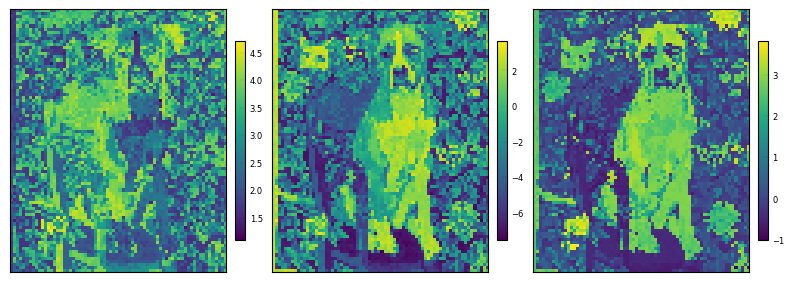

In [25]:
embeddings(encode, shape_=image.shape[0:2], figsize=(10, 5))


- This is clearly an overcomplete example since we are learning 10 timesteps with 12 latent variables


### Generator

- Now we want to see how the spectra changes as we traverse the latent space


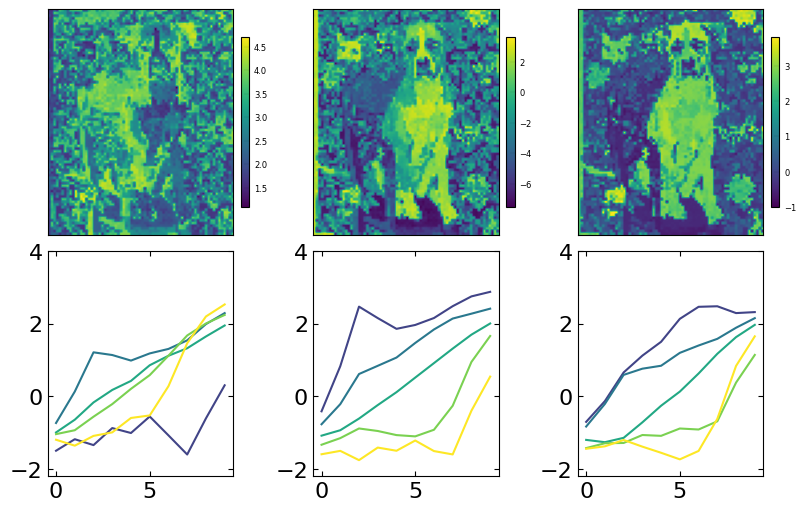

In [26]:
latent_generator(decoder, encode, image, 5, 10, device=device,
                 figsize=(10, 5), divider_=False)


## Recurrent Neural Network Autoencoders


- The above example did not consider the temporal information in the data.


- This can be improved by using a recurrent neural network that processes each time step sequentially.


- To add an understanding about the short and long term information in the data you can add memory and forget logic as a learnable parameter.


![](https://github.com/jagar2/m3_learning/blob/main/m3_learning/Tutorials/Unsupervised_Learning_with_AEs/figs/Autoencoder_Med.png?raw=true)


![](https://github.com/jagar2/m3_learning/blob/main/m3_learning/Tutorials/Unsupervised_Learning_with_AEs/figs/LSTM%20Node.png?raw=true)


### Builds the model


In [27]:
latent_dim = 12

# encoder with LSTM
class Encoder(nn.Module):
    def __init__(self, latent_dim=12):
        self.latent_dim = latent_dim
        super(Encoder, self).__init__()
        self.lstm = nn.LSTM(1, 12, batch_first=True, bidirectional=True)
        self.embedding = nn.Linear(24, self.latent_dim)
        self.relu = nn.ReLU()

    def forward(self, x):
        x, (_, __) = self.lstm(x)
        x = x[:, -1, :]
        x = self.embedding(x)
        return x


class Decoder(nn.Module):
    def __init__(self, latent_dim=12):
        self.latent_dim = latent_dim
        super(Decoder, self).__init__()
        self.lstm = nn.LSTM(self.latent_dim, 12,
                            batch_first=True, bidirectional=True)
        self.tdd = nn.Conv1d(24, 1, 1)

    def forward(self, x):
        x = x[:, :, None]
        x = x.transpose(1, 2)
        x = x.repeat([1, 10, 1])
        x, (_, __) = self.lstm(x)
        x = x.transpose(1, 2)
        x = self.tdd(x)
        x = x.transpose(1, 2)
        return x


In [28]:
encoder = Encoder().to(device)
decoder = Decoder().to(device)
model = Autoencoder(encoder, decoder).to(device)

# optimizer
optimizer = optim.Adam(model.parameters(), lr=3e-5)


### Dataloader


In [29]:
train_iterator = torch.utils.data.DataLoader(
    np.atleast_3d(X_train), batch_size=256, shuffle=False
)


### Training


In [30]:
random_seed(seed=42)
Train(model, encoder, decoder, train_iterator, optimizer, 500, device=device)


100%|██████████| 19/19 [00:06<00:00,  3.01it/s]


Epoch 0, Train Loss: 2.2412
.............................


100%|██████████| 19/19 [00:00<00:00, 86.92it/s]


Epoch 1, Train Loss: 2.2313
.............................


100%|██████████| 19/19 [00:00<00:00, 87.42it/s]


Epoch 2, Train Loss: 2.2214
.............................


100%|██████████| 19/19 [00:00<00:00, 76.59it/s]


Epoch 3, Train Loss: 2.2117
.............................


100%|██████████| 19/19 [00:00<00:00, 76.68it/s]


Epoch 4, Train Loss: 2.2020
.............................


100%|██████████| 19/19 [00:00<00:00, 77.61it/s]


Epoch 5, Train Loss: 2.1923
.............................


100%|██████████| 19/19 [00:00<00:00, 78.84it/s]


Epoch 6, Train Loss: 2.1826
.............................


100%|██████████| 19/19 [00:00<00:00, 71.04it/s]


Epoch 7, Train Loss: 2.1729
.............................


100%|██████████| 19/19 [00:00<00:00, 82.62it/s]


Epoch 8, Train Loss: 2.1631
.............................


100%|██████████| 19/19 [00:00<00:00, 83.58it/s]


Epoch 9, Train Loss: 2.1533
.............................


100%|██████████| 19/19 [00:00<00:00, 86.34it/s]


Epoch 10, Train Loss: 2.1433
.............................


100%|██████████| 19/19 [00:00<00:00, 79.71it/s]


Epoch 11, Train Loss: 2.1333
.............................


100%|██████████| 19/19 [00:00<00:00, 65.94it/s]


Epoch 12, Train Loss: 2.1230
.............................


100%|██████████| 19/19 [00:00<00:00, 74.16it/s]


Epoch 13, Train Loss: 2.1126
.............................


100%|██████████| 19/19 [00:00<00:00, 91.81it/s]


Epoch 14, Train Loss: 2.1019
.............................


100%|██████████| 19/19 [00:00<00:00, 95.72it/s]


Epoch 15, Train Loss: 2.0911
.............................


100%|██████████| 19/19 [00:00<00:00, 90.65it/s]


Epoch 16, Train Loss: 2.0799
.............................


100%|██████████| 19/19 [00:00<00:00, 84.51it/s]


Epoch 17, Train Loss: 2.0686
.............................


100%|██████████| 19/19 [00:00<00:00, 77.94it/s]


Epoch 18, Train Loss: 2.0569
.............................


100%|██████████| 19/19 [00:00<00:00, 84.96it/s]


Epoch 19, Train Loss: 2.0449
.............................


100%|██████████| 19/19 [00:00<00:00, 86.81it/s]


Epoch 20, Train Loss: 2.0326
.............................


100%|██████████| 19/19 [00:00<00:00, 81.55it/s]


Epoch 21, Train Loss: 2.0200
.............................


100%|██████████| 19/19 [00:00<00:00, 103.48it/s]


Epoch 22, Train Loss: 2.0070
.............................


100%|██████████| 19/19 [00:00<00:00, 106.99it/s]


Epoch 23, Train Loss: 1.9937
.............................


100%|██████████| 19/19 [00:00<00:00, 100.75it/s]


Epoch 24, Train Loss: 1.9799
.............................


100%|██████████| 19/19 [00:00<00:00, 94.93it/s]


Epoch 25, Train Loss: 1.9658
.............................


100%|██████████| 19/19 [00:00<00:00, 92.63it/s]


Epoch 26, Train Loss: 1.9512
.............................


100%|██████████| 19/19 [00:00<00:00, 100.12it/s]


Epoch 27, Train Loss: 1.9362
.............................


100%|██████████| 19/19 [00:00<00:00, 95.38it/s]


Epoch 28, Train Loss: 1.9208
.............................


100%|██████████| 19/19 [00:00<00:00, 82.04it/s]


Epoch 29, Train Loss: 1.9050
.............................


100%|██████████| 19/19 [00:00<00:00, 82.77it/s]


Epoch 30, Train Loss: 1.8887
.............................


100%|██████████| 19/19 [00:00<00:00, 80.83it/s]


Epoch 31, Train Loss: 1.8719
.............................


100%|██████████| 19/19 [00:00<00:00, 74.81it/s]


Epoch 32, Train Loss: 1.8548
.............................


100%|██████████| 19/19 [00:00<00:00, 75.34it/s]


Epoch 33, Train Loss: 1.8372
.............................


100%|██████████| 19/19 [00:00<00:00, 73.29it/s]


Epoch 34, Train Loss: 1.8192
.............................


100%|██████████| 19/19 [00:00<00:00, 83.69it/s]


Epoch 35, Train Loss: 1.8008
.............................


100%|██████████| 19/19 [00:00<00:00, 97.84it/s]


Epoch 36, Train Loss: 1.7821
.............................


100%|██████████| 19/19 [00:00<00:00, 102.42it/s]


Epoch 37, Train Loss: 1.7630
.............................


100%|██████████| 19/19 [00:00<00:00, 87.00it/s]


Epoch 38, Train Loss: 1.7436
.............................


100%|██████████| 19/19 [00:00<00:00, 77.42it/s]


Epoch 39, Train Loss: 1.7240
.............................


100%|██████████| 19/19 [00:00<00:00, 92.41it/s]


Epoch 40, Train Loss: 1.7042
.............................


100%|██████████| 19/19 [00:00<00:00, 96.16it/s]


Epoch 41, Train Loss: 1.6842
.............................


100%|██████████| 19/19 [00:00<00:00, 98.20it/s]


Epoch 42, Train Loss: 1.6642
.............................


100%|██████████| 19/19 [00:00<00:00, 100.10it/s]


Epoch 43, Train Loss: 1.6441
.............................


100%|██████████| 19/19 [00:00<00:00, 91.14it/s]


Epoch 44, Train Loss: 1.6241
.............................


100%|██████████| 19/19 [00:00<00:00, 87.38it/s]


Epoch 45, Train Loss: 1.6043
.............................


100%|██████████| 19/19 [00:00<00:00, 110.66it/s]


Epoch 46, Train Loss: 1.5846
.............................


100%|██████████| 19/19 [00:00<00:00, 112.88it/s]


Epoch 47, Train Loss: 1.5652
.............................


100%|██████████| 19/19 [00:00<00:00, 109.69it/s]


Epoch 48, Train Loss: 1.5462
.............................


100%|██████████| 19/19 [00:00<00:00, 95.19it/s]


Epoch 49, Train Loss: 1.5276
.............................


100%|██████████| 19/19 [00:00<00:00, 97.30it/s]


Epoch 50, Train Loss: 1.5093
.............................


100%|██████████| 19/19 [00:00<00:00, 107.35it/s]


Epoch 51, Train Loss: 1.4916
.............................


100%|██████████| 19/19 [00:00<00:00, 93.35it/s]


Epoch 52, Train Loss: 1.4743
.............................


100%|██████████| 19/19 [00:00<00:00, 99.10it/s]


Epoch 53, Train Loss: 1.4574
.............................


100%|██████████| 19/19 [00:00<00:00, 84.66it/s]


Epoch 54, Train Loss: 1.4410
.............................


100%|██████████| 19/19 [00:00<00:00, 86.20it/s]


Epoch 55, Train Loss: 1.4251
.............................


100%|██████████| 19/19 [00:00<00:00, 91.07it/s]


Epoch 56, Train Loss: 1.4096
.............................


100%|██████████| 19/19 [00:00<00:00, 81.94it/s]


Epoch 57, Train Loss: 1.3944
.............................


100%|██████████| 19/19 [00:00<00:00, 79.00it/s]


Epoch 58, Train Loss: 1.3796
.............................


100%|██████████| 19/19 [00:00<00:00, 76.12it/s]


Epoch 59, Train Loss: 1.3650
.............................


100%|██████████| 19/19 [00:00<00:00, 82.94it/s]


Epoch 60, Train Loss: 1.3507
.............................


100%|██████████| 19/19 [00:00<00:00, 83.46it/s]


Epoch 61, Train Loss: 1.3366
.............................


100%|██████████| 19/19 [00:00<00:00, 80.10it/s]


Epoch 62, Train Loss: 1.3226
.............................


100%|██████████| 19/19 [00:00<00:00, 76.21it/s]


Epoch 63, Train Loss: 1.3087
.............................


100%|██████████| 19/19 [00:00<00:00, 83.34it/s]


Epoch 64, Train Loss: 1.2948
.............................


100%|██████████| 19/19 [00:00<00:00, 78.73it/s]


Epoch 65, Train Loss: 1.2810
.............................


100%|██████████| 19/19 [00:00<00:00, 89.66it/s]


Epoch 66, Train Loss: 1.2672
.............................


100%|██████████| 19/19 [00:00<00:00, 87.22it/s]


Epoch 67, Train Loss: 1.2534
.............................


100%|██████████| 19/19 [00:00<00:00, 93.42it/s]


Epoch 68, Train Loss: 1.2395
.............................


100%|██████████| 19/19 [00:00<00:00, 108.78it/s]


Epoch 69, Train Loss: 1.2255
.............................


100%|██████████| 19/19 [00:00<00:00, 100.35it/s]


Epoch 70, Train Loss: 1.2115
.............................


100%|██████████| 19/19 [00:00<00:00, 92.46it/s]


Epoch 71, Train Loss: 1.1974
.............................


100%|██████████| 19/19 [00:00<00:00, 91.19it/s]


Epoch 72, Train Loss: 1.1832
.............................


100%|██████████| 19/19 [00:00<00:00, 83.15it/s]


Epoch 73, Train Loss: 1.1689
.............................


100%|██████████| 19/19 [00:00<00:00, 96.23it/s]


Epoch 74, Train Loss: 1.1546
.............................


100%|██████████| 19/19 [00:00<00:00, 102.92it/s]


Epoch 75, Train Loss: 1.1401
.............................


100%|██████████| 19/19 [00:00<00:00, 95.15it/s]


Epoch 76, Train Loss: 1.1256
.............................


100%|██████████| 19/19 [00:00<00:00, 88.95it/s]


Epoch 77, Train Loss: 1.1109
.............................


100%|██████████| 19/19 [00:00<00:00, 71.12it/s]


Epoch 78, Train Loss: 1.0962
.............................


100%|██████████| 19/19 [00:00<00:00, 84.90it/s]


Epoch 79, Train Loss: 1.0814
.............................


100%|██████████| 19/19 [00:00<00:00, 76.19it/s]


Epoch 80, Train Loss: 1.0666
.............................


100%|██████████| 19/19 [00:00<00:00, 78.78it/s]


Epoch 81, Train Loss: 1.0516
.............................


100%|██████████| 19/19 [00:00<00:00, 95.95it/s]


Epoch 82, Train Loss: 1.0367
.............................


100%|██████████| 19/19 [00:00<00:00, 93.69it/s]


Epoch 83, Train Loss: 1.0217
.............................


100%|██████████| 19/19 [00:00<00:00, 109.22it/s]


Epoch 84, Train Loss: 1.0067
.............................


100%|██████████| 19/19 [00:00<00:00, 96.75it/s]


Epoch 85, Train Loss: 0.9916
.............................


100%|██████████| 19/19 [00:00<00:00, 84.08it/s]


Epoch 86, Train Loss: 0.9766
.............................


100%|██████████| 19/19 [00:00<00:00, 79.68it/s]


Epoch 87, Train Loss: 0.9615
.............................


100%|██████████| 19/19 [00:00<00:00, 88.64it/s]


Epoch 88, Train Loss: 0.9465
.............................


100%|██████████| 19/19 [00:00<00:00, 88.32it/s]


Epoch 89, Train Loss: 0.9314
.............................


100%|██████████| 19/19 [00:00<00:00, 89.25it/s]


Epoch 90, Train Loss: 0.9164
.............................


100%|██████████| 19/19 [00:00<00:00, 78.51it/s]


Epoch 91, Train Loss: 0.9015
.............................


100%|██████████| 19/19 [00:00<00:00, 87.45it/s]


Epoch 92, Train Loss: 0.8866
.............................


100%|██████████| 19/19 [00:00<00:00, 96.11it/s]


Epoch 93, Train Loss: 0.8717
.............................


100%|██████████| 19/19 [00:00<00:00, 103.78it/s]


Epoch 94, Train Loss: 0.8569
.............................


100%|██████████| 19/19 [00:00<00:00, 96.74it/s]


Epoch 95, Train Loss: 0.8422
.............................


100%|██████████| 19/19 [00:00<00:00, 108.60it/s]


Epoch 96, Train Loss: 0.8275
.............................


100%|██████████| 19/19 [00:00<00:00, 115.40it/s]


Epoch 97, Train Loss: 0.8129
.............................


100%|██████████| 19/19 [00:00<00:00, 106.61it/s]


Epoch 98, Train Loss: 0.7984
.............................


100%|██████████| 19/19 [00:00<00:00, 108.01it/s]


Epoch 99, Train Loss: 0.7840
.............................


100%|██████████| 19/19 [00:00<00:00, 100.57it/s]


Epoch 100, Train Loss: 0.7697
.............................


100%|██████████| 19/19 [00:00<00:00, 94.98it/s]


Epoch 101, Train Loss: 0.7555
.............................


100%|██████████| 19/19 [00:00<00:00, 91.11it/s]


Epoch 102, Train Loss: 0.7414
.............................


100%|██████████| 19/19 [00:00<00:00, 92.61it/s]


Epoch 103, Train Loss: 0.7274
.............................


100%|██████████| 19/19 [00:00<00:00, 90.34it/s]


Epoch 104, Train Loss: 0.7135
.............................


100%|██████████| 19/19 [00:00<00:00, 76.08it/s]


Epoch 105, Train Loss: 0.6997
.............................


100%|██████████| 19/19 [00:00<00:00, 93.45it/s]


Epoch 106, Train Loss: 0.6861
.............................


100%|██████████| 19/19 [00:00<00:00, 108.63it/s]


Epoch 107, Train Loss: 0.6726
.............................


100%|██████████| 19/19 [00:00<00:00, 88.12it/s]


Epoch 108, Train Loss: 0.6592
.............................


100%|██████████| 19/19 [00:00<00:00, 84.17it/s]


Epoch 109, Train Loss: 0.6459
.............................


100%|██████████| 19/19 [00:00<00:00, 68.50it/s]


Epoch 110, Train Loss: 0.6328
.............................


100%|██████████| 19/19 [00:00<00:00, 81.10it/s]


Epoch 111, Train Loss: 0.6199
.............................


100%|██████████| 19/19 [00:00<00:00, 81.01it/s]


Epoch 112, Train Loss: 0.6070
.............................


100%|██████████| 19/19 [00:00<00:00, 96.61it/s]


Epoch 113, Train Loss: 0.5944
.............................


100%|██████████| 19/19 [00:00<00:00, 89.71it/s]


Epoch 114, Train Loss: 0.5818
.............................


100%|██████████| 19/19 [00:00<00:00, 101.56it/s]


Epoch 115, Train Loss: 0.5695
.............................


100%|██████████| 19/19 [00:00<00:00, 104.75it/s]


Epoch 116, Train Loss: 0.5573
.............................


100%|██████████| 19/19 [00:00<00:00, 88.64it/s]


Epoch 117, Train Loss: 0.5453
.............................


100%|██████████| 19/19 [00:00<00:00, 99.71it/s]


Epoch 118, Train Loss: 0.5334
.............................


100%|██████████| 19/19 [00:00<00:00, 92.69it/s]


Epoch 119, Train Loss: 0.5218
.............................


100%|██████████| 19/19 [00:00<00:00, 99.57it/s]


Epoch 120, Train Loss: 0.5104
.............................


100%|██████████| 19/19 [00:00<00:00, 102.00it/s]


Epoch 121, Train Loss: 0.4991
.............................


100%|██████████| 19/19 [00:00<00:00, 102.51it/s]


Epoch 122, Train Loss: 0.4881
.............................


100%|██████████| 19/19 [00:00<00:00, 103.81it/s]


Epoch 123, Train Loss: 0.4774
.............................


100%|██████████| 19/19 [00:00<00:00, 88.13it/s]


Epoch 124, Train Loss: 0.4668
.............................


100%|██████████| 19/19 [00:00<00:00, 87.98it/s]


Epoch 125, Train Loss: 0.4566
.............................


100%|██████████| 19/19 [00:00<00:00, 84.95it/s]


Epoch 126, Train Loss: 0.4466
.............................


100%|██████████| 19/19 [00:00<00:00, 79.49it/s]


Epoch 127, Train Loss: 0.4369
.............................


100%|██████████| 19/19 [00:00<00:00, 89.69it/s]


Epoch 128, Train Loss: 0.4274
.............................


100%|██████████| 19/19 [00:00<00:00, 86.84it/s]


Epoch 129, Train Loss: 0.4183
.............................


100%|██████████| 19/19 [00:00<00:00, 83.33it/s]


Epoch 130, Train Loss: 0.4094
.............................


100%|██████████| 19/19 [00:00<00:00, 94.04it/s]


Epoch 131, Train Loss: 0.4008
.............................


100%|██████████| 19/19 [00:00<00:00, 86.34it/s]


Epoch 132, Train Loss: 0.3925
.............................


100%|██████████| 19/19 [00:00<00:00, 78.48it/s]


Epoch 133, Train Loss: 0.3845
.............................


100%|██████████| 19/19 [00:00<00:00, 93.36it/s]


Epoch 134, Train Loss: 0.3767
.............................


100%|██████████| 19/19 [00:00<00:00, 108.22it/s]


Epoch 135, Train Loss: 0.3692
.............................


100%|██████████| 19/19 [00:00<00:00, 105.43it/s]


Epoch 136, Train Loss: 0.3620
.............................


100%|██████████| 19/19 [00:00<00:00, 96.03it/s]


Epoch 137, Train Loss: 0.3550
.............................


100%|██████████| 19/19 [00:00<00:00, 95.20it/s]


Epoch 138, Train Loss: 0.3482
.............................


100%|██████████| 19/19 [00:00<00:00, 87.95it/s]


Epoch 139, Train Loss: 0.3417
.............................


100%|██████████| 19/19 [00:00<00:00, 90.75it/s]


Epoch 140, Train Loss: 0.3354
.............................


100%|██████████| 19/19 [00:00<00:00, 98.34it/s]


Epoch 141, Train Loss: 0.3294
.............................


100%|██████████| 19/19 [00:00<00:00, 86.44it/s]


Epoch 142, Train Loss: 0.3235
.............................


100%|██████████| 19/19 [00:00<00:00, 97.11it/s]


Epoch 143, Train Loss: 0.3179
.............................


100%|██████████| 19/19 [00:00<00:00, 88.51it/s]


Epoch 144, Train Loss: 0.3124
.............................


100%|██████████| 19/19 [00:00<00:00, 103.07it/s]


Epoch 145, Train Loss: 0.3072
.............................


100%|██████████| 19/19 [00:00<00:00, 100.71it/s]


Epoch 146, Train Loss: 0.3021
.............................


100%|██████████| 19/19 [00:00<00:00, 89.38it/s]


Epoch 147, Train Loss: 0.2973
.............................


100%|██████████| 19/19 [00:00<00:00, 94.15it/s]


Epoch 148, Train Loss: 0.2926
.............................


100%|██████████| 19/19 [00:00<00:00, 84.24it/s]


Epoch 149, Train Loss: 0.2880
.............................


100%|██████████| 19/19 [00:00<00:00, 87.37it/s]


Epoch 150, Train Loss: 0.2837
.............................


100%|██████████| 19/19 [00:00<00:00, 81.89it/s]


Epoch 151, Train Loss: 0.2795
.............................


100%|██████████| 19/19 [00:00<00:00, 86.73it/s]


Epoch 152, Train Loss: 0.2754
.............................


100%|██████████| 19/19 [00:00<00:00, 103.71it/s]


Epoch 153, Train Loss: 0.2716
.............................


100%|██████████| 19/19 [00:00<00:00, 101.38it/s]


Epoch 154, Train Loss: 0.2678
.............................


100%|██████████| 19/19 [00:00<00:00, 102.82it/s]


Epoch 155, Train Loss: 0.2642
.............................


100%|██████████| 19/19 [00:00<00:00, 82.79it/s]


Epoch 156, Train Loss: 0.2607
.............................


100%|██████████| 19/19 [00:00<00:00, 74.89it/s]


Epoch 157, Train Loss: 0.2574
.............................


100%|██████████| 19/19 [00:00<00:00, 84.16it/s]


Epoch 158, Train Loss: 0.2542
.............................


100%|██████████| 19/19 [00:00<00:00, 83.55it/s]


Epoch 159, Train Loss: 0.2511
.............................


100%|██████████| 19/19 [00:00<00:00, 84.08it/s]


Epoch 160, Train Loss: 0.2481
.............................


100%|██████████| 19/19 [00:00<00:00, 81.49it/s]


Epoch 161, Train Loss: 0.2453
.............................


100%|██████████| 19/19 [00:00<00:00, 95.27it/s]


Epoch 162, Train Loss: 0.2425
.............................


100%|██████████| 19/19 [00:00<00:00, 99.50it/s] 


Epoch 163, Train Loss: 0.2399
.............................


100%|██████████| 19/19 [00:00<00:00, 103.58it/s]


Epoch 164, Train Loss: 0.2374
.............................


100%|██████████| 19/19 [00:00<00:00, 99.80it/s]


Epoch 165, Train Loss: 0.2349
.............................


100%|██████████| 19/19 [00:00<00:00, 97.62it/s]


Epoch 166, Train Loss: 0.2326
.............................


100%|██████████| 19/19 [00:00<00:00, 101.51it/s]


Epoch 167, Train Loss: 0.2303
.............................


100%|██████████| 19/19 [00:00<00:00, 113.57it/s]


Epoch 168, Train Loss: 0.2281
.............................


100%|██████████| 19/19 [00:00<00:00, 99.51it/s]


Epoch 169, Train Loss: 0.2261
.............................


100%|██████████| 19/19 [00:00<00:00, 96.35it/s]


Epoch 170, Train Loss: 0.2241
.............................


100%|██████████| 19/19 [00:00<00:00, 90.60it/s]


Epoch 171, Train Loss: 0.2221
.............................


100%|██████████| 19/19 [00:00<00:00, 87.30it/s]


Epoch 172, Train Loss: 0.2203
.............................


100%|██████████| 19/19 [00:00<00:00, 88.24it/s]


Epoch 173, Train Loss: 0.2185
.............................


100%|██████████| 19/19 [00:00<00:00, 85.21it/s]


Epoch 174, Train Loss: 0.2167
.............................


100%|██████████| 19/19 [00:00<00:00, 85.35it/s]


Epoch 175, Train Loss: 0.2151
.............................


100%|██████████| 19/19 [00:00<00:00, 88.44it/s]


Epoch 176, Train Loss: 0.2135
.............................


100%|██████████| 19/19 [00:00<00:00, 99.28it/s]


Epoch 177, Train Loss: 0.2119
.............................


100%|██████████| 19/19 [00:00<00:00, 101.63it/s]


Epoch 178, Train Loss: 0.2104
.............................


100%|██████████| 19/19 [00:00<00:00, 107.61it/s]


Epoch 179, Train Loss: 0.2090
.............................


100%|██████████| 19/19 [00:00<00:00, 97.52it/s]


Epoch 180, Train Loss: 0.2076
.............................


100%|██████████| 19/19 [00:00<00:00, 73.93it/s]


Epoch 181, Train Loss: 0.2062
.............................


100%|██████████| 19/19 [00:00<00:00, 90.94it/s]


Epoch 182, Train Loss: 0.2049
.............................


100%|██████████| 19/19 [00:00<00:00, 92.49it/s]


Epoch 183, Train Loss: 0.2036
.............................


100%|██████████| 19/19 [00:00<00:00, 100.26it/s]


Epoch 184, Train Loss: 0.2024
.............................


100%|██████████| 19/19 [00:00<00:00, 102.16it/s]


Epoch 185, Train Loss: 0.2012
.............................


100%|██████████| 19/19 [00:00<00:00, 87.42it/s]


Epoch 186, Train Loss: 0.2000
.............................


100%|██████████| 19/19 [00:00<00:00, 98.11it/s]


Epoch 187, Train Loss: 0.1989
.............................


100%|██████████| 19/19 [00:00<00:00, 102.09it/s]


Epoch 188, Train Loss: 0.1977
.............................


100%|██████████| 19/19 [00:00<00:00, 102.85it/s]


Epoch 189, Train Loss: 0.1967
.............................


100%|██████████| 19/19 [00:00<00:00, 99.84it/s]


Epoch 190, Train Loss: 0.1956
.............................


100%|██████████| 19/19 [00:00<00:00, 97.21it/s]


Epoch 191, Train Loss: 0.1945
.............................


100%|██████████| 19/19 [00:00<00:00, 98.63it/s]


Epoch 192, Train Loss: 0.1935
.............................


100%|██████████| 19/19 [00:00<00:00, 89.89it/s]


Epoch 193, Train Loss: 0.1925
.............................


100%|██████████| 19/19 [00:00<00:00, 98.60it/s] 


Epoch 194, Train Loss: 0.1915
.............................


100%|██████████| 19/19 [00:00<00:00, 90.26it/s]


Epoch 195, Train Loss: 0.1906
.............................


100%|██████████| 19/19 [00:00<00:00, 85.84it/s]


Epoch 196, Train Loss: 0.1897
.............................


100%|██████████| 19/19 [00:00<00:00, 91.87it/s]


Epoch 197, Train Loss: 0.1888
.............................


100%|██████████| 19/19 [00:00<00:00, 86.72it/s]


Epoch 198, Train Loss: 0.1879
.............................


100%|██████████| 19/19 [00:00<00:00, 97.28it/s]


Epoch 199, Train Loss: 0.1871
.............................


100%|██████████| 19/19 [00:00<00:00, 93.19it/s]


Epoch 200, Train Loss: 0.1862
.............................


100%|██████████| 19/19 [00:00<00:00, 91.75it/s]


Epoch 201, Train Loss: 0.1854
.............................


100%|██████████| 19/19 [00:00<00:00, 91.29it/s]


Epoch 202, Train Loss: 0.1847
.............................


100%|██████████| 19/19 [00:00<00:00, 104.15it/s]


Epoch 203, Train Loss: 0.1839
.............................


100%|██████████| 19/19 [00:00<00:00, 100.15it/s]


Epoch 204, Train Loss: 0.1832
.............................


100%|██████████| 19/19 [00:00<00:00, 79.98it/s]


Epoch 205, Train Loss: 0.1825
.............................


100%|██████████| 19/19 [00:00<00:00, 86.42it/s]


Epoch 206, Train Loss: 0.1818
.............................


100%|██████████| 19/19 [00:00<00:00, 73.79it/s]


Epoch 207, Train Loss: 0.1812
.............................


100%|██████████| 19/19 [00:00<00:00, 78.62it/s]


Epoch 208, Train Loss: 0.1805
.............................


100%|██████████| 19/19 [00:00<00:00, 75.40it/s]


Epoch 209, Train Loss: 0.1799
.............................


100%|██████████| 19/19 [00:00<00:00, 65.51it/s]


Epoch 210, Train Loss: 0.1793
.............................


100%|██████████| 19/19 [00:00<00:00, 66.14it/s]


Epoch 211, Train Loss: 0.1787
.............................


100%|██████████| 19/19 [00:00<00:00, 74.41it/s]


Epoch 212, Train Loss: 0.1781
.............................


100%|██████████| 19/19 [00:00<00:00, 87.95it/s]


Epoch 213, Train Loss: 0.1776
.............................


100%|██████████| 19/19 [00:00<00:00, 70.79it/s]


Epoch 214, Train Loss: 0.1771
.............................


100%|██████████| 19/19 [00:00<00:00, 72.84it/s]


Epoch 215, Train Loss: 0.1765
.............................


100%|██████████| 19/19 [00:00<00:00, 84.55it/s]


Epoch 216, Train Loss: 0.1760
.............................


100%|██████████| 19/19 [00:00<00:00, 83.09it/s]


Epoch 217, Train Loss: 0.1755
.............................


100%|██████████| 19/19 [00:00<00:00, 81.33it/s]


Epoch 218, Train Loss: 0.1750
.............................


100%|██████████| 19/19 [00:00<00:00, 81.26it/s]


Epoch 219, Train Loss: 0.1746
.............................


100%|██████████| 19/19 [00:00<00:00, 88.63it/s]


Epoch 220, Train Loss: 0.1741
.............................


100%|██████████| 19/19 [00:00<00:00, 89.54it/s]


Epoch 221, Train Loss: 0.1736
.............................


100%|██████████| 19/19 [00:00<00:00, 96.01it/s]


Epoch 222, Train Loss: 0.1732
.............................


100%|██████████| 19/19 [00:00<00:00, 85.76it/s]


Epoch 223, Train Loss: 0.1728
.............................


100%|██████████| 19/19 [00:00<00:00, 89.91it/s]


Epoch 224, Train Loss: 0.1723
.............................


100%|██████████| 19/19 [00:00<00:00, 90.63it/s]


Epoch 225, Train Loss: 0.1719
.............................


100%|██████████| 19/19 [00:00<00:00, 91.53it/s]


Epoch 226, Train Loss: 0.1715
.............................


100%|██████████| 19/19 [00:00<00:00, 95.50it/s]


Epoch 227, Train Loss: 0.1711
.............................


100%|██████████| 19/19 [00:00<00:00, 97.42it/s]


Epoch 228, Train Loss: 0.1707
.............................


100%|██████████| 19/19 [00:00<00:00, 104.68it/s]


Epoch 229, Train Loss: 0.1704
.............................


100%|██████████| 19/19 [00:00<00:00, 105.36it/s]


Epoch 230, Train Loss: 0.1700
.............................


100%|██████████| 19/19 [00:00<00:00, 109.09it/s]


Epoch 231, Train Loss: 0.1696
.............................


100%|██████████| 19/19 [00:00<00:00, 114.32it/s]


Epoch 232, Train Loss: 0.1692
.............................


100%|██████████| 19/19 [00:00<00:00, 99.79it/s] 


Epoch 233, Train Loss: 0.1689
.............................


100%|██████████| 19/19 [00:00<00:00, 110.49it/s]


Epoch 234, Train Loss: 0.1685
.............................


100%|██████████| 19/19 [00:00<00:00, 106.65it/s]

Epoch 235, Train Loss: 0.1682
.............................



100%|██████████| 19/19 [00:00<00:00, 93.34it/s]


Epoch 236, Train Loss: 0.1678
.............................


100%|██████████| 19/19 [00:00<00:00, 102.14it/s]


Epoch 237, Train Loss: 0.1675
.............................


100%|██████████| 19/19 [00:00<00:00, 96.63it/s] 


Epoch 238, Train Loss: 0.1672
.............................


100%|██████████| 19/19 [00:00<00:00, 98.26it/s]


Epoch 239, Train Loss: 0.1668
.............................


100%|██████████| 19/19 [00:00<00:00, 111.84it/s]


Epoch 240, Train Loss: 0.1665
.............................


100%|██████████| 19/19 [00:00<00:00, 95.75it/s]


Epoch 241, Train Loss: 0.1662
.............................


100%|██████████| 19/19 [00:00<00:00, 89.06it/s]


Epoch 242, Train Loss: 0.1659
.............................


100%|██████████| 19/19 [00:00<00:00, 89.58it/s]


Epoch 243, Train Loss: 0.1655
.............................


100%|██████████| 19/19 [00:00<00:00, 80.77it/s]


Epoch 244, Train Loss: 0.1652
.............................


100%|██████████| 19/19 [00:00<00:00, 92.95it/s]


Epoch 245, Train Loss: 0.1649
.............................


100%|██████████| 19/19 [00:00<00:00, 98.62it/s]


Epoch 246, Train Loss: 0.1646
.............................


100%|██████████| 19/19 [00:00<00:00, 95.67it/s] 


Epoch 247, Train Loss: 0.1643
.............................


100%|██████████| 19/19 [00:00<00:00, 97.01it/s] 


Epoch 248, Train Loss: 0.1640
.............................


100%|██████████| 19/19 [00:00<00:00, 95.76it/s]


Epoch 249, Train Loss: 0.1637
.............................


100%|██████████| 19/19 [00:00<00:00, 91.19it/s]


Epoch 250, Train Loss: 0.1634
.............................


100%|██████████| 19/19 [00:00<00:00, 82.97it/s]


Epoch 251, Train Loss: 0.1631
.............................


100%|██████████| 19/19 [00:00<00:00, 94.93it/s] 


Epoch 252, Train Loss: 0.1628
.............................


100%|██████████| 19/19 [00:00<00:00, 97.05it/s]


Epoch 253, Train Loss: 0.1625
.............................


100%|██████████| 19/19 [00:00<00:00, 95.59it/s]


Epoch 254, Train Loss: 0.1622
.............................


100%|██████████| 19/19 [00:00<00:00, 101.30it/s]


Epoch 255, Train Loss: 0.1619
.............................


100%|██████████| 19/19 [00:00<00:00, 105.09it/s]


Epoch 256, Train Loss: 0.1616
.............................


100%|██████████| 19/19 [00:00<00:00, 107.97it/s]


Epoch 257, Train Loss: 0.1614
.............................


100%|██████████| 19/19 [00:00<00:00, 94.96it/s] 


Epoch 258, Train Loss: 0.1611
.............................


100%|██████████| 19/19 [00:00<00:00, 79.95it/s]


Epoch 259, Train Loss: 0.1608
.............................


100%|██████████| 19/19 [00:00<00:00, 79.45it/s]


Epoch 260, Train Loss: 0.1605
.............................


100%|██████████| 19/19 [00:00<00:00, 91.83it/s]


Epoch 261, Train Loss: 0.1602
.............................


100%|██████████| 19/19 [00:00<00:00, 99.11it/s]


Epoch 262, Train Loss: 0.1599
.............................


100%|██████████| 19/19 [00:00<00:00, 93.73it/s]


Epoch 263, Train Loss: 0.1597
.............................


100%|██████████| 19/19 [00:00<00:00, 100.76it/s]


Epoch 264, Train Loss: 0.1594
.............................


100%|██████████| 19/19 [00:00<00:00, 96.14it/s]


Epoch 265, Train Loss: 0.1591
.............................


100%|██████████| 19/19 [00:00<00:00, 91.31it/s]


Epoch 266, Train Loss: 0.1588
.............................


100%|██████████| 19/19 [00:00<00:00, 85.09it/s]


Epoch 267, Train Loss: 0.1585
.............................


100%|██████████| 19/19 [00:00<00:00, 87.86it/s]


Epoch 268, Train Loss: 0.1583
.............................


100%|██████████| 19/19 [00:00<00:00, 91.24it/s]


Epoch 269, Train Loss: 0.1580
.............................


100%|██████████| 19/19 [00:00<00:00, 89.21it/s]


Epoch 270, Train Loss: 0.1577
.............................


100%|██████████| 19/19 [00:00<00:00, 88.25it/s]


Epoch 271, Train Loss: 0.1574
.............................


100%|██████████| 19/19 [00:00<00:00, 99.40it/s]


Epoch 272, Train Loss: 0.1571
.............................


100%|██████████| 19/19 [00:00<00:00, 83.92it/s]


Epoch 273, Train Loss: 0.1569
.............................


100%|██████████| 19/19 [00:00<00:00, 85.61it/s]


Epoch 274, Train Loss: 0.1566
.............................


100%|██████████| 19/19 [00:00<00:00, 93.46it/s]


Epoch 275, Train Loss: 0.1563
.............................


100%|██████████| 19/19 [00:00<00:00, 97.61it/s] 


Epoch 276, Train Loss: 0.1560
.............................


100%|██████████| 19/19 [00:00<00:00, 97.70it/s]


Epoch 277, Train Loss: 0.1558
.............................


100%|██████████| 19/19 [00:00<00:00, 101.23it/s]


Epoch 278, Train Loss: 0.1555
.............................


100%|██████████| 19/19 [00:00<00:00, 91.63it/s]


Epoch 279, Train Loss: 0.1552
.............................


100%|██████████| 19/19 [00:00<00:00, 101.54it/s]


Epoch 280, Train Loss: 0.1549
.............................


100%|██████████| 19/19 [00:00<00:00, 113.21it/s]


Epoch 281, Train Loss: 0.1547
.............................


100%|██████████| 19/19 [00:00<00:00, 96.36it/s]


Epoch 282, Train Loss: 0.1544
.............................


100%|██████████| 19/19 [00:00<00:00, 92.51it/s]


Epoch 283, Train Loss: 0.1541
.............................


100%|██████████| 19/19 [00:00<00:00, 97.64it/s]


Epoch 284, Train Loss: 0.1538
.............................


100%|██████████| 19/19 [00:00<00:00, 109.75it/s]


Epoch 285, Train Loss: 0.1536
.............................


100%|██████████| 19/19 [00:00<00:00, 105.37it/s]


Epoch 286, Train Loss: 0.1533
.............................


100%|██████████| 19/19 [00:00<00:00, 102.95it/s]


Epoch 287, Train Loss: 0.1530
.............................


100%|██████████| 19/19 [00:00<00:00, 108.56it/s]


Epoch 288, Train Loss: 0.1528
.............................


100%|██████████| 19/19 [00:00<00:00, 86.23it/s]


Epoch 289, Train Loss: 0.1525
.............................


100%|██████████| 19/19 [00:00<00:00, 86.79it/s]


Epoch 290, Train Loss: 0.1522
.............................


100%|██████████| 19/19 [00:00<00:00, 86.78it/s]


Epoch 291, Train Loss: 0.1520
.............................


100%|██████████| 19/19 [00:00<00:00, 82.41it/s]


Epoch 292, Train Loss: 0.1517
.............................


100%|██████████| 19/19 [00:00<00:00, 71.80it/s]


Epoch 293, Train Loss: 0.1514
.............................


100%|██████████| 19/19 [00:00<00:00, 90.76it/s]


Epoch 294, Train Loss: 0.1511
.............................


100%|██████████| 19/19 [00:00<00:00, 102.51it/s]


Epoch 295, Train Loss: 0.1509
.............................


100%|██████████| 19/19 [00:00<00:00, 105.57it/s]


Epoch 296, Train Loss: 0.1506
.............................


100%|██████████| 19/19 [00:00<00:00, 105.69it/s]


Epoch 297, Train Loss: 0.1503
.............................


100%|██████████| 19/19 [00:00<00:00, 93.14it/s] 


Epoch 298, Train Loss: 0.1501
.............................


100%|██████████| 19/19 [00:00<00:00, 95.28it/s]


Epoch 299, Train Loss: 0.1498
.............................


100%|██████████| 19/19 [00:00<00:00, 100.06it/s]


Epoch 300, Train Loss: 0.1496
.............................


100%|██████████| 19/19 [00:00<00:00, 96.88it/s]


Epoch 301, Train Loss: 0.1493
.............................


100%|██████████| 19/19 [00:00<00:00, 98.08it/s] 


Epoch 302, Train Loss: 0.1490
.............................


100%|██████████| 19/19 [00:00<00:00, 102.06it/s]


Epoch 303, Train Loss: 0.1488
.............................


100%|██████████| 19/19 [00:00<00:00, 87.25it/s]


Epoch 304, Train Loss: 0.1485
.............................


100%|██████████| 19/19 [00:00<00:00, 104.30it/s]


Epoch 305, Train Loss: 0.1483
.............................


100%|██████████| 19/19 [00:00<00:00, 104.21it/s]


Epoch 306, Train Loss: 0.1480
.............................


100%|██████████| 19/19 [00:00<00:00, 100.36it/s]


Epoch 307, Train Loss: 0.1477
.............................


100%|██████████| 19/19 [00:00<00:00, 103.60it/s]


Epoch 308, Train Loss: 0.1475
.............................


100%|██████████| 19/19 [00:00<00:00, 97.78it/s]


Epoch 309, Train Loss: 0.1472
.............................


100%|██████████| 19/19 [00:00<00:00, 94.68it/s]


Epoch 310, Train Loss: 0.1470
.............................


100%|██████████| 19/19 [00:00<00:00, 96.25it/s]


Epoch 311, Train Loss: 0.1467
.............................


100%|██████████| 19/19 [00:00<00:00, 92.49it/s]


Epoch 312, Train Loss: 0.1465
.............................


100%|██████████| 19/19 [00:00<00:00, 93.70it/s]


Epoch 313, Train Loss: 0.1462
.............................


100%|██████████| 19/19 [00:00<00:00, 87.89it/s]


Epoch 314, Train Loss: 0.1460
.............................


100%|██████████| 19/19 [00:00<00:00, 78.96it/s]


Epoch 315, Train Loss: 0.1457
.............................


100%|██████████| 19/19 [00:00<00:00, 74.65it/s]


Epoch 316, Train Loss: 0.1455
.............................


100%|██████████| 19/19 [00:00<00:00, 83.60it/s]


Epoch 317, Train Loss: 0.1452
.............................


100%|██████████| 19/19 [00:00<00:00, 83.57it/s]


Epoch 318, Train Loss: 0.1450
.............................


100%|██████████| 19/19 [00:00<00:00, 96.86it/s]


Epoch 319, Train Loss: 0.1447
.............................


100%|██████████| 19/19 [00:00<00:00, 93.57it/s]


Epoch 320, Train Loss: 0.1445
.............................


100%|██████████| 19/19 [00:00<00:00, 88.45it/s]


Epoch 321, Train Loss: 0.1442
.............................


100%|██████████| 19/19 [00:00<00:00, 85.89it/s]


Epoch 322, Train Loss: 0.1440
.............................


100%|██████████| 19/19 [00:00<00:00, 78.20it/s]


Epoch 323, Train Loss: 0.1438
.............................


100%|██████████| 19/19 [00:00<00:00, 92.17it/s]


Epoch 324, Train Loss: 0.1435
.............................


100%|██████████| 19/19 [00:00<00:00, 83.99it/s]


Epoch 325, Train Loss: 0.1433
.............................


100%|██████████| 19/19 [00:00<00:00, 87.49it/s]


Epoch 326, Train Loss: 0.1430
.............................


100%|██████████| 19/19 [00:00<00:00, 96.10it/s]


Epoch 327, Train Loss: 0.1428
.............................


100%|██████████| 19/19 [00:00<00:00, 93.77it/s]


Epoch 328, Train Loss: 0.1426
.............................


100%|██████████| 19/19 [00:00<00:00, 93.36it/s]


Epoch 329, Train Loss: 0.1423
.............................


100%|██████████| 19/19 [00:00<00:00, 85.99it/s]


Epoch 330, Train Loss: 0.1421
.............................


100%|██████████| 19/19 [00:00<00:00, 86.83it/s]


Epoch 331, Train Loss: 0.1419
.............................


100%|██████████| 19/19 [00:00<00:00, 94.59it/s]


Epoch 332, Train Loss: 0.1416
.............................


100%|██████████| 19/19 [00:00<00:00, 99.95it/s]


Epoch 333, Train Loss: 0.1414
.............................


100%|██████████| 19/19 [00:00<00:00, 102.13it/s]


Epoch 334, Train Loss: 0.1412
.............................


100%|██████████| 19/19 [00:00<00:00, 87.24it/s]


Epoch 335, Train Loss: 0.1409
.............................


100%|██████████| 19/19 [00:00<00:00, 91.85it/s]


Epoch 336, Train Loss: 0.1407
.............................


100%|██████████| 19/19 [00:00<00:00, 81.11it/s]


Epoch 337, Train Loss: 0.1405
.............................


100%|██████████| 19/19 [00:00<00:00, 82.38it/s]


Epoch 338, Train Loss: 0.1403
.............................


100%|██████████| 19/19 [00:00<00:00, 79.08it/s]


Epoch 339, Train Loss: 0.1400
.............................


100%|██████████| 19/19 [00:00<00:00, 86.72it/s]


Epoch 340, Train Loss: 0.1398
.............................


100%|██████████| 19/19 [00:00<00:00, 96.10it/s]


Epoch 341, Train Loss: 0.1396
.............................


100%|██████████| 19/19 [00:00<00:00, 92.06it/s]


Epoch 342, Train Loss: 0.1394
.............................


100%|██████████| 19/19 [00:00<00:00, 85.40it/s]


Epoch 343, Train Loss: 0.1392
.............................


100%|██████████| 19/19 [00:00<00:00, 91.93it/s]


Epoch 344, Train Loss: 0.1389
.............................


100%|██████████| 19/19 [00:00<00:00, 90.04it/s]


Epoch 345, Train Loss: 0.1387
.............................


100%|██████████| 19/19 [00:00<00:00, 81.86it/s]


Epoch 346, Train Loss: 0.1385
.............................


100%|██████████| 19/19 [00:00<00:00, 85.09it/s]


Epoch 347, Train Loss: 0.1383
.............................


100%|██████████| 19/19 [00:00<00:00, 95.36it/s]


Epoch 348, Train Loss: 0.1381
.............................


100%|██████████| 19/19 [00:00<00:00, 95.88it/s]


Epoch 349, Train Loss: 0.1379
.............................


100%|██████████| 19/19 [00:00<00:00, 98.77it/s]


Epoch 350, Train Loss: 0.1377
.............................


100%|██████████| 19/19 [00:00<00:00, 103.03it/s]


Epoch 351, Train Loss: 0.1375
.............................


100%|██████████| 19/19 [00:00<00:00, 94.42it/s]


Epoch 352, Train Loss: 0.1372
.............................


100%|██████████| 19/19 [00:00<00:00, 103.34it/s]


Epoch 353, Train Loss: 0.1370
.............................


100%|██████████| 19/19 [00:00<00:00, 106.60it/s]


Epoch 354, Train Loss: 0.1368
.............................


100%|██████████| 19/19 [00:00<00:00, 98.65it/s]


Epoch 355, Train Loss: 0.1366
.............................


100%|██████████| 19/19 [00:00<00:00, 86.68it/s]


Epoch 356, Train Loss: 0.1364
.............................


100%|██████████| 19/19 [00:00<00:00, 85.51it/s]


Epoch 357, Train Loss: 0.1362
.............................


100%|██████████| 19/19 [00:00<00:00, 93.40it/s]


Epoch 358, Train Loss: 0.1360
.............................


100%|██████████| 19/19 [00:00<00:00, 73.88it/s]


Epoch 359, Train Loss: 0.1358
.............................


100%|██████████| 19/19 [00:00<00:00, 66.44it/s]


Epoch 360, Train Loss: 0.1356
.............................


100%|██████████| 19/19 [00:00<00:00, 65.42it/s]


Epoch 361, Train Loss: 0.1354
.............................


100%|██████████| 19/19 [00:00<00:00, 76.36it/s]


Epoch 362, Train Loss: 0.1353
.............................


100%|██████████| 19/19 [00:00<00:00, 83.49it/s]


Epoch 363, Train Loss: 0.1351
.............................


100%|██████████| 19/19 [00:00<00:00, 96.93it/s] 


Epoch 364, Train Loss: 0.1349
.............................


100%|██████████| 19/19 [00:00<00:00, 88.85it/s]


Epoch 365, Train Loss: 0.1347
.............................


100%|██████████| 19/19 [00:00<00:00, 94.09it/s]


Epoch 366, Train Loss: 0.1345
.............................


100%|██████████| 19/19 [00:00<00:00, 97.17it/s]


Epoch 367, Train Loss: 0.1343
.............................


100%|██████████| 19/19 [00:00<00:00, 94.75it/s]


Epoch 368, Train Loss: 0.1341
.............................


100%|██████████| 19/19 [00:00<00:00, 88.89it/s]


Epoch 369, Train Loss: 0.1339
.............................


100%|██████████| 19/19 [00:00<00:00, 87.85it/s]


Epoch 370, Train Loss: 0.1338
.............................


100%|██████████| 19/19 [00:00<00:00, 101.80it/s]


Epoch 371, Train Loss: 0.1336
.............................


100%|██████████| 19/19 [00:00<00:00, 112.25it/s]


Epoch 372, Train Loss: 0.1334
.............................


100%|██████████| 19/19 [00:00<00:00, 110.05it/s]


Epoch 373, Train Loss: 0.1332
.............................


100%|██████████| 19/19 [00:00<00:00, 111.69it/s]


Epoch 374, Train Loss: 0.1331
.............................


100%|██████████| 19/19 [00:00<00:00, 100.45it/s]


Epoch 375, Train Loss: 0.1329
.............................


100%|██████████| 19/19 [00:00<00:00, 97.89it/s]


Epoch 376, Train Loss: 0.1327
.............................


100%|██████████| 19/19 [00:00<00:00, 112.30it/s]


Epoch 377, Train Loss: 0.1325
.............................


100%|██████████| 19/19 [00:00<00:00, 109.16it/s]


Epoch 378, Train Loss: 0.1324
.............................


100%|██████████| 19/19 [00:00<00:00, 114.07it/s]


Epoch 379, Train Loss: 0.1322
.............................


100%|██████████| 19/19 [00:00<00:00, 115.55it/s]


Epoch 380, Train Loss: 0.1320
.............................


100%|██████████| 19/19 [00:00<00:00, 108.88it/s]


Epoch 381, Train Loss: 0.1319
.............................


100%|██████████| 19/19 [00:00<00:00, 110.93it/s]


Epoch 382, Train Loss: 0.1317
.............................


100%|██████████| 19/19 [00:00<00:00, 113.23it/s]


Epoch 383, Train Loss: 0.1315
.............................


100%|██████████| 19/19 [00:00<00:00, 106.96it/s]


Epoch 384, Train Loss: 0.1314
.............................


100%|██████████| 19/19 [00:00<00:00, 98.06it/s]


Epoch 385, Train Loss: 0.1312
.............................


100%|██████████| 19/19 [00:00<00:00, 80.04it/s]


Epoch 386, Train Loss: 0.1310
.............................


100%|██████████| 19/19 [00:00<00:00, 80.85it/s]


Epoch 387, Train Loss: 0.1309
.............................


100%|██████████| 19/19 [00:00<00:00, 93.02it/s]


Epoch 388, Train Loss: 0.1307
.............................


100%|██████████| 19/19 [00:00<00:00, 100.73it/s]


Epoch 389, Train Loss: 0.1306
.............................


100%|██████████| 19/19 [00:00<00:00, 99.82it/s]


Epoch 390, Train Loss: 0.1304
.............................


100%|██████████| 19/19 [00:00<00:00, 99.97it/s] 


Epoch 391, Train Loss: 0.1303
.............................


100%|██████████| 19/19 [00:00<00:00, 87.01it/s]


Epoch 392, Train Loss: 0.1301
.............................


100%|██████████| 19/19 [00:00<00:00, 98.92it/s] 


Epoch 393, Train Loss: 0.1299
.............................


100%|██████████| 19/19 [00:00<00:00, 98.22it/s]


Epoch 394, Train Loss: 0.1298
.............................


100%|██████████| 19/19 [00:00<00:00, 106.07it/s]


Epoch 395, Train Loss: 0.1296
.............................


100%|██████████| 19/19 [00:00<00:00, 86.12it/s]


Epoch 396, Train Loss: 0.1295
.............................


100%|██████████| 19/19 [00:00<00:00, 93.04it/s]


Epoch 397, Train Loss: 0.1293
.............................


100%|██████████| 19/19 [00:00<00:00, 105.45it/s]


Epoch 398, Train Loss: 0.1292
.............................


100%|██████████| 19/19 [00:00<00:00, 113.62it/s]


Epoch 399, Train Loss: 0.1290
.............................


100%|██████████| 19/19 [00:00<00:00, 117.13it/s]


Epoch 400, Train Loss: 0.1289
.............................


100%|██████████| 19/19 [00:00<00:00, 107.11it/s]


Epoch 401, Train Loss: 0.1288
.............................


100%|██████████| 19/19 [00:00<00:00, 119.07it/s]


Epoch 402, Train Loss: 0.1286
.............................


100%|██████████| 19/19 [00:00<00:00, 112.07it/s]


Epoch 403, Train Loss: 0.1285
.............................


100%|██████████| 19/19 [00:00<00:00, 112.69it/s]


Epoch 404, Train Loss: 0.1283
.............................


100%|██████████| 19/19 [00:00<00:00, 116.83it/s]


Epoch 405, Train Loss: 0.1282
.............................


100%|██████████| 19/19 [00:00<00:00, 99.74it/s]


Epoch 406, Train Loss: 0.1280
.............................


100%|██████████| 19/19 [00:00<00:00, 104.67it/s]


Epoch 407, Train Loss: 0.1279
.............................


100%|██████████| 19/19 [00:00<00:00, 112.09it/s]


Epoch 408, Train Loss: 0.1277
.............................


100%|██████████| 19/19 [00:00<00:00, 95.34it/s]


Epoch 409, Train Loss: 0.1276
.............................


100%|██████████| 19/19 [00:00<00:00, 95.90it/s]


Epoch 410, Train Loss: 0.1275
.............................


100%|██████████| 19/19 [00:00<00:00, 93.36it/s]


Epoch 411, Train Loss: 0.1273
.............................


100%|██████████| 19/19 [00:00<00:00, 80.90it/s]


Epoch 412, Train Loss: 0.1272
.............................


100%|██████████| 19/19 [00:00<00:00, 74.25it/s]


Epoch 413, Train Loss: 0.1270
.............................


100%|██████████| 19/19 [00:00<00:00, 80.39it/s]


Epoch 414, Train Loss: 0.1269
.............................


100%|██████████| 19/19 [00:00<00:00, 86.37it/s]


Epoch 415, Train Loss: 0.1268
.............................


100%|██████████| 19/19 [00:00<00:00, 75.26it/s]


Epoch 416, Train Loss: 0.1266
.............................


100%|██████████| 19/19 [00:00<00:00, 88.98it/s]


Epoch 417, Train Loss: 0.1265
.............................


100%|██████████| 19/19 [00:00<00:00, 82.90it/s]


Epoch 418, Train Loss: 0.1264
.............................


100%|██████████| 19/19 [00:00<00:00, 95.26it/s]


Epoch 419, Train Loss: 0.1262
.............................


100%|██████████| 19/19 [00:00<00:00, 95.75it/s]


Epoch 420, Train Loss: 0.1261
.............................


100%|██████████| 19/19 [00:00<00:00, 102.62it/s]


Epoch 421, Train Loss: 0.1260
.............................


100%|██████████| 19/19 [00:00<00:00, 111.98it/s]


Epoch 422, Train Loss: 0.1258
.............................


100%|██████████| 19/19 [00:00<00:00, 104.16it/s]


Epoch 423, Train Loss: 0.1257
.............................


100%|██████████| 19/19 [00:00<00:00, 101.53it/s]


Epoch 424, Train Loss: 0.1256
.............................


100%|██████████| 19/19 [00:00<00:00, 104.51it/s]


Epoch 425, Train Loss: 0.1254
.............................


100%|██████████| 19/19 [00:00<00:00, 95.60it/s]


Epoch 426, Train Loss: 0.1253
.............................


100%|██████████| 19/19 [00:00<00:00, 89.74it/s]


Epoch 427, Train Loss: 0.1251
.............................


100%|██████████| 19/19 [00:00<00:00, 82.10it/s]


Epoch 428, Train Loss: 0.1250
.............................


100%|██████████| 19/19 [00:00<00:00, 94.25it/s]


Epoch 429, Train Loss: 0.1249
.............................


100%|██████████| 19/19 [00:00<00:00, 109.41it/s]


Epoch 430, Train Loss: 0.1248
.............................


100%|██████████| 19/19 [00:00<00:00, 102.92it/s]


Epoch 431, Train Loss: 0.1246
.............................


100%|██████████| 19/19 [00:00<00:00, 95.47it/s]


Epoch 432, Train Loss: 0.1245
.............................


100%|██████████| 19/19 [00:00<00:00, 97.16it/s]


Epoch 433, Train Loss: 0.1244
.............................


100%|██████████| 19/19 [00:00<00:00, 83.42it/s]


Epoch 434, Train Loss: 0.1242
.............................


100%|██████████| 19/19 [00:00<00:00, 90.25it/s]


Epoch 435, Train Loss: 0.1241
.............................


100%|██████████| 19/19 [00:00<00:00, 84.07it/s]


Epoch 436, Train Loss: 0.1240
.............................


100%|██████████| 19/19 [00:00<00:00, 95.69it/s]


Epoch 437, Train Loss: 0.1238
.............................


100%|██████████| 19/19 [00:00<00:00, 93.33it/s]


Epoch 438, Train Loss: 0.1237
.............................


100%|██████████| 19/19 [00:00<00:00, 75.26it/s]


Epoch 439, Train Loss: 0.1236
.............................


100%|██████████| 19/19 [00:00<00:00, 87.73it/s]


Epoch 440, Train Loss: 0.1234
.............................


100%|██████████| 19/19 [00:00<00:00, 92.74it/s]


Epoch 441, Train Loss: 0.1233
.............................


100%|██████████| 19/19 [00:00<00:00, 84.90it/s]


Epoch 442, Train Loss: 0.1232
.............................


100%|██████████| 19/19 [00:00<00:00, 81.01it/s]


Epoch 443, Train Loss: 0.1231
.............................


100%|██████████| 19/19 [00:00<00:00, 94.20it/s]


Epoch 444, Train Loss: 0.1229
.............................


100%|██████████| 19/19 [00:00<00:00, 103.91it/s]


Epoch 445, Train Loss: 0.1228
.............................


100%|██████████| 19/19 [00:00<00:00, 102.49it/s]


Epoch 446, Train Loss: 0.1227
.............................


100%|██████████| 19/19 [00:00<00:00, 112.22it/s]


Epoch 447, Train Loss: 0.1225
.............................


100%|██████████| 19/19 [00:00<00:00, 81.03it/s]


Epoch 448, Train Loss: 0.1224
.............................


100%|██████████| 19/19 [00:00<00:00, 101.47it/s]


Epoch 449, Train Loss: 0.1223
.............................


100%|██████████| 19/19 [00:00<00:00, 109.23it/s]


Epoch 450, Train Loss: 0.1222
.............................


100%|██████████| 19/19 [00:00<00:00, 112.53it/s]


Epoch 451, Train Loss: 0.1220
.............................


100%|██████████| 19/19 [00:00<00:00, 109.12it/s]


Epoch 452, Train Loss: 0.1219
.............................


100%|██████████| 19/19 [00:00<00:00, 119.34it/s]


Epoch 453, Train Loss: 0.1218
.............................


100%|██████████| 19/19 [00:00<00:00, 102.49it/s]


Epoch 454, Train Loss: 0.1216
.............................


100%|██████████| 19/19 [00:00<00:00, 101.70it/s]


Epoch 455, Train Loss: 0.1215
.............................


100%|██████████| 19/19 [00:00<00:00, 113.45it/s]


Epoch 456, Train Loss: 0.1214
.............................


100%|██████████| 19/19 [00:00<00:00, 105.14it/s]


Epoch 457, Train Loss: 0.1213
.............................


100%|██████████| 19/19 [00:00<00:00, 85.31it/s]


Epoch 458, Train Loss: 0.1211
.............................


100%|██████████| 19/19 [00:00<00:00, 80.48it/s]


Epoch 459, Train Loss: 0.1210
.............................


100%|██████████| 19/19 [00:00<00:00, 83.99it/s]


Epoch 460, Train Loss: 0.1209
.............................


100%|██████████| 19/19 [00:00<00:00, 89.65it/s]


Epoch 461, Train Loss: 0.1208
.............................


100%|██████████| 19/19 [00:00<00:00, 97.58it/s]


Epoch 462, Train Loss: 0.1206
.............................


100%|██████████| 19/19 [00:00<00:00, 93.60it/s] 


Epoch 463, Train Loss: 0.1205
.............................


100%|██████████| 19/19 [00:00<00:00, 75.35it/s]


Epoch 464, Train Loss: 0.1204
.............................


100%|██████████| 19/19 [00:00<00:00, 81.70it/s]


Epoch 465, Train Loss: 0.1202
.............................


100%|██████████| 19/19 [00:00<00:00, 93.55it/s]


Epoch 466, Train Loss: 0.1201
.............................


100%|██████████| 19/19 [00:00<00:00, 81.67it/s]


Epoch 467, Train Loss: 0.1200
.............................


100%|██████████| 19/19 [00:00<00:00, 90.16it/s]


Epoch 468, Train Loss: 0.1199
.............................


100%|██████████| 19/19 [00:00<00:00, 73.91it/s]


Epoch 469, Train Loss: 0.1197
.............................


100%|██████████| 19/19 [00:00<00:00, 92.03it/s]


Epoch 470, Train Loss: 0.1196
.............................


100%|██████████| 19/19 [00:00<00:00, 99.62it/s]


Epoch 471, Train Loss: 0.1195
.............................


100%|██████████| 19/19 [00:00<00:00, 105.58it/s]


Epoch 472, Train Loss: 0.1194
.............................


100%|██████████| 19/19 [00:00<00:00, 103.18it/s]


Epoch 473, Train Loss: 0.1192
.............................


100%|██████████| 19/19 [00:00<00:00, 96.41it/s] 


Epoch 474, Train Loss: 0.1191
.............................


100%|██████████| 19/19 [00:00<00:00, 112.17it/s]


Epoch 475, Train Loss: 0.1190
.............................


100%|██████████| 19/19 [00:00<00:00, 111.74it/s]


Epoch 476, Train Loss: 0.1188
.............................


100%|██████████| 19/19 [00:00<00:00, 103.92it/s]


Epoch 477, Train Loss: 0.1187
.............................


100%|██████████| 19/19 [00:00<00:00, 92.61it/s]


Epoch 478, Train Loss: 0.1186
.............................


100%|██████████| 19/19 [00:00<00:00, 96.29it/s]


Epoch 479, Train Loss: 0.1185
.............................


100%|██████████| 19/19 [00:00<00:00, 106.08it/s]


Epoch 480, Train Loss: 0.1183
.............................


100%|██████████| 19/19 [00:00<00:00, 108.00it/s]


Epoch 481, Train Loss: 0.1182
.............................


100%|██████████| 19/19 [00:00<00:00, 103.87it/s]


Epoch 482, Train Loss: 0.1181
.............................


100%|██████████| 19/19 [00:00<00:00, 95.67it/s]


Epoch 483, Train Loss: 0.1180
.............................


100%|██████████| 19/19 [00:00<00:00, 81.62it/s]


Epoch 484, Train Loss: 0.1178
.............................


100%|██████████| 19/19 [00:00<00:00, 89.99it/s]


Epoch 485, Train Loss: 0.1177
.............................


100%|██████████| 19/19 [00:00<00:00, 100.69it/s]


Epoch 486, Train Loss: 0.1176
.............................


100%|██████████| 19/19 [00:00<00:00, 109.27it/s]


Epoch 487, Train Loss: 0.1174
.............................


100%|██████████| 19/19 [00:00<00:00, 83.96it/s]


Epoch 488, Train Loss: 0.1173
.............................


100%|██████████| 19/19 [00:00<00:00, 85.10it/s]


Epoch 489, Train Loss: 0.1172
.............................


100%|██████████| 19/19 [00:00<00:00, 79.96it/s]


Epoch 490, Train Loss: 0.1171
.............................


100%|██████████| 19/19 [00:00<00:00, 86.38it/s]


Epoch 491, Train Loss: 0.1169
.............................


100%|██████████| 19/19 [00:00<00:00, 94.04it/s]


Epoch 492, Train Loss: 0.1168
.............................


100%|██████████| 19/19 [00:00<00:00, 99.99it/s]


Epoch 493, Train Loss: 0.1167
.............................


100%|██████████| 19/19 [00:00<00:00, 92.01it/s]


Epoch 494, Train Loss: 0.1166
.............................


100%|██████████| 19/19 [00:00<00:00, 106.39it/s]


Epoch 495, Train Loss: 0.1164
.............................


100%|██████████| 19/19 [00:00<00:00, 112.77it/s]


Epoch 496, Train Loss: 0.1163
.............................


100%|██████████| 19/19 [00:00<00:00, 111.18it/s]


Epoch 497, Train Loss: 0.1162
.............................


100%|██████████| 19/19 [00:00<00:00, 116.03it/s]


Epoch 498, Train Loss: 0.1160
.............................


100%|██████████| 19/19 [00:00<00:00, 89.21it/s]

Epoch 499, Train Loss: 0.1159
.............................


### Validation


In [31]:
encode, decode = transform_nn(dog_data, encoder, decoder, device=device)


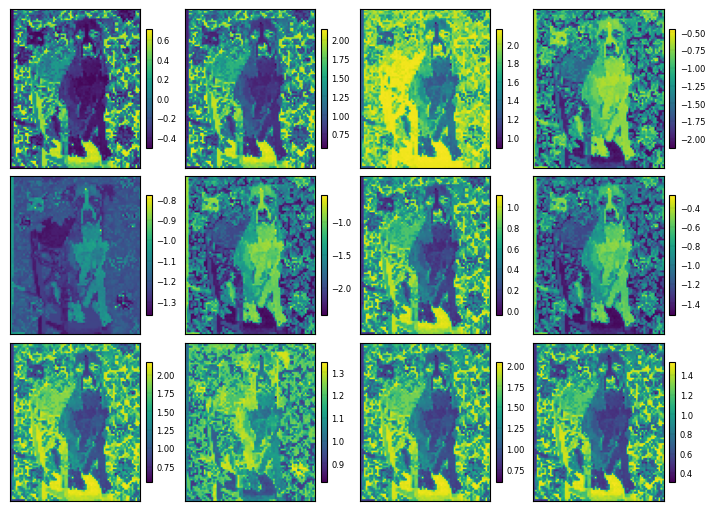

In [32]:
embeddings(encode, shape_=image.shape[0:2], figsize=(15, 5))


- This does not really mean too much because the latent variables are all competing with one another


## LSTM Autoencoder with 3 Latent Variables


In [33]:
encoder = Encoder(latent_dim=3).to(device)
decoder = Decoder(latent_dim=3).to(device)
model = Autoencoder(encoder, decoder).to(device)

# optimizer
optimizer = optim.Adam(model.parameters(), lr=3e-5)


In [34]:
model


Autoencoder(
  (encoder): Encoder(
    (lstm): LSTM(1, 12, batch_first=True, bidirectional=True)
    (embedding): Linear(in_features=24, out_features=3, bias=True)
    (relu): ReLU()
  )
  (decoder): Decoder(
    (lstm): LSTM(3, 12, batch_first=True, bidirectional=True)
    (tdd): Conv1d(24, 1, kernel_size=(1,), stride=(1,))
  )
)

### Dataloader


In [35]:
train_iterator = torch.utils.data.DataLoader(
    np.atleast_3d(X_train), batch_size=256, shuffle=False
)


### Training


In [36]:
random_seed(seed=42)

Train(model, encoder, decoder, train_iterator, optimizer, 500, device=device)


100%|██████████| 19/19 [00:00<00:00, 73.39it/s]


Epoch 0, Train Loss: 2.0366
.............................


100%|██████████| 19/19 [00:00<00:00, 67.55it/s]


Epoch 1, Train Loss: 2.0331
.............................


100%|██████████| 19/19 [00:00<00:00, 83.89it/s]


Epoch 2, Train Loss: 2.0296
.............................


100%|██████████| 19/19 [00:00<00:00, 95.20it/s]


Epoch 3, Train Loss: 2.0262
.............................


100%|██████████| 19/19 [00:00<00:00, 84.50it/s]


Epoch 4, Train Loss: 2.0227
.............................


100%|██████████| 19/19 [00:00<00:00, 99.94it/s]


Epoch 5, Train Loss: 2.0193
.............................


100%|██████████| 19/19 [00:00<00:00, 110.32it/s]


Epoch 6, Train Loss: 2.0158
.............................


100%|██████████| 19/19 [00:00<00:00, 111.92it/s]


Epoch 7, Train Loss: 2.0124
.............................


100%|██████████| 19/19 [00:00<00:00, 107.41it/s]


Epoch 8, Train Loss: 2.0089
.............................


100%|██████████| 19/19 [00:00<00:00, 97.78it/s]


Epoch 9, Train Loss: 2.0054
.............................


100%|██████████| 19/19 [00:00<00:00, 89.62it/s]


Epoch 10, Train Loss: 2.0019
.............................


100%|██████████| 19/19 [00:00<00:00, 83.82it/s]


Epoch 11, Train Loss: 1.9984
.............................


100%|██████████| 19/19 [00:00<00:00, 79.82it/s]


Epoch 12, Train Loss: 1.9948
.............................


100%|██████████| 19/19 [00:00<00:00, 78.82it/s]


Epoch 13, Train Loss: 1.9912
.............................


100%|██████████| 19/19 [00:00<00:00, 80.66it/s]


Epoch 14, Train Loss: 1.9876
.............................


100%|██████████| 19/19 [00:00<00:00, 93.67it/s]


Epoch 15, Train Loss: 1.9839
.............................


100%|██████████| 19/19 [00:00<00:00, 100.75it/s]


Epoch 16, Train Loss: 1.9801
.............................


100%|██████████| 19/19 [00:00<00:00, 106.76it/s]


Epoch 17, Train Loss: 1.9763
.............................


100%|██████████| 19/19 [00:00<00:00, 88.11it/s]


Epoch 18, Train Loss: 1.9725
.............................


100%|██████████| 19/19 [00:00<00:00, 80.96it/s]


Epoch 19, Train Loss: 1.9685
.............................


100%|██████████| 19/19 [00:00<00:00, 90.65it/s]


Epoch 20, Train Loss: 1.9645
.............................


100%|██████████| 19/19 [00:00<00:00, 80.44it/s]


Epoch 21, Train Loss: 1.9604
.............................


100%|██████████| 19/19 [00:00<00:00, 88.88it/s]


Epoch 22, Train Loss: 1.9562
.............................


100%|██████████| 19/19 [00:00<00:00, 88.34it/s]


Epoch 23, Train Loss: 1.9519
.............................


100%|██████████| 19/19 [00:00<00:00, 88.25it/s]


Epoch 24, Train Loss: 1.9476
.............................


100%|██████████| 19/19 [00:00<00:00, 100.35it/s]


Epoch 25, Train Loss: 1.9431
.............................


100%|██████████| 19/19 [00:00<00:00, 90.33it/s]


Epoch 26, Train Loss: 1.9384
.............................


100%|██████████| 19/19 [00:00<00:00, 91.18it/s]


Epoch 27, Train Loss: 1.9337
.............................


100%|██████████| 19/19 [00:00<00:00, 92.83it/s]


Epoch 28, Train Loss: 1.9288
.............................


100%|██████████| 19/19 [00:00<00:00, 99.48it/s]


Epoch 29, Train Loss: 1.9238
.............................


100%|██████████| 19/19 [00:00<00:00, 100.42it/s]


Epoch 30, Train Loss: 1.9186
.............................


100%|██████████| 19/19 [00:00<00:00, 99.00it/s] 


Epoch 31, Train Loss: 1.9133
.............................


100%|██████████| 19/19 [00:00<00:00, 103.88it/s]


Epoch 32, Train Loss: 1.9077
.............................


100%|██████████| 19/19 [00:00<00:00, 91.95it/s]


Epoch 33, Train Loss: 1.9021
.............................


100%|██████████| 19/19 [00:00<00:00, 84.01it/s]


Epoch 34, Train Loss: 1.8962
.............................


100%|██████████| 19/19 [00:00<00:00, 87.99it/s]


Epoch 35, Train Loss: 1.8901
.............................


100%|██████████| 19/19 [00:00<00:00, 84.02it/s]


Epoch 36, Train Loss: 1.8838
.............................


100%|██████████| 19/19 [00:00<00:00, 73.57it/s]


Epoch 37, Train Loss: 1.8773
.............................


100%|██████████| 19/19 [00:00<00:00, 82.57it/s]


Epoch 38, Train Loss: 1.8705
.............................


100%|██████████| 19/19 [00:00<00:00, 90.95it/s]


Epoch 39, Train Loss: 1.8635
.............................


100%|██████████| 19/19 [00:00<00:00, 103.57it/s]


Epoch 40, Train Loss: 1.8563
.............................


100%|██████████| 19/19 [00:00<00:00, 77.69it/s]


Epoch 41, Train Loss: 1.8487
.............................


100%|██████████| 19/19 [00:00<00:00, 76.48it/s]


Epoch 42, Train Loss: 1.8409
.............................


100%|██████████| 19/19 [00:00<00:00, 82.06it/s]


Epoch 43, Train Loss: 1.8328
.............................


100%|██████████| 19/19 [00:00<00:00, 83.26it/s]


Epoch 44, Train Loss: 1.8244
.............................


100%|██████████| 19/19 [00:00<00:00, 76.19it/s]


Epoch 45, Train Loss: 1.8156
.............................


100%|██████████| 19/19 [00:00<00:00, 83.34it/s]


Epoch 46, Train Loss: 1.8065
.............................


100%|██████████| 19/19 [00:00<00:00, 84.53it/s]


Epoch 47, Train Loss: 1.7971
.............................


100%|██████████| 19/19 [00:00<00:00, 99.43it/s]


Epoch 48, Train Loss: 1.7872
.............................


100%|██████████| 19/19 [00:00<00:00, 97.21it/s]


Epoch 49, Train Loss: 1.7770
.............................


100%|██████████| 19/19 [00:00<00:00, 82.86it/s]


Epoch 50, Train Loss: 1.7664
.............................


100%|██████████| 19/19 [00:00<00:00, 93.48it/s]


Epoch 51, Train Loss: 1.7553
.............................


100%|██████████| 19/19 [00:00<00:00, 94.23it/s]


Epoch 52, Train Loss: 1.7437
.............................


100%|██████████| 19/19 [00:00<00:00, 100.98it/s]


Epoch 53, Train Loss: 1.7317
.............................


100%|██████████| 19/19 [00:00<00:00, 99.56it/s] 


Epoch 54, Train Loss: 1.7192
.............................


100%|██████████| 19/19 [00:00<00:00, 99.18it/s] 


Epoch 55, Train Loss: 1.7062
.............................


100%|██████████| 19/19 [00:00<00:00, 86.72it/s]


Epoch 56, Train Loss: 1.6927
.............................


100%|██████████| 19/19 [00:00<00:00, 89.00it/s]


Epoch 57, Train Loss: 1.6786
.............................


100%|██████████| 19/19 [00:00<00:00, 84.63it/s]


Epoch 58, Train Loss: 1.6640
.............................


100%|██████████| 19/19 [00:00<00:00, 86.11it/s]


Epoch 59, Train Loss: 1.6488
.............................


100%|██████████| 19/19 [00:00<00:00, 94.06it/s]


Epoch 60, Train Loss: 1.6331
.............................


100%|██████████| 19/19 [00:00<00:00, 93.73it/s]


Epoch 61, Train Loss: 1.6169
.............................


100%|██████████| 19/19 [00:00<00:00, 101.13it/s]


Epoch 62, Train Loss: 1.6002
.............................


100%|██████████| 19/19 [00:00<00:00, 103.96it/s]


Epoch 63, Train Loss: 1.5830
.............................


100%|██████████| 19/19 [00:00<00:00, 91.60it/s]


Epoch 64, Train Loss: 1.5653
.............................


100%|██████████| 19/19 [00:00<00:00, 95.92it/s]


Epoch 65, Train Loss: 1.5472
.............................


100%|██████████| 19/19 [00:00<00:00, 78.97it/s]


Epoch 66, Train Loss: 1.5287
.............................


100%|██████████| 19/19 [00:00<00:00, 103.21it/s]


Epoch 67, Train Loss: 1.5099
.............................


100%|██████████| 19/19 [00:00<00:00, 99.59it/s]


Epoch 68, Train Loss: 1.4908
.............................


100%|██████████| 19/19 [00:00<00:00, 107.17it/s]


Epoch 69, Train Loss: 1.4715
.............................


100%|██████████| 19/19 [00:00<00:00, 107.85it/s]


Epoch 70, Train Loss: 1.4519
.............................


100%|██████████| 19/19 [00:00<00:00, 109.54it/s]


Epoch 71, Train Loss: 1.4322
.............................


100%|██████████| 19/19 [00:00<00:00, 96.43it/s] 


Epoch 72, Train Loss: 1.4124
.............................


100%|██████████| 19/19 [00:00<00:00, 98.73it/s]


Epoch 73, Train Loss: 1.3925
.............................


100%|██████████| 19/19 [00:00<00:00, 105.62it/s]


Epoch 74, Train Loss: 1.3726
.............................


100%|██████████| 19/19 [00:00<00:00, 115.86it/s]


Epoch 75, Train Loss: 1.3526
.............................


100%|██████████| 19/19 [00:00<00:00, 115.55it/s]


Epoch 76, Train Loss: 1.3327
.............................


100%|██████████| 19/19 [00:00<00:00, 95.47it/s] 


Epoch 77, Train Loss: 1.3128
.............................


100%|██████████| 19/19 [00:00<00:00, 113.42it/s]


Epoch 78, Train Loss: 1.2929
.............................


100%|██████████| 19/19 [00:00<00:00, 116.52it/s]


Epoch 79, Train Loss: 1.2731
.............................


100%|██████████| 19/19 [00:00<00:00, 104.90it/s]


Epoch 80, Train Loss: 1.2534
.............................


100%|██████████| 19/19 [00:00<00:00, 100.88it/s]


Epoch 81, Train Loss: 1.2337
.............................


100%|██████████| 19/19 [00:00<00:00, 92.03it/s]


Epoch 82, Train Loss: 1.2141
.............................


100%|██████████| 19/19 [00:00<00:00, 70.93it/s]


Epoch 83, Train Loss: 1.1946
.............................


100%|██████████| 19/19 [00:00<00:00, 84.01it/s]


Epoch 84, Train Loss: 1.1752
.............................


100%|██████████| 19/19 [00:00<00:00, 90.13it/s]


Epoch 85, Train Loss: 1.1558
.............................


100%|██████████| 19/19 [00:00<00:00, 93.57it/s]


Epoch 86, Train Loss: 1.1365
.............................


100%|██████████| 19/19 [00:00<00:00, 82.62it/s]


Epoch 87, Train Loss: 1.1172
.............................


100%|██████████| 19/19 [00:00<00:00, 86.52it/s]


Epoch 88, Train Loss: 1.0979
.............................


100%|██████████| 19/19 [00:00<00:00, 82.68it/s]


Epoch 89, Train Loss: 1.0786
.............................


100%|██████████| 19/19 [00:00<00:00, 84.49it/s]


Epoch 90, Train Loss: 1.0593
.............................


100%|██████████| 19/19 [00:00<00:00, 90.64it/s]


Epoch 91, Train Loss: 1.0400
.............................


100%|██████████| 19/19 [00:00<00:00, 95.21it/s]


Epoch 92, Train Loss: 1.0206
.............................


100%|██████████| 19/19 [00:00<00:00, 94.52it/s]


Epoch 93, Train Loss: 1.0010
.............................


100%|██████████| 19/19 [00:00<00:00, 107.02it/s]


Epoch 94, Train Loss: 0.9814
.............................


100%|██████████| 19/19 [00:00<00:00, 91.79it/s]


Epoch 95, Train Loss: 0.9616
.............................


100%|██████████| 19/19 [00:00<00:00, 75.33it/s]


Epoch 96, Train Loss: 0.9417
.............................


100%|██████████| 19/19 [00:00<00:00, 83.66it/s]


Epoch 97, Train Loss: 0.9216
.............................


100%|██████████| 19/19 [00:00<00:00, 87.51it/s]


Epoch 98, Train Loss: 0.9012
.............................


100%|██████████| 19/19 [00:00<00:00, 97.32it/s]


Epoch 99, Train Loss: 0.8807
.............................


100%|██████████| 19/19 [00:00<00:00, 103.79it/s]


Epoch 100, Train Loss: 0.8600
.............................


100%|██████████| 19/19 [00:00<00:00, 96.48it/s]


Epoch 101, Train Loss: 0.8391
.............................


100%|██████████| 19/19 [00:00<00:00, 93.27it/s]


Epoch 102, Train Loss: 0.8181
.............................


100%|██████████| 19/19 [00:00<00:00, 95.81it/s]


Epoch 103, Train Loss: 0.7968
.............................


100%|██████████| 19/19 [00:00<00:00, 82.17it/s]


Epoch 104, Train Loss: 0.7754
.............................


100%|██████████| 19/19 [00:00<00:00, 78.11it/s]


Epoch 105, Train Loss: 0.7539
.............................


100%|██████████| 19/19 [00:00<00:00, 73.82it/s]


Epoch 106, Train Loss: 0.7324
.............................


100%|██████████| 19/19 [00:00<00:00, 79.58it/s]


Epoch 107, Train Loss: 0.7108
.............................


100%|██████████| 19/19 [00:00<00:00, 77.67it/s]


Epoch 108, Train Loss: 0.6893
.............................


100%|██████████| 19/19 [00:00<00:00, 94.21it/s]


Epoch 109, Train Loss: 0.6680
.............................


100%|██████████| 19/19 [00:00<00:00, 96.98it/s]


Epoch 110, Train Loss: 0.6468
.............................


100%|██████████| 19/19 [00:00<00:00, 89.38it/s]


Epoch 111, Train Loss: 0.6259
.............................


100%|██████████| 19/19 [00:00<00:00, 84.51it/s]


Epoch 112, Train Loss: 0.6053
.............................


100%|██████████| 19/19 [00:00<00:00, 90.40it/s]


Epoch 113, Train Loss: 0.5853
.............................


100%|██████████| 19/19 [00:00<00:00, 94.22it/s]


Epoch 114, Train Loss: 0.5657
.............................


100%|██████████| 19/19 [00:00<00:00, 100.45it/s]


Epoch 115, Train Loss: 0.5467
.............................


100%|██████████| 19/19 [00:00<00:00, 92.55it/s]


Epoch 116, Train Loss: 0.5284
.............................


100%|██████████| 19/19 [00:00<00:00, 110.94it/s]


Epoch 117, Train Loss: 0.5108
.............................


100%|██████████| 19/19 [00:00<00:00, 113.83it/s]


Epoch 118, Train Loss: 0.4939
.............................


100%|██████████| 19/19 [00:00<00:00, 105.96it/s]


Epoch 119, Train Loss: 0.4779
.............................


100%|██████████| 19/19 [00:00<00:00, 106.99it/s]


Epoch 120, Train Loss: 0.4626
.............................


100%|██████████| 19/19 [00:00<00:00, 91.57it/s]


Epoch 121, Train Loss: 0.4482
.............................


100%|██████████| 19/19 [00:00<00:00, 97.87it/s]


Epoch 122, Train Loss: 0.4346
.............................


100%|██████████| 19/19 [00:00<00:00, 108.61it/s]


Epoch 123, Train Loss: 0.4218
.............................


100%|██████████| 19/19 [00:00<00:00, 108.22it/s]


Epoch 124, Train Loss: 0.4097
.............................


100%|██████████| 19/19 [00:00<00:00, 104.52it/s]


Epoch 125, Train Loss: 0.3984
.............................


100%|██████████| 19/19 [00:00<00:00, 111.99it/s]


Epoch 126, Train Loss: 0.3878
.............................


100%|██████████| 19/19 [00:00<00:00, 98.51it/s]


Epoch 127, Train Loss: 0.3778
.............................


100%|██████████| 19/19 [00:00<00:00, 94.97it/s]


Epoch 128, Train Loss: 0.3685
.............................


100%|██████████| 19/19 [00:00<00:00, 95.92it/s]


Epoch 129, Train Loss: 0.3597
.............................


100%|██████████| 19/19 [00:00<00:00, 76.46it/s]


Epoch 130, Train Loss: 0.3515
.............................


100%|██████████| 19/19 [00:00<00:00, 67.42it/s]


Epoch 131, Train Loss: 0.3438
.............................


100%|██████████| 19/19 [00:00<00:00, 71.17it/s]


Epoch 132, Train Loss: 0.3365
.............................


100%|██████████| 19/19 [00:00<00:00, 78.50it/s]


Epoch 133, Train Loss: 0.3297
.............................


100%|██████████| 19/19 [00:00<00:00, 75.65it/s]


Epoch 134, Train Loss: 0.3232
.............................


100%|██████████| 19/19 [00:00<00:00, 72.95it/s]


Epoch 135, Train Loss: 0.3171
.............................


100%|██████████| 19/19 [00:00<00:00, 74.71it/s]


Epoch 136, Train Loss: 0.3114
.............................


100%|██████████| 19/19 [00:00<00:00, 85.65it/s]


Epoch 137, Train Loss: 0.3060
.............................


100%|██████████| 19/19 [00:00<00:00, 97.44it/s]


Epoch 138, Train Loss: 0.3009
.............................


100%|██████████| 19/19 [00:00<00:00, 91.90it/s]


Epoch 139, Train Loss: 0.2961
.............................


100%|██████████| 19/19 [00:00<00:00, 92.73it/s]


Epoch 140, Train Loss: 0.2915
.............................


100%|██████████| 19/19 [00:00<00:00, 90.52it/s]


Epoch 141, Train Loss: 0.2872
.............................


100%|██████████| 19/19 [00:00<00:00, 101.00it/s]


Epoch 142, Train Loss: 0.2831
.............................


100%|██████████| 19/19 [00:00<00:00, 99.53it/s]


Epoch 143, Train Loss: 0.2792
.............................


100%|██████████| 19/19 [00:00<00:00, 90.02it/s]


Epoch 144, Train Loss: 0.2756
.............................


100%|██████████| 19/19 [00:00<00:00, 85.33it/s]


Epoch 145, Train Loss: 0.2721
.............................


100%|██████████| 19/19 [00:00<00:00, 97.54it/s]


Epoch 146, Train Loss: 0.2688
.............................


100%|██████████| 19/19 [00:00<00:00, 102.30it/s]


Epoch 147, Train Loss: 0.2657
.............................


100%|██████████| 19/19 [00:00<00:00, 88.82it/s]


Epoch 148, Train Loss: 0.2628
.............................


100%|██████████| 19/19 [00:00<00:00, 91.03it/s]


Epoch 149, Train Loss: 0.2600
.............................


100%|██████████| 19/19 [00:00<00:00, 82.79it/s]


Epoch 150, Train Loss: 0.2574
.............................


100%|██████████| 19/19 [00:00<00:00, 81.35it/s]


Epoch 151, Train Loss: 0.2549
.............................


100%|██████████| 19/19 [00:00<00:00, 73.96it/s]


Epoch 152, Train Loss: 0.2525
.............................


100%|██████████| 19/19 [00:00<00:00, 83.33it/s]


Epoch 153, Train Loss: 0.2502
.............................


100%|██████████| 19/19 [00:00<00:00, 85.67it/s]


Epoch 154, Train Loss: 0.2481
.............................


100%|██████████| 19/19 [00:00<00:00, 95.51it/s]


Epoch 155, Train Loss: 0.2461
.............................


100%|██████████| 19/19 [00:00<00:00, 105.10it/s]


Epoch 156, Train Loss: 0.2441
.............................


100%|██████████| 19/19 [00:00<00:00, 98.01it/s]


Epoch 157, Train Loss: 0.2423
.............................


100%|██████████| 19/19 [00:00<00:00, 91.72it/s]


Epoch 158, Train Loss: 0.2405
.............................


100%|██████████| 19/19 [00:00<00:00, 64.53it/s]


Epoch 159, Train Loss: 0.2389
.............................


100%|██████████| 19/19 [00:00<00:00, 65.34it/s]


Epoch 160, Train Loss: 0.2373
.............................


100%|██████████| 19/19 [00:00<00:00, 67.82it/s]


Epoch 161, Train Loss: 0.2358
.............................


100%|██████████| 19/19 [00:00<00:00, 69.78it/s]


Epoch 162, Train Loss: 0.2343
.............................


100%|██████████| 19/19 [00:00<00:00, 65.19it/s]


Epoch 163, Train Loss: 0.2329
.............................


100%|██████████| 19/19 [00:00<00:00, 66.37it/s]


Epoch 164, Train Loss: 0.2316
.............................


100%|██████████| 19/19 [00:00<00:00, 65.17it/s]


Epoch 165, Train Loss: 0.2303
.............................


100%|██████████| 19/19 [00:00<00:00, 66.28it/s]


Epoch 166, Train Loss: 0.2291
.............................


100%|██████████| 19/19 [00:00<00:00, 70.81it/s]


Epoch 167, Train Loss: 0.2280
.............................


100%|██████████| 19/19 [00:00<00:00, 88.48it/s]


Epoch 168, Train Loss: 0.2269
.............................


100%|██████████| 19/19 [00:00<00:00, 89.08it/s]


Epoch 169, Train Loss: 0.2258
.............................


100%|██████████| 19/19 [00:00<00:00, 86.23it/s]


Epoch 170, Train Loss: 0.2248
.............................


100%|██████████| 19/19 [00:00<00:00, 66.18it/s]


Epoch 171, Train Loss: 0.2238
.............................


100%|██████████| 19/19 [00:00<00:00, 76.72it/s]


Epoch 172, Train Loss: 0.2228
.............................


100%|██████████| 19/19 [00:00<00:00, 73.92it/s]


Epoch 173, Train Loss: 0.2219
.............................


100%|██████████| 19/19 [00:00<00:00, 84.51it/s]


Epoch 174, Train Loss: 0.2210
.............................


100%|██████████| 19/19 [00:00<00:00, 89.32it/s]


Epoch 175, Train Loss: 0.2201
.............................


100%|██████████| 19/19 [00:00<00:00, 96.61it/s]


Epoch 176, Train Loss: 0.2193
.............................


100%|██████████| 19/19 [00:00<00:00, 96.83it/s]


Epoch 177, Train Loss: 0.2185
.............................


100%|██████████| 19/19 [00:00<00:00, 88.24it/s]


Epoch 178, Train Loss: 0.2177
.............................


100%|██████████| 19/19 [00:00<00:00, 87.56it/s]


Epoch 179, Train Loss: 0.2169
.............................


100%|██████████| 19/19 [00:00<00:00, 93.71it/s]


Epoch 180, Train Loss: 0.2162
.............................


100%|██████████| 19/19 [00:00<00:00, 94.23it/s]


Epoch 181, Train Loss: 0.2155
.............................


100%|██████████| 19/19 [00:00<00:00, 101.15it/s]


Epoch 182, Train Loss: 0.2147
.............................


100%|██████████| 19/19 [00:00<00:00, 87.89it/s]


Epoch 183, Train Loss: 0.2140
.............................


100%|██████████| 19/19 [00:00<00:00, 95.25it/s]


Epoch 184, Train Loss: 0.2134
.............................


100%|██████████| 19/19 [00:00<00:00, 87.21it/s]


Epoch 185, Train Loss: 0.2127
.............................


100%|██████████| 19/19 [00:00<00:00, 92.46it/s]


Epoch 186, Train Loss: 0.2120
.............................


100%|██████████| 19/19 [00:00<00:00, 83.39it/s]


Epoch 187, Train Loss: 0.2114
.............................


100%|██████████| 19/19 [00:00<00:00, 91.26it/s]


Epoch 188, Train Loss: 0.2108
.............................


100%|██████████| 19/19 [00:00<00:00, 77.13it/s]


Epoch 189, Train Loss: 0.2101
.............................


100%|██████████| 19/19 [00:00<00:00, 78.47it/s]


Epoch 190, Train Loss: 0.2095
.............................


100%|██████████| 19/19 [00:00<00:00, 74.00it/s]


Epoch 191, Train Loss: 0.2089
.............................


100%|██████████| 19/19 [00:00<00:00, 59.32it/s]


Epoch 192, Train Loss: 0.2083
.............................


100%|██████████| 19/19 [00:00<00:00, 56.26it/s]


Epoch 193, Train Loss: 0.2078
.............................


100%|██████████| 19/19 [00:00<00:00, 50.25it/s]


Epoch 194, Train Loss: 0.2072
.............................


100%|██████████| 19/19 [00:00<00:00, 71.18it/s]


Epoch 195, Train Loss: 0.2066
.............................


100%|██████████| 19/19 [00:00<00:00, 69.78it/s]


Epoch 196, Train Loss: 0.2061
.............................


100%|██████████| 19/19 [00:00<00:00, 76.46it/s]


Epoch 197, Train Loss: 0.2055
.............................


100%|██████████| 19/19 [00:00<00:00, 77.11it/s]


Epoch 198, Train Loss: 0.2049
.............................


100%|██████████| 19/19 [00:00<00:00, 72.14it/s]


Epoch 199, Train Loss: 0.2044
.............................


100%|██████████| 19/19 [00:00<00:00, 76.70it/s]


Epoch 200, Train Loss: 0.2039
.............................


100%|██████████| 19/19 [00:00<00:00, 76.44it/s]


Epoch 201, Train Loss: 0.2033
.............................


100%|██████████| 19/19 [00:00<00:00, 87.12it/s]


Epoch 202, Train Loss: 0.2028
.............................


100%|██████████| 19/19 [00:00<00:00, 94.29it/s]


Epoch 203, Train Loss: 0.2023
.............................


100%|██████████| 19/19 [00:00<00:00, 100.06it/s]


Epoch 204, Train Loss: 0.2018
.............................


100%|██████████| 19/19 [00:00<00:00, 82.58it/s]


Epoch 205, Train Loss: 0.2013
.............................


100%|██████████| 19/19 [00:00<00:00, 84.10it/s]


Epoch 206, Train Loss: 0.2008
.............................


100%|██████████| 19/19 [00:00<00:00, 101.40it/s]


Epoch 207, Train Loss: 0.2002
.............................


100%|██████████| 19/19 [00:00<00:00, 106.09it/s]


Epoch 208, Train Loss: 0.1998
.............................


100%|██████████| 19/19 [00:00<00:00, 106.46it/s]


Epoch 209, Train Loss: 0.1993
.............................


100%|██████████| 19/19 [00:00<00:00, 98.52it/s]


Epoch 210, Train Loss: 0.1988
.............................


100%|██████████| 19/19 [00:00<00:00, 87.23it/s]


Epoch 211, Train Loss: 0.1983
.............................


100%|██████████| 19/19 [00:00<00:00, 80.06it/s]


Epoch 212, Train Loss: 0.1978
.............................


100%|██████████| 19/19 [00:00<00:00, 85.27it/s]


Epoch 213, Train Loss: 0.1973
.............................


100%|██████████| 19/19 [00:00<00:00, 78.21it/s]


Epoch 214, Train Loss: 0.1968
.............................


100%|██████████| 19/19 [00:00<00:00, 77.63it/s]


Epoch 215, Train Loss: 0.1964
.............................


100%|██████████| 19/19 [00:00<00:00, 84.89it/s]


Epoch 216, Train Loss: 0.1959
.............................


100%|██████████| 19/19 [00:00<00:00, 81.51it/s]


Epoch 217, Train Loss: 0.1955
.............................


100%|██████████| 19/19 [00:00<00:00, 91.05it/s]


Epoch 218, Train Loss: 0.1950
.............................


100%|██████████| 19/19 [00:00<00:00, 85.14it/s]


Epoch 219, Train Loss: 0.1945
.............................


100%|██████████| 19/19 [00:00<00:00, 76.27it/s]


Epoch 220, Train Loss: 0.1941
.............................


100%|██████████| 19/19 [00:00<00:00, 83.12it/s]


Epoch 221, Train Loss: 0.1936
.............................


100%|██████████| 19/19 [00:00<00:00, 96.25it/s]


Epoch 222, Train Loss: 0.1932
.............................


100%|██████████| 19/19 [00:00<00:00, 97.69it/s]


Epoch 223, Train Loss: 0.1928
.............................


100%|██████████| 19/19 [00:00<00:00, 87.70it/s]


Epoch 224, Train Loss: 0.1923
.............................


100%|██████████| 19/19 [00:00<00:00, 89.97it/s]


Epoch 225, Train Loss: 0.1919
.............................


100%|██████████| 19/19 [00:00<00:00, 97.73it/s]


Epoch 226, Train Loss: 0.1915
.............................


100%|██████████| 19/19 [00:00<00:00, 103.50it/s]


Epoch 227, Train Loss: 0.1910
.............................


100%|██████████| 19/19 [00:00<00:00, 92.98it/s]


Epoch 228, Train Loss: 0.1906
.............................


100%|██████████| 19/19 [00:00<00:00, 78.96it/s]


Epoch 229, Train Loss: 0.1902
.............................


100%|██████████| 19/19 [00:00<00:00, 91.32it/s]


Epoch 230, Train Loss: 0.1898
.............................


100%|██████████| 19/19 [00:00<00:00, 95.11it/s]


Epoch 231, Train Loss: 0.1894
.............................


100%|██████████| 19/19 [00:00<00:00, 98.62it/s]


Epoch 232, Train Loss: 0.1889
.............................


100%|██████████| 19/19 [00:00<00:00, 93.49it/s] 


Epoch 233, Train Loss: 0.1885
.............................


100%|██████████| 19/19 [00:00<00:00, 77.69it/s]


Epoch 234, Train Loss: 0.1881
.............................


100%|██████████| 19/19 [00:00<00:00, 70.54it/s]


Epoch 235, Train Loss: 0.1877
.............................


100%|██████████| 19/19 [00:00<00:00, 73.18it/s]


Epoch 236, Train Loss: 0.1873
.............................


100%|██████████| 19/19 [00:00<00:00, 77.55it/s]


Epoch 237, Train Loss: 0.1869
.............................


100%|██████████| 19/19 [00:00<00:00, 73.94it/s]


Epoch 238, Train Loss: 0.1865
.............................


100%|██████████| 19/19 [00:00<00:00, 88.20it/s]


Epoch 239, Train Loss: 0.1861
.............................


100%|██████████| 19/19 [00:00<00:00, 93.47it/s]


Epoch 240, Train Loss: 0.1858
.............................


100%|██████████| 19/19 [00:00<00:00, 94.28it/s] 


Epoch 241, Train Loss: 0.1854
.............................


100%|██████████| 19/19 [00:00<00:00, 78.66it/s]


Epoch 242, Train Loss: 0.1850
.............................


100%|██████████| 19/19 [00:00<00:00, 70.90it/s]


Epoch 243, Train Loss: 0.1846
.............................


100%|██████████| 19/19 [00:00<00:00, 84.63it/s]


Epoch 244, Train Loss: 0.1842
.............................


100%|██████████| 19/19 [00:00<00:00, 95.27it/s]


Epoch 245, Train Loss: 0.1838
.............................


100%|██████████| 19/19 [00:00<00:00, 84.27it/s]


Epoch 246, Train Loss: 0.1835
.............................


100%|██████████| 19/19 [00:00<00:00, 90.65it/s]


Epoch 247, Train Loss: 0.1831
.............................


100%|██████████| 19/19 [00:00<00:00, 97.01it/s]


Epoch 248, Train Loss: 0.1827
.............................


100%|██████████| 19/19 [00:00<00:00, 104.98it/s]


Epoch 249, Train Loss: 0.1823
.............................


100%|██████████| 19/19 [00:00<00:00, 103.55it/s]


Epoch 250, Train Loss: 0.1820
.............................


100%|██████████| 19/19 [00:00<00:00, 93.73it/s]


Epoch 251, Train Loss: 0.1816
.............................


100%|██████████| 19/19 [00:00<00:00, 95.77it/s]


Epoch 252, Train Loss: 0.1812
.............................


100%|██████████| 19/19 [00:00<00:00, 95.71it/s]


Epoch 253, Train Loss: 0.1809
.............................


100%|██████████| 19/19 [00:00<00:00, 100.83it/s]


Epoch 254, Train Loss: 0.1805
.............................


100%|██████████| 19/19 [00:00<00:00, 107.83it/s]


Epoch 255, Train Loss: 0.1802
.............................


100%|██████████| 19/19 [00:00<00:00, 90.74it/s]


Epoch 256, Train Loss: 0.1798
.............................


100%|██████████| 19/19 [00:00<00:00, 78.47it/s]


Epoch 257, Train Loss: 0.1794
.............................


100%|██████████| 19/19 [00:00<00:00, 81.44it/s]


Epoch 258, Train Loss: 0.1791
.............................


100%|██████████| 19/19 [00:00<00:00, 81.82it/s]


Epoch 259, Train Loss: 0.1787
.............................


100%|██████████| 19/19 [00:00<00:00, 82.91it/s]


Epoch 260, Train Loss: 0.1784
.............................


100%|██████████| 19/19 [00:00<00:00, 80.69it/s]


Epoch 261, Train Loss: 0.1780
.............................


100%|██████████| 19/19 [00:00<00:00, 78.03it/s]


Epoch 262, Train Loss: 0.1777
.............................


100%|██████████| 19/19 [00:00<00:00, 82.27it/s]


Epoch 263, Train Loss: 0.1773
.............................


100%|██████████| 19/19 [00:00<00:00, 82.29it/s]


Epoch 264, Train Loss: 0.1770
.............................


100%|██████████| 19/19 [00:00<00:00, 74.51it/s]


Epoch 265, Train Loss: 0.1766
.............................


100%|██████████| 19/19 [00:00<00:00, 82.44it/s]


Epoch 266, Train Loss: 0.1763
.............................


100%|██████████| 19/19 [00:00<00:00, 82.71it/s]


Epoch 267, Train Loss: 0.1759
.............................


100%|██████████| 19/19 [00:00<00:00, 95.89it/s]


Epoch 268, Train Loss: 0.1756
.............................


100%|██████████| 19/19 [00:00<00:00, 90.49it/s]


Epoch 269, Train Loss: 0.1752
.............................


100%|██████████| 19/19 [00:00<00:00, 89.38it/s]


Epoch 270, Train Loss: 0.1749
.............................


100%|██████████| 19/19 [00:00<00:00, 91.77it/s]


Epoch 271, Train Loss: 0.1746
.............................


100%|██████████| 19/19 [00:00<00:00, 102.88it/s]


Epoch 272, Train Loss: 0.1742
.............................


100%|██████████| 19/19 [00:00<00:00, 99.91it/s] 


Epoch 273, Train Loss: 0.1739
.............................


100%|██████████| 19/19 [00:00<00:00, 98.80it/s] 


Epoch 274, Train Loss: 0.1735
.............................


100%|██████████| 19/19 [00:00<00:00, 88.09it/s]


Epoch 275, Train Loss: 0.1732
.............................


100%|██████████| 19/19 [00:00<00:00, 87.94it/s]


Epoch 276, Train Loss: 0.1729
.............................


100%|██████████| 19/19 [00:00<00:00, 100.88it/s]


Epoch 277, Train Loss: 0.1725
.............................


100%|██████████| 19/19 [00:00<00:00, 90.89it/s]


Epoch 278, Train Loss: 0.1722
.............................


100%|██████████| 19/19 [00:00<00:00, 77.59it/s]


Epoch 279, Train Loss: 0.1719
.............................


100%|██████████| 19/19 [00:00<00:00, 72.91it/s]


Epoch 280, Train Loss: 0.1715
.............................


100%|██████████| 19/19 [00:00<00:00, 71.31it/s]


Epoch 281, Train Loss: 0.1712
.............................


100%|██████████| 19/19 [00:00<00:00, 69.02it/s]


Epoch 282, Train Loss: 0.1709
.............................


100%|██████████| 19/19 [00:00<00:00, 79.69it/s]


Epoch 283, Train Loss: 0.1705
.............................


100%|██████████| 19/19 [00:00<00:00, 78.99it/s]


Epoch 284, Train Loss: 0.1702
.............................


100%|██████████| 19/19 [00:00<00:00, 94.62it/s]


Epoch 285, Train Loss: 0.1699
.............................


100%|██████████| 19/19 [00:00<00:00, 87.72it/s]


Epoch 286, Train Loss: 0.1695
.............................


100%|██████████| 19/19 [00:00<00:00, 79.50it/s]


Epoch 287, Train Loss: 0.1692
.............................


100%|██████████| 19/19 [00:00<00:00, 63.98it/s]


Epoch 288, Train Loss: 0.1689
.............................


100%|██████████| 19/19 [00:00<00:00, 81.46it/s]


Epoch 289, Train Loss: 0.1686
.............................


100%|██████████| 19/19 [00:00<00:00, 93.13it/s]


Epoch 290, Train Loss: 0.1682
.............................


100%|██████████| 19/19 [00:00<00:00, 92.41it/s]


Epoch 291, Train Loss: 0.1679
.............................


100%|██████████| 19/19 [00:00<00:00, 94.22it/s]


Epoch 292, Train Loss: 0.1676
.............................


100%|██████████| 19/19 [00:00<00:00, 99.72it/s]


Epoch 293, Train Loss: 0.1673
.............................


100%|██████████| 19/19 [00:00<00:00, 99.01it/s] 


Epoch 294, Train Loss: 0.1670
.............................


100%|██████████| 19/19 [00:00<00:00, 98.86it/s]


Epoch 295, Train Loss: 0.1667
.............................


100%|██████████| 19/19 [00:00<00:00, 85.12it/s]


Epoch 296, Train Loss: 0.1663
.............................


100%|██████████| 19/19 [00:00<00:00, 82.47it/s]


Epoch 297, Train Loss: 0.1660
.............................


100%|██████████| 19/19 [00:00<00:00, 77.21it/s]


Epoch 298, Train Loss: 0.1657
.............................


100%|██████████| 19/19 [00:00<00:00, 61.43it/s]


Epoch 299, Train Loss: 0.1654
.............................


100%|██████████| 19/19 [00:00<00:00, 52.46it/s]


Epoch 300, Train Loss: 0.1651
.............................


100%|██████████| 19/19 [00:00<00:00, 52.84it/s]


Epoch 301, Train Loss: 0.1648
.............................


100%|██████████| 19/19 [00:00<00:00, 60.84it/s]


Epoch 302, Train Loss: 0.1645
.............................


100%|██████████| 19/19 [00:00<00:00, 71.57it/s]


Epoch 303, Train Loss: 0.1642
.............................


100%|██████████| 19/19 [00:00<00:00, 73.56it/s]


Epoch 304, Train Loss: 0.1639
.............................


100%|██████████| 19/19 [00:00<00:00, 77.50it/s]


Epoch 305, Train Loss: 0.1636
.............................


100%|██████████| 19/19 [00:00<00:00, 88.44it/s]


Epoch 306, Train Loss: 0.1633
.............................


100%|██████████| 19/19 [00:00<00:00, 80.05it/s]


Epoch 307, Train Loss: 0.1630
.............................


100%|██████████| 19/19 [00:00<00:00, 73.04it/s]


Epoch 308, Train Loss: 0.1627
.............................


100%|██████████| 19/19 [00:00<00:00, 65.43it/s]


Epoch 309, Train Loss: 0.1624
.............................


100%|██████████| 19/19 [00:00<00:00, 82.15it/s]


Epoch 310, Train Loss: 0.1621
.............................


100%|██████████| 19/19 [00:00<00:00, 82.91it/s]


Epoch 311, Train Loss: 0.1618
.............................


100%|██████████| 19/19 [00:00<00:00, 96.12it/s]


Epoch 312, Train Loss: 0.1616
.............................


100%|██████████| 19/19 [00:00<00:00, 89.97it/s]


Epoch 313, Train Loss: 0.1613
.............................


100%|██████████| 19/19 [00:00<00:00, 96.34it/s]


Epoch 314, Train Loss: 0.1610
.............................


100%|██████████| 19/19 [00:00<00:00, 101.59it/s]


Epoch 315, Train Loss: 0.1607
.............................


100%|██████████| 19/19 [00:00<00:00, 96.84it/s]


Epoch 316, Train Loss: 0.1604
.............................


100%|██████████| 19/19 [00:00<00:00, 97.84it/s]


Epoch 317, Train Loss: 0.1602
.............................


100%|██████████| 19/19 [00:00<00:00, 100.54it/s]


Epoch 318, Train Loss: 0.1599
.............................


100%|██████████| 19/19 [00:00<00:00, 83.22it/s]


Epoch 319, Train Loss: 0.1596
.............................


100%|██████████| 19/19 [00:00<00:00, 76.33it/s]


Epoch 320, Train Loss: 0.1593
.............................


100%|██████████| 19/19 [00:00<00:00, 71.56it/s]


Epoch 321, Train Loss: 0.1591
.............................


100%|██████████| 19/19 [00:00<00:00, 72.74it/s]


Epoch 322, Train Loss: 0.1588
.............................


100%|██████████| 19/19 [00:00<00:00, 81.63it/s]


Epoch 323, Train Loss: 0.1585
.............................


100%|██████████| 19/19 [00:00<00:00, 83.55it/s]


Epoch 324, Train Loss: 0.1583
.............................


100%|██████████| 19/19 [00:00<00:00, 80.54it/s]


Epoch 325, Train Loss: 0.1580
.............................


100%|██████████| 19/19 [00:00<00:00, 78.09it/s]


Epoch 326, Train Loss: 0.1578
.............................


100%|██████████| 19/19 [00:00<00:00, 71.05it/s]


Epoch 327, Train Loss: 0.1575
.............................


100%|██████████| 19/19 [00:00<00:00, 64.19it/s]


Epoch 328, Train Loss: 0.1573
.............................


100%|██████████| 19/19 [00:00<00:00, 76.91it/s]


Epoch 329, Train Loss: 0.1570
.............................


100%|██████████| 19/19 [00:00<00:00, 91.46it/s]


Epoch 330, Train Loss: 0.1568
.............................


100%|██████████| 19/19 [00:00<00:00, 86.83it/s]


Epoch 331, Train Loss: 0.1565
.............................


100%|██████████| 19/19 [00:00<00:00, 91.70it/s]


Epoch 332, Train Loss: 0.1563
.............................


100%|██████████| 19/19 [00:00<00:00, 93.35it/s]


Epoch 333, Train Loss: 0.1561
.............................


100%|██████████| 19/19 [00:00<00:00, 101.95it/s]


Epoch 334, Train Loss: 0.1558
.............................


100%|██████████| 19/19 [00:00<00:00, 105.95it/s]


Epoch 335, Train Loss: 0.1556
.............................


100%|██████████| 19/19 [00:00<00:00, 94.90it/s]


Epoch 336, Train Loss: 0.1554
.............................


100%|██████████| 19/19 [00:00<00:00, 95.16it/s]


Epoch 337, Train Loss: 0.1551
.............................


100%|██████████| 19/19 [00:00<00:00, 83.60it/s]


Epoch 338, Train Loss: 0.1549
.............................


100%|██████████| 19/19 [00:00<00:00, 95.52it/s]


Epoch 339, Train Loss: 0.1547
.............................


100%|██████████| 19/19 [00:00<00:00, 99.57it/s] 


Epoch 340, Train Loss: 0.1544
.............................


100%|██████████| 19/19 [00:00<00:00, 84.30it/s]


Epoch 341, Train Loss: 0.1542
.............................


100%|██████████| 19/19 [00:00<00:00, 75.05it/s]


Epoch 342, Train Loss: 0.1540
.............................


100%|██████████| 19/19 [00:00<00:00, 79.95it/s]


Epoch 343, Train Loss: 0.1538
.............................


100%|██████████| 19/19 [00:00<00:00, 77.85it/s]


Epoch 344, Train Loss: 0.1536
.............................


100%|██████████| 19/19 [00:00<00:00, 78.59it/s]


Epoch 345, Train Loss: 0.1534
.............................


100%|██████████| 19/19 [00:00<00:00, 87.34it/s]


Epoch 346, Train Loss: 0.1532
.............................


100%|██████████| 19/19 [00:00<00:00, 92.85it/s]


Epoch 347, Train Loss: 0.1530
.............................


100%|██████████| 19/19 [00:00<00:00, 83.60it/s]


Epoch 348, Train Loss: 0.1528
.............................


100%|██████████| 19/19 [00:00<00:00, 88.33it/s]


Epoch 349, Train Loss: 0.1525
.............................


100%|██████████| 19/19 [00:00<00:00, 76.16it/s]


Epoch 350, Train Loss: 0.1523
.............................


100%|██████████| 19/19 [00:00<00:00, 85.18it/s]


Epoch 351, Train Loss: 0.1522
.............................


100%|██████████| 19/19 [00:00<00:00, 84.72it/s]


Epoch 352, Train Loss: 0.1520
.............................


100%|██████████| 19/19 [00:00<00:00, 84.26it/s]


Epoch 353, Train Loss: 0.1518
.............................


100%|██████████| 19/19 [00:00<00:00, 81.20it/s]


Epoch 354, Train Loss: 0.1516
.............................


100%|██████████| 19/19 [00:00<00:00, 91.10it/s]


Epoch 355, Train Loss: 0.1514
.............................


100%|██████████| 19/19 [00:00<00:00, 91.70it/s]


Epoch 356, Train Loss: 0.1512
.............................


100%|██████████| 19/19 [00:00<00:00, 100.41it/s]


Epoch 357, Train Loss: 0.1510
.............................


100%|██████████| 19/19 [00:00<00:00, 90.67it/s]


Epoch 358, Train Loss: 0.1508
.............................


100%|██████████| 19/19 [00:00<00:00, 81.53it/s]


Epoch 359, Train Loss: 0.1506
.............................


100%|██████████| 19/19 [00:00<00:00, 97.86it/s]


Epoch 360, Train Loss: 0.1505
.............................


100%|██████████| 19/19 [00:00<00:00, 94.98it/s]


Epoch 361, Train Loss: 0.1503
.............................


100%|██████████| 19/19 [00:00<00:00, 100.09it/s]


Epoch 362, Train Loss: 0.1501
.............................


100%|██████████| 19/19 [00:00<00:00, 96.56it/s]


Epoch 363, Train Loss: 0.1499
.............................


100%|██████████| 19/19 [00:00<00:00, 78.14it/s]


Epoch 364, Train Loss: 0.1498
.............................


100%|██████████| 19/19 [00:00<00:00, 73.74it/s]


Epoch 365, Train Loss: 0.1496
.............................


100%|██████████| 19/19 [00:00<00:00, 77.65it/s]


Epoch 366, Train Loss: 0.1494
.............................


100%|██████████| 19/19 [00:00<00:00, 85.07it/s]


Epoch 367, Train Loss: 0.1492
.............................


100%|██████████| 19/19 [00:00<00:00, 72.38it/s]


Epoch 368, Train Loss: 0.1491
.............................


100%|██████████| 19/19 [00:00<00:00, 84.23it/s]


Epoch 369, Train Loss: 0.1489
.............................


100%|██████████| 19/19 [00:00<00:00, 89.13it/s]


Epoch 370, Train Loss: 0.1487
.............................


100%|██████████| 19/19 [00:00<00:00, 65.28it/s]


Epoch 371, Train Loss: 0.1486
.............................


100%|██████████| 19/19 [00:00<00:00, 57.90it/s]


Epoch 372, Train Loss: 0.1484
.............................


100%|██████████| 19/19 [00:00<00:00, 75.79it/s]


Epoch 373, Train Loss: 0.1483
.............................


100%|██████████| 19/19 [00:00<00:00, 83.07it/s]


Epoch 374, Train Loss: 0.1481
.............................


100%|██████████| 19/19 [00:00<00:00, 88.49it/s]


Epoch 375, Train Loss: 0.1479
.............................


100%|██████████| 19/19 [00:00<00:00, 86.51it/s]


Epoch 376, Train Loss: 0.1478
.............................


100%|██████████| 19/19 [00:00<00:00, 85.40it/s]


Epoch 377, Train Loss: 0.1476
.............................


100%|██████████| 19/19 [00:00<00:00, 79.23it/s]


Epoch 378, Train Loss: 0.1475
.............................


100%|██████████| 19/19 [00:00<00:00, 93.36it/s]


Epoch 379, Train Loss: 0.1473
.............................


100%|██████████| 19/19 [00:00<00:00, 96.46it/s]


Epoch 380, Train Loss: 0.1472
.............................


100%|██████████| 19/19 [00:00<00:00, 88.84it/s]


Epoch 381, Train Loss: 0.1470
.............................


100%|██████████| 19/19 [00:00<00:00, 98.86it/s]


Epoch 382, Train Loss: 0.1469
.............................


100%|██████████| 19/19 [00:00<00:00, 99.22it/s] 


Epoch 383, Train Loss: 0.1467
.............................


100%|██████████| 19/19 [00:00<00:00, 91.85it/s]


Epoch 384, Train Loss: 0.1466
.............................


100%|██████████| 19/19 [00:00<00:00, 82.91it/s]


Epoch 385, Train Loss: 0.1464
.............................


100%|██████████| 19/19 [00:00<00:00, 69.17it/s]


Epoch 386, Train Loss: 0.1463
.............................


100%|██████████| 19/19 [00:00<00:00, 73.75it/s]


Epoch 387, Train Loss: 0.1461
.............................


100%|██████████| 19/19 [00:00<00:00, 65.17it/s]


Epoch 388, Train Loss: 0.1460
.............................


100%|██████████| 19/19 [00:00<00:00, 68.28it/s]


Epoch 389, Train Loss: 0.1459
.............................


100%|██████████| 19/19 [00:00<00:00, 76.30it/s]


Epoch 390, Train Loss: 0.1457
.............................


100%|██████████| 19/19 [00:00<00:00, 71.48it/s]


Epoch 391, Train Loss: 0.1456
.............................


100%|██████████| 19/19 [00:00<00:00, 68.79it/s]


Epoch 392, Train Loss: 0.1454
.............................


100%|██████████| 19/19 [00:00<00:00, 62.58it/s]


Epoch 393, Train Loss: 0.1453
.............................


100%|██████████| 19/19 [00:00<00:00, 70.10it/s]


Epoch 394, Train Loss: 0.1452
.............................


100%|██████████| 19/19 [00:00<00:00, 82.90it/s]


Epoch 395, Train Loss: 0.1450
.............................


100%|██████████| 19/19 [00:00<00:00, 87.00it/s]


Epoch 396, Train Loss: 0.1449
.............................


100%|██████████| 19/19 [00:00<00:00, 69.41it/s]


Epoch 397, Train Loss: 0.1447
.............................


100%|██████████| 19/19 [00:00<00:00, 88.45it/s]


Epoch 398, Train Loss: 0.1446
.............................


100%|██████████| 19/19 [00:00<00:00, 96.87it/s]


Epoch 399, Train Loss: 0.1445
.............................


100%|██████████| 19/19 [00:00<00:00, 96.09it/s]


Epoch 400, Train Loss: 0.1443
.............................


100%|██████████| 19/19 [00:00<00:00, 77.34it/s]


Epoch 401, Train Loss: 0.1442
.............................


100%|██████████| 19/19 [00:00<00:00, 89.53it/s]


Epoch 402, Train Loss: 0.1441
.............................


100%|██████████| 19/19 [00:00<00:00, 83.54it/s]


Epoch 403, Train Loss: 0.1439
.............................


100%|██████████| 19/19 [00:00<00:00, 83.30it/s]


Epoch 404, Train Loss: 0.1438
.............................


100%|██████████| 19/19 [00:00<00:00, 77.39it/s]


Epoch 405, Train Loss: 0.1437
.............................


100%|██████████| 19/19 [00:00<00:00, 69.86it/s]


Epoch 406, Train Loss: 0.1435
.............................


100%|██████████| 19/19 [00:00<00:00, 72.82it/s]


Epoch 407, Train Loss: 0.1434
.............................


100%|██████████| 19/19 [00:00<00:00, 86.68it/s]


Epoch 408, Train Loss: 0.1433
.............................


100%|██████████| 19/19 [00:00<00:00, 85.57it/s]


Epoch 409, Train Loss: 0.1432
.............................


100%|██████████| 19/19 [00:00<00:00, 94.64it/s]


Epoch 410, Train Loss: 0.1430
.............................


100%|██████████| 19/19 [00:00<00:00, 83.48it/s]


Epoch 411, Train Loss: 0.1429
.............................


100%|██████████| 19/19 [00:00<00:00, 81.29it/s]


Epoch 412, Train Loss: 0.1428
.............................


100%|██████████| 19/19 [00:00<00:00, 74.01it/s]


Epoch 413, Train Loss: 0.1426
.............................


100%|██████████| 19/19 [00:00<00:00, 82.51it/s]


Epoch 414, Train Loss: 0.1425
.............................


100%|██████████| 19/19 [00:00<00:00, 67.14it/s]


Epoch 415, Train Loss: 0.1424
.............................


100%|██████████| 19/19 [00:00<00:00, 72.41it/s]


Epoch 416, Train Loss: 0.1423
.............................


100%|██████████| 19/19 [00:00<00:00, 72.58it/s]


Epoch 417, Train Loss: 0.1421
.............................


100%|██████████| 19/19 [00:00<00:00, 81.10it/s]


Epoch 418, Train Loss: 0.1420
.............................


100%|██████████| 19/19 [00:00<00:00, 80.49it/s]


Epoch 419, Train Loss: 0.1419
.............................


100%|██████████| 19/19 [00:00<00:00, 79.05it/s]


Epoch 420, Train Loss: 0.1418
.............................


100%|██████████| 19/19 [00:00<00:00, 93.36it/s]


Epoch 421, Train Loss: 0.1417
.............................


100%|██████████| 19/19 [00:00<00:00, 89.76it/s]


Epoch 422, Train Loss: 0.1415
.............................


100%|██████████| 19/19 [00:00<00:00, 83.68it/s]


Epoch 423, Train Loss: 0.1414
.............................


100%|██████████| 19/19 [00:00<00:00, 73.69it/s]


Epoch 424, Train Loss: 0.1413
.............................


100%|██████████| 19/19 [00:00<00:00, 73.58it/s]


Epoch 425, Train Loss: 0.1412
.............................


100%|██████████| 19/19 [00:00<00:00, 72.09it/s]


Epoch 426, Train Loss: 0.1410
.............................


100%|██████████| 19/19 [00:00<00:00, 54.30it/s]


Epoch 427, Train Loss: 0.1409
.............................


100%|██████████| 19/19 [00:00<00:00, 66.73it/s]


Epoch 428, Train Loss: 0.1408
.............................


100%|██████████| 19/19 [00:00<00:00, 74.15it/s]


Epoch 429, Train Loss: 0.1407
.............................


100%|██████████| 19/19 [00:00<00:00, 79.90it/s]


Epoch 430, Train Loss: 0.1406
.............................


100%|██████████| 19/19 [00:00<00:00, 70.10it/s]


Epoch 431, Train Loss: 0.1404
.............................


100%|██████████| 19/19 [00:00<00:00, 77.63it/s]


Epoch 432, Train Loss: 0.1403
.............................


100%|██████████| 19/19 [00:00<00:00, 65.27it/s]


Epoch 433, Train Loss: 0.1402
.............................


100%|██████████| 19/19 [00:00<00:00, 78.00it/s]


Epoch 434, Train Loss: 0.1401
.............................


100%|██████████| 19/19 [00:00<00:00, 79.40it/s]


Epoch 435, Train Loss: 0.1400
.............................


100%|██████████| 19/19 [00:00<00:00, 88.41it/s]


Epoch 436, Train Loss: 0.1399
.............................


100%|██████████| 19/19 [00:00<00:00, 86.06it/s]


Epoch 437, Train Loss: 0.1397
.............................


100%|██████████| 19/19 [00:00<00:00, 83.78it/s]


Epoch 438, Train Loss: 0.1396
.............................


100%|██████████| 19/19 [00:00<00:00, 94.76it/s]


Epoch 439, Train Loss: 0.1395
.............................


100%|██████████| 19/19 [00:00<00:00, 88.99it/s]


Epoch 440, Train Loss: 0.1394
.............................


100%|██████████| 19/19 [00:00<00:00, 76.05it/s]


Epoch 441, Train Loss: 0.1393
.............................


100%|██████████| 19/19 [00:00<00:00, 79.43it/s]


Epoch 442, Train Loss: 0.1392
.............................


100%|██████████| 19/19 [00:00<00:00, 70.81it/s]


Epoch 443, Train Loss: 0.1390
.............................


100%|██████████| 19/19 [00:00<00:00, 70.51it/s]


Epoch 444, Train Loss: 0.1389
.............................


100%|██████████| 19/19 [00:00<00:00, 66.03it/s]


Epoch 445, Train Loss: 0.1388
.............................


100%|██████████| 19/19 [00:00<00:00, 70.11it/s]


Epoch 446, Train Loss: 0.1387
.............................


100%|██████████| 19/19 [00:00<00:00, 74.67it/s]


Epoch 447, Train Loss: 0.1386
.............................


100%|██████████| 19/19 [00:00<00:00, 79.06it/s]


Epoch 448, Train Loss: 0.1385
.............................


100%|██████████| 19/19 [00:00<00:00, 86.77it/s]


Epoch 449, Train Loss: 0.1383
.............................


100%|██████████| 19/19 [00:00<00:00, 94.43it/s]


Epoch 450, Train Loss: 0.1382
.............................


100%|██████████| 19/19 [00:00<00:00, 91.03it/s]


Epoch 451, Train Loss: 0.1381
.............................


100%|██████████| 19/19 [00:00<00:00, 63.73it/s]


Epoch 452, Train Loss: 0.1380
.............................


100%|██████████| 19/19 [00:00<00:00, 68.92it/s]


Epoch 453, Train Loss: 0.1379
.............................


100%|██████████| 19/19 [00:00<00:00, 80.50it/s]


Epoch 454, Train Loss: 0.1378
.............................


100%|██████████| 19/19 [00:00<00:00, 88.40it/s]


Epoch 455, Train Loss: 0.1377
.............................


100%|██████████| 19/19 [00:00<00:00, 89.94it/s]


Epoch 456, Train Loss: 0.1376
.............................


100%|██████████| 19/19 [00:00<00:00, 81.42it/s]


Epoch 457, Train Loss: 0.1374
.............................


100%|██████████| 19/19 [00:00<00:00, 76.29it/s]


Epoch 458, Train Loss: 0.1373
.............................


100%|██████████| 19/19 [00:00<00:00, 81.50it/s]


Epoch 459, Train Loss: 0.1372
.............................


100%|██████████| 19/19 [00:00<00:00, 81.35it/s]


Epoch 460, Train Loss: 0.1371
.............................


100%|██████████| 19/19 [00:00<00:00, 72.09it/s]


Epoch 461, Train Loss: 0.1370
.............................


100%|██████████| 19/19 [00:00<00:00, 83.20it/s]


Epoch 462, Train Loss: 0.1369
.............................


100%|██████████| 19/19 [00:00<00:00, 83.39it/s]


Epoch 463, Train Loss: 0.1368
.............................


100%|██████████| 19/19 [00:00<00:00, 71.28it/s]


Epoch 464, Train Loss: 0.1367
.............................


100%|██████████| 19/19 [00:00<00:00, 66.89it/s]


Epoch 465, Train Loss: 0.1365
.............................


100%|██████████| 19/19 [00:00<00:00, 69.30it/s]


Epoch 466, Train Loss: 0.1364
.............................


100%|██████████| 19/19 [00:00<00:00, 76.62it/s]


Epoch 467, Train Loss: 0.1363
.............................


100%|██████████| 19/19 [00:00<00:00, 75.44it/s]


Epoch 468, Train Loss: 0.1362
.............................


100%|██████████| 19/19 [00:00<00:00, 68.54it/s]


Epoch 469, Train Loss: 0.1361
.............................


100%|██████████| 19/19 [00:00<00:00, 79.33it/s]


Epoch 470, Train Loss: 0.1360
.............................


100%|██████████| 19/19 [00:00<00:00, 73.11it/s]


Epoch 471, Train Loss: 0.1359
.............................


100%|██████████| 19/19 [00:00<00:00, 67.30it/s]


Epoch 472, Train Loss: 0.1358
.............................


100%|██████████| 19/19 [00:00<00:00, 58.08it/s]


Epoch 473, Train Loss: 0.1357
.............................


100%|██████████| 19/19 [00:00<00:00, 71.69it/s]


Epoch 474, Train Loss: 0.1356
.............................


100%|██████████| 19/19 [00:00<00:00, 77.33it/s]


Epoch 475, Train Loss: 0.1354
.............................


100%|██████████| 19/19 [00:00<00:00, 79.78it/s]


Epoch 476, Train Loss: 0.1353
.............................


100%|██████████| 19/19 [00:00<00:00, 85.74it/s]


Epoch 477, Train Loss: 0.1352
.............................


100%|██████████| 19/19 [00:00<00:00, 94.70it/s]


Epoch 478, Train Loss: 0.1351
.............................


100%|██████████| 19/19 [00:00<00:00, 97.41it/s]


Epoch 479, Train Loss: 0.1350
.............................


100%|██████████| 19/19 [00:00<00:00, 93.85it/s]


Epoch 480, Train Loss: 0.1349
.............................


100%|██████████| 19/19 [00:00<00:00, 84.79it/s]


Epoch 481, Train Loss: 0.1348
.............................


100%|██████████| 19/19 [00:00<00:00, 84.98it/s]


Epoch 482, Train Loss: 0.1347
.............................


100%|██████████| 19/19 [00:00<00:00, 69.88it/s]


Epoch 483, Train Loss: 0.1346
.............................


100%|██████████| 19/19 [00:00<00:00, 68.71it/s]


Epoch 484, Train Loss: 0.1345
.............................


100%|██████████| 19/19 [00:00<00:00, 66.41it/s]


Epoch 485, Train Loss: 0.1344
.............................


100%|██████████| 19/19 [00:00<00:00, 71.15it/s]


Epoch 486, Train Loss: 0.1343
.............................


100%|██████████| 19/19 [00:00<00:00, 83.82it/s]


Epoch 487, Train Loss: 0.1342
.............................


100%|██████████| 19/19 [00:00<00:00, 84.38it/s]


Epoch 488, Train Loss: 0.1340
.............................


100%|██████████| 19/19 [00:00<00:00, 74.93it/s]


Epoch 489, Train Loss: 0.1339
.............................


100%|██████████| 19/19 [00:00<00:00, 86.46it/s]


Epoch 490, Train Loss: 0.1338
.............................


100%|██████████| 19/19 [00:00<00:00, 65.40it/s]


Epoch 491, Train Loss: 0.1337
.............................


100%|██████████| 19/19 [00:00<00:00, 72.38it/s]


Epoch 492, Train Loss: 0.1336
.............................


100%|██████████| 19/19 [00:00<00:00, 71.39it/s]


Epoch 493, Train Loss: 0.1335
.............................


100%|██████████| 19/19 [00:00<00:00, 84.56it/s]


Epoch 494, Train Loss: 0.1334
.............................


100%|██████████| 19/19 [00:00<00:00, 90.19it/s]


Epoch 495, Train Loss: 0.1333
.............................


100%|██████████| 19/19 [00:00<00:00, 97.47it/s]


Epoch 496, Train Loss: 0.1332
.............................


100%|██████████| 19/19 [00:00<00:00, 90.51it/s]


Epoch 497, Train Loss: 0.1331
.............................


100%|██████████| 19/19 [00:00<00:00, 71.16it/s]


Epoch 498, Train Loss: 0.1330
.............................


100%|██████████| 19/19 [00:00<00:00, 64.60it/s]

Epoch 499, Train Loss: 0.1329
.............................


### Validation


In [37]:
encode, decode = transform_nn(dog_data, encoder, decoder, device=device)


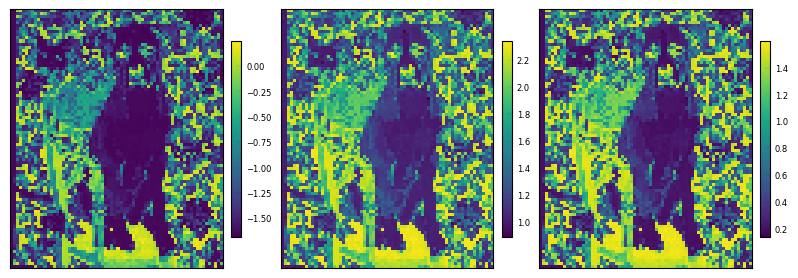

In [38]:
embeddings(encode, shape_=image.shape[0:2], figsize=(10, 5))


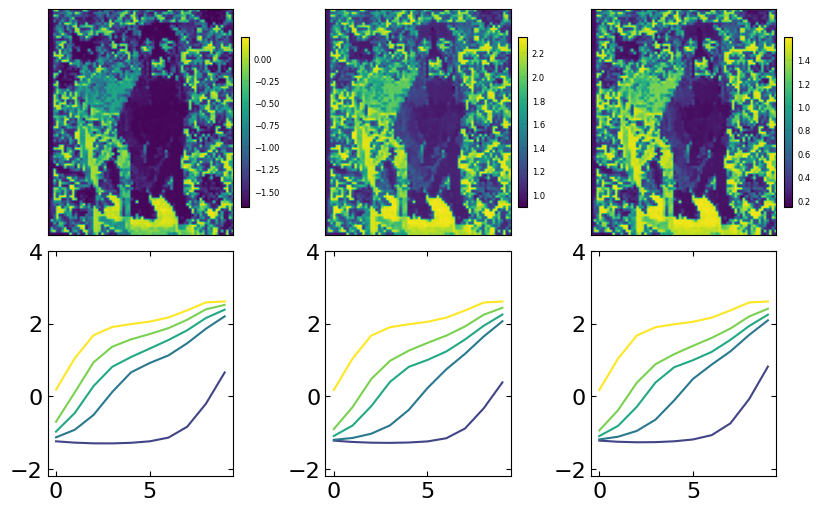

In [39]:
latent_generator(decoder, encode, image, 5, 10, device=device,
                 figsize=(10, 5), divider_=False)


- This once again is very hard to interpret and the spectra do not really contain the necessary details


## Disentanglement

### Regularization

![](https://github.com/jagar2/m3_learning/blob/main/m3_learning/Tutorials/Unsupervised_Learning_with_AEs/figs/L1_reg.png?raw=true)


### Builds the Model


In [40]:
latent_dim = 12


class Encoder(nn.Module):
    def __init__(self, latent_dim=12):
        self.latent_dim = latent_dim
        super(Encoder, self).__init__()
        self.lstm = nn.LSTM(1, 12, batch_first=True, bidirectional=True)
        self.embedding = nn.Linear(24, self.latent_dim)
        self.relu = nn.ReLU()

    def forward(self, x):
        x, (_, __) = self.lstm(x)
        x = x[:, -1, :]
        x = self.embedding(x)
        x = self.relu(x)  # add a relu
        return x


class Decoder(nn.Module):
    def __init__(self, latent_dim=12):
        self.latent_dim = latent_dim
        super(Decoder, self).__init__()
        self.lstm = nn.LSTM(self.latent_dim, 12,
                            batch_first=True, bidirectional=True)
        self.tdd = nn.Conv1d(24, 1, 1)

    def forward(self, x):
        x = x[:, :, None]
        x = x.transpose(1, 2)
        x = x.repeat([1, 10, 1])
        x, (_, __) = self.lstm(x)
        x = x.transpose(1, 2)
        x = self.tdd(x)
        x = x.transpose(1, 2)
        return x


In [41]:
encoder = Encoder().to(device)
decoder = Decoder().to(device)
model = Autoencoder(encoder, decoder).to(device)

# optimizer
optimizer = optim.Adam(model.parameters(), lr=3e-5)


In [42]:
model


Autoencoder(
  (encoder): Encoder(
    (lstm): LSTM(1, 12, batch_first=True, bidirectional=True)
    (embedding): Linear(in_features=24, out_features=12, bias=True)
    (relu): ReLU()
  )
  (decoder): Decoder(
    (lstm): LSTM(12, 12, batch_first=True, bidirectional=True)
    (tdd): Conv1d(24, 1, kernel_size=(1,), stride=(1,))
  )
)

### Dataloader


In [43]:
train_iterator = torch.utils.data.DataLoader(
    np.atleast_3d(X_train), batch_size=256, shuffle=False
)


### Training


In [44]:
random_seed(seed=42)

Train(
    model,
    encoder,
    decoder,
    train_iterator,
    optimizer,
    500,
    coef=1e-3, # adds a regularization term l1
    mse=False,
    device=device,
)


100%|██████████| 19/19 [00:00<00:00, 57.52it/s]


Epoch 0, Train Loss: 2.1840
.............................


100%|██████████| 19/19 [00:00<00:00, 52.14it/s]


Epoch 1, Train Loss: 2.1752
.............................


100%|██████████| 19/19 [00:00<00:00, 39.99it/s]


Epoch 2, Train Loss: 2.1666
.............................


100%|██████████| 19/19 [00:00<00:00, 42.89it/s]


Epoch 3, Train Loss: 2.1581
.............................


100%|██████████| 19/19 [00:00<00:00, 43.78it/s]


Epoch 4, Train Loss: 2.1497
.............................


100%|██████████| 19/19 [00:00<00:00, 46.83it/s]


Epoch 5, Train Loss: 2.1414
.............................


100%|██████████| 19/19 [00:00<00:00, 51.22it/s]


Epoch 6, Train Loss: 2.1332
.............................


100%|██████████| 19/19 [00:00<00:00, 30.94it/s]


Epoch 7, Train Loss: 2.1250
.............................


100%|██████████| 19/19 [00:00<00:00, 43.23it/s]


Epoch 8, Train Loss: 2.1169
.............................


100%|██████████| 19/19 [00:00<00:00, 44.38it/s]


Epoch 9, Train Loss: 2.1088
.............................


100%|██████████| 19/19 [00:00<00:00, 56.42it/s]


Epoch 10, Train Loss: 2.1007
.............................


100%|██████████| 19/19 [00:00<00:00, 64.47it/s]


Epoch 11, Train Loss: 2.0927
.............................


100%|██████████| 19/19 [00:00<00:00, 62.21it/s]


Epoch 12, Train Loss: 2.0848
.............................


100%|██████████| 19/19 [00:00<00:00, 48.02it/s]


Epoch 13, Train Loss: 2.0770
.............................


100%|██████████| 19/19 [00:00<00:00, 56.73it/s]


Epoch 14, Train Loss: 2.0693
.............................


100%|██████████| 19/19 [00:00<00:00, 41.75it/s]


Epoch 15, Train Loss: 2.0616
.............................


100%|██████████| 19/19 [00:00<00:00, 35.16it/s]


Epoch 16, Train Loss: 2.0540
.............................


100%|██████████| 19/19 [00:00<00:00, 35.66it/s]


Epoch 17, Train Loss: 2.0464
.............................


100%|██████████| 19/19 [00:00<00:00, 42.95it/s]


Epoch 18, Train Loss: 2.0389
.............................


100%|██████████| 19/19 [00:00<00:00, 39.37it/s]


Epoch 19, Train Loss: 2.0315
.............................


100%|██████████| 19/19 [00:00<00:00, 52.45it/s]


Epoch 20, Train Loss: 2.0242
.............................


100%|██████████| 19/19 [00:00<00:00, 61.66it/s]


Epoch 21, Train Loss: 2.0170
.............................


100%|██████████| 19/19 [00:00<00:00, 58.03it/s]


Epoch 22, Train Loss: 2.0099
.............................


100%|██████████| 19/19 [00:00<00:00, 49.20it/s]


Epoch 23, Train Loss: 2.0028
.............................


100%|██████████| 19/19 [00:00<00:00, 47.52it/s]


Epoch 24, Train Loss: 1.9958
.............................


100%|██████████| 19/19 [00:00<00:00, 53.11it/s]


Epoch 25, Train Loss: 1.9888
.............................


100%|██████████| 19/19 [00:00<00:00, 57.84it/s]


Epoch 26, Train Loss: 1.9819
.............................


100%|██████████| 19/19 [00:00<00:00, 54.23it/s]


Epoch 27, Train Loss: 1.9749
.............................


100%|██████████| 19/19 [00:00<00:00, 61.07it/s]


Epoch 28, Train Loss: 1.9679
.............................


100%|██████████| 19/19 [00:00<00:00, 58.46it/s]


Epoch 29, Train Loss: 1.9611
.............................


100%|██████████| 19/19 [00:00<00:00, 38.60it/s]


Epoch 30, Train Loss: 1.9546
.............................


100%|██████████| 19/19 [00:00<00:00, 25.41it/s]


Epoch 31, Train Loss: 1.9482
.............................


100%|██████████| 19/19 [00:00<00:00, 32.46it/s]


Epoch 32, Train Loss: 1.9419
.............................


100%|██████████| 19/19 [00:01<00:00, 17.78it/s]


Epoch 33, Train Loss: 1.9357
.............................


100%|██████████| 19/19 [00:01<00:00, 14.02it/s]


Epoch 34, Train Loss: 1.9296
.............................


100%|██████████| 19/19 [00:01<00:00, 18.75it/s]


Epoch 35, Train Loss: 1.9235
.............................


100%|██████████| 19/19 [00:00<00:00, 19.18it/s]


Epoch 36, Train Loss: 1.9176
.............................


100%|██████████| 19/19 [00:00<00:00, 20.83it/s]


Epoch 37, Train Loss: 1.9117
.............................


100%|██████████| 19/19 [00:00<00:00, 22.48it/s]


Epoch 38, Train Loss: 1.9058
.............................


100%|██████████| 19/19 [00:00<00:00, 39.11it/s]


Epoch 39, Train Loss: 1.8999
.............................


100%|██████████| 19/19 [00:00<00:00, 40.94it/s]


Epoch 40, Train Loss: 1.8940
.............................


100%|██████████| 19/19 [00:00<00:00, 51.75it/s]


Epoch 41, Train Loss: 1.8882
.............................


100%|██████████| 19/19 [00:00<00:00, 65.35it/s]


Epoch 42, Train Loss: 1.8824
.............................


100%|██████████| 19/19 [00:00<00:00, 45.23it/s]


Epoch 43, Train Loss: 1.8766
.............................


100%|██████████| 19/19 [00:00<00:00, 57.41it/s]


Epoch 44, Train Loss: 1.8707
.............................


100%|██████████| 19/19 [00:00<00:00, 56.51it/s]


Epoch 45, Train Loss: 1.8648
.............................


100%|██████████| 19/19 [00:00<00:00, 46.89it/s]


Epoch 46, Train Loss: 1.8589
.............................


100%|██████████| 19/19 [00:00<00:00, 46.73it/s]


Epoch 47, Train Loss: 1.8534
.............................


100%|██████████| 19/19 [00:00<00:00, 33.94it/s]


Epoch 48, Train Loss: 1.8478
.............................


100%|██████████| 19/19 [00:00<00:00, 48.47it/s]


Epoch 49, Train Loss: 1.8423
.............................


100%|██████████| 19/19 [00:00<00:00, 44.99it/s]


Epoch 50, Train Loss: 1.8367
.............................


100%|██████████| 19/19 [00:00<00:00, 41.86it/s]


Epoch 51, Train Loss: 1.8312
.............................


100%|██████████| 19/19 [00:00<00:00, 59.40it/s]


Epoch 52, Train Loss: 1.8255
.............................


100%|██████████| 19/19 [00:00<00:00, 59.91it/s]


Epoch 53, Train Loss: 1.8199
.............................


100%|██████████| 19/19 [00:00<00:00, 54.98it/s]


Epoch 54, Train Loss: 1.8141
.............................


100%|██████████| 19/19 [00:00<00:00, 52.41it/s]


Epoch 55, Train Loss: 1.8082
.............................


100%|██████████| 19/19 [00:00<00:00, 43.80it/s]


Epoch 56, Train Loss: 1.8023
.............................


100%|██████████| 19/19 [00:00<00:00, 52.56it/s]


Epoch 57, Train Loss: 1.7962
.............................


100%|██████████| 19/19 [00:00<00:00, 48.29it/s]


Epoch 58, Train Loss: 1.7900
.............................


100%|██████████| 19/19 [00:00<00:00, 50.76it/s]


Epoch 59, Train Loss: 1.7837
.............................


100%|██████████| 19/19 [00:00<00:00, 33.75it/s]


Epoch 60, Train Loss: 1.7773
.............................


100%|██████████| 19/19 [00:00<00:00, 38.26it/s]


Epoch 61, Train Loss: 1.7707
.............................


100%|██████████| 19/19 [00:00<00:00, 31.67it/s]


Epoch 62, Train Loss: 1.7640
.............................


100%|██████████| 19/19 [00:00<00:00, 53.00it/s]


Epoch 63, Train Loss: 1.7573
.............................


100%|██████████| 19/19 [00:00<00:00, 56.72it/s]


Epoch 64, Train Loss: 1.7504
.............................


100%|██████████| 19/19 [00:00<00:00, 53.72it/s]


Epoch 65, Train Loss: 1.7435
.............................


100%|██████████| 19/19 [00:00<00:00, 54.65it/s]


Epoch 66, Train Loss: 1.7365
.............................


100%|██████████| 19/19 [00:00<00:00, 56.73it/s]


Epoch 67, Train Loss: 1.7294
.............................


100%|██████████| 19/19 [00:00<00:00, 57.56it/s]


Epoch 68, Train Loss: 1.7221
.............................


100%|██████████| 19/19 [00:00<00:00, 52.88it/s]


Epoch 69, Train Loss: 1.7147
.............................


100%|██████████| 19/19 [00:00<00:00, 41.32it/s]


Epoch 70, Train Loss: 1.7072
.............................


100%|██████████| 19/19 [00:00<00:00, 52.76it/s]


Epoch 71, Train Loss: 1.6994
.............................


100%|██████████| 19/19 [00:00<00:00, 45.46it/s]


Epoch 72, Train Loss: 1.6916
.............................


100%|██████████| 19/19 [00:00<00:00, 37.57it/s]


Epoch 73, Train Loss: 1.6836
.............................


100%|██████████| 19/19 [00:00<00:00, 30.77it/s]


Epoch 74, Train Loss: 1.6754
.............................


100%|██████████| 19/19 [00:00<00:00, 43.91it/s]


Epoch 75, Train Loss: 1.6672
.............................


100%|██████████| 19/19 [00:00<00:00, 66.52it/s]


Epoch 76, Train Loss: 1.6588
.............................


100%|██████████| 19/19 [00:00<00:00, 61.22it/s]


Epoch 77, Train Loss: 1.6503
.............................


100%|██████████| 19/19 [00:00<00:00, 61.69it/s]


Epoch 78, Train Loss: 1.6416
.............................


100%|██████████| 19/19 [00:00<00:00, 62.20it/s]


Epoch 79, Train Loss: 1.6329
.............................


100%|██████████| 19/19 [00:00<00:00, 55.33it/s]


Epoch 80, Train Loss: 1.6240
.............................


100%|██████████| 19/19 [00:00<00:00, 64.72it/s]


Epoch 81, Train Loss: 1.6150
.............................


100%|██████████| 19/19 [00:00<00:00, 69.94it/s]


Epoch 82, Train Loss: 1.6059
.............................


100%|██████████| 19/19 [00:00<00:00, 58.18it/s]


Epoch 83, Train Loss: 1.5967
.............................


100%|██████████| 19/19 [00:00<00:00, 67.95it/s]


Epoch 84, Train Loss: 1.5875
.............................


100%|██████████| 19/19 [00:00<00:00, 74.51it/s]


Epoch 85, Train Loss: 1.5781
.............................


100%|██████████| 19/19 [00:00<00:00, 55.01it/s]


Epoch 86, Train Loss: 1.5686
.............................


100%|██████████| 19/19 [00:00<00:00, 58.67it/s]


Epoch 87, Train Loss: 1.5590
.............................


100%|██████████| 19/19 [00:00<00:00, 62.03it/s]


Epoch 88, Train Loss: 1.5493
.............................


100%|██████████| 19/19 [00:00<00:00, 70.99it/s]


Epoch 89, Train Loss: 1.5394
.............................


100%|██████████| 19/19 [00:00<00:00, 66.95it/s]


Epoch 90, Train Loss: 1.5295
.............................


100%|██████████| 19/19 [00:00<00:00, 59.62it/s]


Epoch 91, Train Loss: 1.5194
.............................


100%|██████████| 19/19 [00:00<00:00, 53.54it/s]


Epoch 92, Train Loss: 1.5093
.............................


100%|██████████| 19/19 [00:00<00:00, 52.63it/s]


Epoch 93, Train Loss: 1.4992
.............................


100%|██████████| 19/19 [00:00<00:00, 49.30it/s]


Epoch 94, Train Loss: 1.4890
.............................


100%|██████████| 19/19 [00:00<00:00, 55.76it/s]


Epoch 95, Train Loss: 1.4787
.............................


100%|██████████| 19/19 [00:00<00:00, 53.69it/s]


Epoch 96, Train Loss: 1.4684
.............................


100%|██████████| 19/19 [00:00<00:00, 62.61it/s]


Epoch 97, Train Loss: 1.4581
.............................


100%|██████████| 19/19 [00:00<00:00, 63.61it/s]


Epoch 98, Train Loss: 1.4478
.............................


100%|██████████| 19/19 [00:00<00:00, 55.36it/s]


Epoch 99, Train Loss: 1.4376
.............................


100%|██████████| 19/19 [00:00<00:00, 57.82it/s]


Epoch 100, Train Loss: 1.4273
.............................


100%|██████████| 19/19 [00:00<00:00, 66.43it/s]


Epoch 101, Train Loss: 1.4171
.............................


100%|██████████| 19/19 [00:00<00:00, 60.67it/s]


Epoch 102, Train Loss: 1.4069
.............................


100%|██████████| 19/19 [00:00<00:00, 60.05it/s]


Epoch 103, Train Loss: 1.3967
.............................


100%|██████████| 19/19 [00:00<00:00, 65.55it/s]


Epoch 104, Train Loss: 1.3866
.............................


100%|██████████| 19/19 [00:00<00:00, 62.42it/s]


Epoch 105, Train Loss: 1.3766
.............................


100%|██████████| 19/19 [00:00<00:00, 65.44it/s]


Epoch 106, Train Loss: 1.3667
.............................


100%|██████████| 19/19 [00:00<00:00, 77.57it/s]


Epoch 107, Train Loss: 1.3568
.............................


100%|██████████| 19/19 [00:00<00:00, 70.56it/s]


Epoch 108, Train Loss: 1.3470
.............................


100%|██████████| 19/19 [00:00<00:00, 55.77it/s]


Epoch 109, Train Loss: 1.3373
.............................


100%|██████████| 19/19 [00:00<00:00, 58.18it/s]


Epoch 110, Train Loss: 1.3277
.............................


100%|██████████| 19/19 [00:00<00:00, 58.99it/s]


Epoch 111, Train Loss: 1.3182
.............................


100%|██████████| 19/19 [00:00<00:00, 58.41it/s]


Epoch 112, Train Loss: 1.3088
.............................


100%|██████████| 19/19 [00:00<00:00, 73.20it/s]


Epoch 113, Train Loss: 1.2995
.............................


100%|██████████| 19/19 [00:00<00:00, 60.16it/s]


Epoch 114, Train Loss: 1.2902
.............................


100%|██████████| 19/19 [00:00<00:00, 57.00it/s]


Epoch 115, Train Loss: 1.2811
.............................


100%|██████████| 19/19 [00:00<00:00, 61.02it/s]


Epoch 116, Train Loss: 1.2720
.............................


100%|██████████| 19/19 [00:00<00:00, 72.86it/s]


Epoch 117, Train Loss: 1.2630
.............................


100%|██████████| 19/19 [00:00<00:00, 71.84it/s]


Epoch 118, Train Loss: 1.2542
.............................


100%|██████████| 19/19 [00:00<00:00, 67.82it/s]


Epoch 119, Train Loss: 1.2455
.............................


100%|██████████| 19/19 [00:00<00:00, 65.19it/s]


Epoch 120, Train Loss: 1.2369
.............................


100%|██████████| 19/19 [00:00<00:00, 67.36it/s]


Epoch 121, Train Loss: 1.2286
.............................


100%|██████████| 19/19 [00:00<00:00, 63.20it/s]


Epoch 122, Train Loss: 1.2203
.............................


100%|██████████| 19/19 [00:00<00:00, 64.75it/s]


Epoch 123, Train Loss: 1.2123
.............................


100%|██████████| 19/19 [00:00<00:00, 65.46it/s]


Epoch 124, Train Loss: 1.2043
.............................


100%|██████████| 19/19 [00:00<00:00, 56.73it/s]


Epoch 125, Train Loss: 1.1966
.............................


100%|██████████| 19/19 [00:00<00:00, 54.72it/s]


Epoch 126, Train Loss: 1.1890
.............................


100%|██████████| 19/19 [00:00<00:00, 62.15it/s]


Epoch 127, Train Loss: 1.1816
.............................


100%|██████████| 19/19 [00:00<00:00, 68.32it/s]


Epoch 128, Train Loss: 1.1743
.............................


100%|██████████| 19/19 [00:00<00:00, 76.82it/s]


Epoch 129, Train Loss: 1.1672
.............................


100%|██████████| 19/19 [00:00<00:00, 67.99it/s]


Epoch 130, Train Loss: 1.1602
.............................


100%|██████████| 19/19 [00:00<00:00, 72.19it/s]


Epoch 131, Train Loss: 1.1534
.............................


100%|██████████| 19/19 [00:00<00:00, 63.79it/s]


Epoch 132, Train Loss: 1.1468
.............................


100%|██████████| 19/19 [00:00<00:00, 65.60it/s]


Epoch 133, Train Loss: 1.1404
.............................


100%|██████████| 19/19 [00:00<00:00, 72.29it/s]


Epoch 134, Train Loss: 1.1341
.............................


100%|██████████| 19/19 [00:00<00:00, 76.00it/s]


Epoch 135, Train Loss: 1.1279
.............................


100%|██████████| 19/19 [00:00<00:00, 65.53it/s]


Epoch 136, Train Loss: 1.1219
.............................


100%|██████████| 19/19 [00:00<00:00, 61.40it/s]


Epoch 137, Train Loss: 1.1161
.............................


100%|██████████| 19/19 [00:00<00:00, 73.11it/s]


Epoch 138, Train Loss: 1.1103
.............................


100%|██████████| 19/19 [00:00<00:00, 76.71it/s]


Epoch 139, Train Loss: 1.1048
.............................


100%|██████████| 19/19 [00:00<00:00, 74.94it/s]


Epoch 140, Train Loss: 1.0993
.............................


100%|██████████| 19/19 [00:00<00:00, 77.27it/s]


Epoch 141, Train Loss: 1.0940
.............................


100%|██████████| 19/19 [00:00<00:00, 69.88it/s]


Epoch 142, Train Loss: 1.0888
.............................


100%|██████████| 19/19 [00:00<00:00, 66.99it/s]


Epoch 143, Train Loss: 1.0837
.............................


100%|██████████| 19/19 [00:00<00:00, 59.83it/s]


Epoch 144, Train Loss: 1.0787
.............................


100%|██████████| 19/19 [00:00<00:00, 65.11it/s]


Epoch 145, Train Loss: 1.0738
.............................


100%|██████████| 19/19 [00:00<00:00, 74.46it/s]


Epoch 146, Train Loss: 1.0690
.............................


100%|██████████| 19/19 [00:00<00:00, 63.42it/s]


Epoch 147, Train Loss: 1.0642
.............................


100%|██████████| 19/19 [00:00<00:00, 63.49it/s]


Epoch 148, Train Loss: 1.0595
.............................


100%|██████████| 19/19 [00:00<00:00, 56.83it/s]


Epoch 149, Train Loss: 1.0549
.............................


100%|██████████| 19/19 [00:00<00:00, 60.02it/s]


Epoch 150, Train Loss: 1.0502
.............................


100%|██████████| 19/19 [00:00<00:00, 60.34it/s]


Epoch 151, Train Loss: 1.0457
.............................


100%|██████████| 19/19 [00:00<00:00, 67.40it/s]


Epoch 152, Train Loss: 1.0411
.............................


100%|██████████| 19/19 [00:00<00:00, 73.15it/s]


Epoch 153, Train Loss: 1.0365
.............................


100%|██████████| 19/19 [00:00<00:00, 68.25it/s]


Epoch 154, Train Loss: 1.0319
.............................


100%|██████████| 19/19 [00:00<00:00, 71.00it/s]


Epoch 155, Train Loss: 1.0273
.............................


100%|██████████| 19/19 [00:00<00:00, 72.63it/s]


Epoch 156, Train Loss: 1.0226
.............................


100%|██████████| 19/19 [00:00<00:00, 59.53it/s]


Epoch 157, Train Loss: 1.0179
.............................


100%|██████████| 19/19 [00:00<00:00, 61.09it/s]


Epoch 158, Train Loss: 1.0130
.............................


100%|██████████| 19/19 [00:00<00:00, 57.64it/s]


Epoch 159, Train Loss: 1.0081
.............................


100%|██████████| 19/19 [00:00<00:00, 59.84it/s]


Epoch 160, Train Loss: 1.0030
.............................


100%|██████████| 19/19 [00:00<00:00, 58.10it/s]


Epoch 161, Train Loss: 0.9977
.............................


100%|██████████| 19/19 [00:00<00:00, 61.01it/s]


Epoch 162, Train Loss: 0.9923
.............................


100%|██████████| 19/19 [00:00<00:00, 72.96it/s]


Epoch 163, Train Loss: 0.9866
.............................


100%|██████████| 19/19 [00:00<00:00, 72.13it/s]


Epoch 164, Train Loss: 0.9807
.............................


100%|██████████| 19/19 [00:00<00:00, 63.95it/s]


Epoch 165, Train Loss: 0.9745
.............................


100%|██████████| 19/19 [00:00<00:00, 62.37it/s]


Epoch 166, Train Loss: 0.9680
.............................


100%|██████████| 19/19 [00:00<00:00, 59.96it/s]


Epoch 167, Train Loss: 0.9611
.............................


100%|██████████| 19/19 [00:00<00:00, 73.81it/s]


Epoch 168, Train Loss: 0.9538
.............................


100%|██████████| 19/19 [00:00<00:00, 66.95it/s]


Epoch 169, Train Loss: 0.9460
.............................


100%|██████████| 19/19 [00:00<00:00, 56.93it/s]


Epoch 170, Train Loss: 0.9377
.............................


100%|██████████| 19/19 [00:00<00:00, 40.09it/s]


Epoch 171, Train Loss: 0.9289
.............................


100%|██████████| 19/19 [00:00<00:00, 53.47it/s]


Epoch 172, Train Loss: 0.9194
.............................


100%|██████████| 19/19 [00:00<00:00, 64.11it/s]


Epoch 173, Train Loss: 0.9092
.............................


100%|██████████| 19/19 [00:00<00:00, 64.85it/s]


Epoch 174, Train Loss: 0.8983
.............................


100%|██████████| 19/19 [00:00<00:00, 58.37it/s]


Epoch 175, Train Loss: 0.8866
.............................


100%|██████████| 19/19 [00:00<00:00, 54.20it/s]


Epoch 176, Train Loss: 0.8741
.............................


100%|██████████| 19/19 [00:00<00:00, 58.98it/s]


Epoch 177, Train Loss: 0.8608
.............................


100%|██████████| 19/19 [00:00<00:00, 48.52it/s]


Epoch 178, Train Loss: 0.8466
.............................


100%|██████████| 19/19 [00:00<00:00, 53.71it/s]


Epoch 179, Train Loss: 0.8315
.............................


100%|██████████| 19/19 [00:00<00:00, 61.49it/s]


Epoch 180, Train Loss: 0.8157
.............................


100%|██████████| 19/19 [00:00<00:00, 62.51it/s]


Epoch 181, Train Loss: 0.7990
.............................


100%|██████████| 19/19 [00:00<00:00, 64.83it/s]


Epoch 182, Train Loss: 0.7817
.............................


100%|██████████| 19/19 [00:00<00:00, 69.91it/s]


Epoch 183, Train Loss: 0.7639
.............................


100%|██████████| 19/19 [00:00<00:00, 68.76it/s]


Epoch 184, Train Loss: 0.7454
.............................


100%|██████████| 19/19 [00:00<00:00, 68.95it/s]


Epoch 185, Train Loss: 0.7260
.............................


100%|██████████| 19/19 [00:00<00:00, 70.94it/s]


Epoch 186, Train Loss: 0.7059
.............................


100%|██████████| 19/19 [00:00<00:00, 76.46it/s]


Epoch 187, Train Loss: 0.6858
.............................


100%|██████████| 19/19 [00:00<00:00, 76.84it/s]


Epoch 188, Train Loss: 0.6661
.............................


100%|██████████| 19/19 [00:00<00:00, 64.39it/s]


Epoch 189, Train Loss: 0.6470
.............................


100%|██████████| 19/19 [00:00<00:00, 67.01it/s]


Epoch 190, Train Loss: 0.6288
.............................


100%|██████████| 19/19 [00:00<00:00, 54.06it/s]


Epoch 191, Train Loss: 0.6116
.............................


100%|██████████| 19/19 [00:00<00:00, 46.94it/s]


Epoch 192, Train Loss: 0.5954
.............................


100%|██████████| 19/19 [00:00<00:00, 49.76it/s]


Epoch 193, Train Loss: 0.5802
.............................


100%|██████████| 19/19 [00:00<00:00, 61.89it/s]


Epoch 194, Train Loss: 0.5660
.............................


100%|██████████| 19/19 [00:00<00:00, 67.32it/s]


Epoch 195, Train Loss: 0.5529
.............................


100%|██████████| 19/19 [00:00<00:00, 64.24it/s]


Epoch 196, Train Loss: 0.5407
.............................


100%|██████████| 19/19 [00:00<00:00, 58.53it/s]


Epoch 197, Train Loss: 0.5293
.............................


100%|██████████| 19/19 [00:00<00:00, 59.80it/s]


Epoch 198, Train Loss: 0.5187
.............................


100%|██████████| 19/19 [00:00<00:00, 53.56it/s]


Epoch 199, Train Loss: 0.5089
.............................


100%|██████████| 19/19 [00:00<00:00, 66.05it/s]


Epoch 200, Train Loss: 0.4998
.............................


100%|██████████| 19/19 [00:00<00:00, 69.16it/s]


Epoch 201, Train Loss: 0.4913
.............................


100%|██████████| 19/19 [00:00<00:00, 71.11it/s]


Epoch 202, Train Loss: 0.4834
.............................


100%|██████████| 19/19 [00:00<00:00, 74.77it/s]


Epoch 203, Train Loss: 0.4760
.............................


100%|██████████| 19/19 [00:00<00:00, 77.57it/s]


Epoch 204, Train Loss: 0.4690
.............................


100%|██████████| 19/19 [00:00<00:00, 74.99it/s]


Epoch 205, Train Loss: 0.4626
.............................


100%|██████████| 19/19 [00:00<00:00, 66.81it/s]


Epoch 206, Train Loss: 0.4565
.............................


100%|██████████| 19/19 [00:00<00:00, 63.73it/s]


Epoch 207, Train Loss: 0.4507
.............................


100%|██████████| 19/19 [00:00<00:00, 62.87it/s]


Epoch 208, Train Loss: 0.4453
.............................


100%|██████████| 19/19 [00:00<00:00, 65.05it/s]


Epoch 209, Train Loss: 0.4403
.............................


100%|██████████| 19/19 [00:00<00:00, 72.43it/s]


Epoch 210, Train Loss: 0.4355
.............................


100%|██████████| 19/19 [00:00<00:00, 78.49it/s]


Epoch 211, Train Loss: 0.4309
.............................


100%|██████████| 19/19 [00:00<00:00, 76.00it/s]


Epoch 212, Train Loss: 0.4266
.............................


100%|██████████| 19/19 [00:00<00:00, 56.88it/s]


Epoch 213, Train Loss: 0.4226
.............................


100%|██████████| 19/19 [00:00<00:00, 64.74it/s]


Epoch 214, Train Loss: 0.4187
.............................


100%|██████████| 19/19 [00:00<00:00, 75.16it/s]


Epoch 215, Train Loss: 0.4150
.............................


100%|██████████| 19/19 [00:00<00:00, 60.73it/s]


Epoch 216, Train Loss: 0.4116
.............................


100%|██████████| 19/19 [00:00<00:00, 75.93it/s]


Epoch 217, Train Loss: 0.4083
.............................


100%|██████████| 19/19 [00:00<00:00, 84.07it/s]


Epoch 218, Train Loss: 0.4051
.............................


100%|██████████| 19/19 [00:00<00:00, 76.36it/s]


Epoch 219, Train Loss: 0.4022
.............................


100%|██████████| 19/19 [00:00<00:00, 73.44it/s]


Epoch 220, Train Loss: 0.3993
.............................


100%|██████████| 19/19 [00:00<00:00, 83.38it/s]


Epoch 221, Train Loss: 0.3966
.............................


100%|██████████| 19/19 [00:00<00:00, 82.81it/s]


Epoch 222, Train Loss: 0.3941
.............................


100%|██████████| 19/19 [00:00<00:00, 67.61it/s]


Epoch 223, Train Loss: 0.3916
.............................


100%|██████████| 19/19 [00:00<00:00, 72.45it/s]


Epoch 224, Train Loss: 0.3893
.............................


100%|██████████| 19/19 [00:00<00:00, 64.12it/s]


Epoch 225, Train Loss: 0.3871
.............................


100%|██████████| 19/19 [00:00<00:00, 64.18it/s]


Epoch 226, Train Loss: 0.3850
.............................


100%|██████████| 19/19 [00:00<00:00, 61.32it/s]


Epoch 227, Train Loss: 0.3829
.............................


100%|██████████| 19/19 [00:00<00:00, 64.42it/s]


Epoch 228, Train Loss: 0.3810
.............................


100%|██████████| 19/19 [00:00<00:00, 63.00it/s]


Epoch 229, Train Loss: 0.3792
.............................


100%|██████████| 19/19 [00:00<00:00, 68.02it/s]


Epoch 230, Train Loss: 0.3774
.............................


100%|██████████| 19/19 [00:00<00:00, 54.07it/s]


Epoch 231, Train Loss: 0.3757
.............................


100%|██████████| 19/19 [00:00<00:00, 66.06it/s]


Epoch 232, Train Loss: 0.3740
.............................


100%|██████████| 19/19 [00:00<00:00, 77.50it/s]


Epoch 233, Train Loss: 0.3724
.............................


100%|██████████| 19/19 [00:00<00:00, 73.74it/s]


Epoch 234, Train Loss: 0.3709
.............................


100%|██████████| 19/19 [00:00<00:00, 68.33it/s]


Epoch 235, Train Loss: 0.3694
.............................


100%|██████████| 19/19 [00:00<00:00, 66.14it/s]


Epoch 236, Train Loss: 0.3680
.............................


100%|██████████| 19/19 [00:00<00:00, 81.39it/s]


Epoch 237, Train Loss: 0.3666
.............................


100%|██████████| 19/19 [00:00<00:00, 75.07it/s]


Epoch 238, Train Loss: 0.3652
.............................


100%|██████████| 19/19 [00:00<00:00, 79.43it/s]


Epoch 239, Train Loss: 0.3639
.............................


100%|██████████| 19/19 [00:00<00:00, 86.75it/s]


Epoch 240, Train Loss: 0.3626
.............................


100%|██████████| 19/19 [00:00<00:00, 93.35it/s]


Epoch 241, Train Loss: 0.3614
.............................


100%|██████████| 19/19 [00:00<00:00, 77.12it/s]


Epoch 242, Train Loss: 0.3601
.............................


100%|██████████| 19/19 [00:00<00:00, 67.36it/s]


Epoch 243, Train Loss: 0.3590
.............................


100%|██████████| 19/19 [00:00<00:00, 48.69it/s]


Epoch 244, Train Loss: 0.3578
.............................


100%|██████████| 19/19 [00:00<00:00, 48.06it/s]


Epoch 245, Train Loss: 0.3566
.............................


100%|██████████| 19/19 [00:00<00:00, 60.27it/s]


Epoch 246, Train Loss: 0.3555
.............................


100%|██████████| 19/19 [00:00<00:00, 68.86it/s]


Epoch 247, Train Loss: 0.3544
.............................


100%|██████████| 19/19 [00:00<00:00, 58.81it/s]


Epoch 248, Train Loss: 0.3533
.............................


100%|██████████| 19/19 [00:00<00:00, 57.12it/s]


Epoch 249, Train Loss: 0.3523
.............................


100%|██████████| 19/19 [00:00<00:00, 69.46it/s]


Epoch 250, Train Loss: 0.3513
.............................


100%|██████████| 19/19 [00:00<00:00, 73.17it/s]


Epoch 251, Train Loss: 0.3502
.............................


100%|██████████| 19/19 [00:00<00:00, 77.23it/s]


Epoch 252, Train Loss: 0.3492
.............................


100%|██████████| 19/19 [00:00<00:00, 70.44it/s]


Epoch 253, Train Loss: 0.3483
.............................


100%|██████████| 19/19 [00:00<00:00, 68.10it/s]


Epoch 254, Train Loss: 0.3473
.............................


100%|██████████| 19/19 [00:00<00:00, 72.23it/s]


Epoch 255, Train Loss: 0.3463
.............................


100%|██████████| 19/19 [00:00<00:00, 73.54it/s]


Epoch 256, Train Loss: 0.3454
.............................


100%|██████████| 19/19 [00:00<00:00, 67.02it/s]


Epoch 257, Train Loss: 0.3445
.............................


100%|██████████| 19/19 [00:00<00:00, 68.14it/s]


Epoch 258, Train Loss: 0.3436
.............................


100%|██████████| 19/19 [00:00<00:00, 58.80it/s]


Epoch 259, Train Loss: 0.3427
.............................


100%|██████████| 19/19 [00:00<00:00, 55.17it/s]


Epoch 260, Train Loss: 0.3418
.............................


100%|██████████| 19/19 [00:00<00:00, 63.26it/s]


Epoch 261, Train Loss: 0.3409
.............................


100%|██████████| 19/19 [00:00<00:00, 73.43it/s]


Epoch 262, Train Loss: 0.3400
.............................


100%|██████████| 19/19 [00:00<00:00, 67.87it/s]


Epoch 263, Train Loss: 0.3391
.............................


100%|██████████| 19/19 [00:00<00:00, 70.42it/s]


Epoch 264, Train Loss: 0.3383
.............................


100%|██████████| 19/19 [00:00<00:00, 62.95it/s]


Epoch 265, Train Loss: 0.3374
.............................


100%|██████████| 19/19 [00:00<00:00, 61.63it/s]


Epoch 266, Train Loss: 0.3366
.............................


100%|██████████| 19/19 [00:00<00:00, 60.92it/s]


Epoch 267, Train Loss: 0.3357
.............................


100%|██████████| 19/19 [00:00<00:00, 71.46it/s]


Epoch 268, Train Loss: 0.3349
.............................


100%|██████████| 19/19 [00:00<00:00, 77.39it/s]


Epoch 269, Train Loss: 0.3341
.............................


100%|██████████| 19/19 [00:00<00:00, 74.63it/s]


Epoch 270, Train Loss: 0.3333
.............................


100%|██████████| 19/19 [00:00<00:00, 77.05it/s]


Epoch 271, Train Loss: 0.3325
.............................


100%|██████████| 19/19 [00:00<00:00, 81.16it/s]


Epoch 272, Train Loss: 0.3317
.............................


100%|██████████| 19/19 [00:00<00:00, 73.31it/s]


Epoch 273, Train Loss: 0.3309
.............................


100%|██████████| 19/19 [00:00<00:00, 69.12it/s]


Epoch 274, Train Loss: 0.3302
.............................


100%|██████████| 19/19 [00:00<00:00, 70.94it/s]


Epoch 275, Train Loss: 0.3294
.............................


100%|██████████| 19/19 [00:00<00:00, 77.16it/s]


Epoch 276, Train Loss: 0.3286
.............................


100%|██████████| 19/19 [00:00<00:00, 65.49it/s]


Epoch 277, Train Loss: 0.3278
.............................


100%|██████████| 19/19 [00:00<00:00, 61.28it/s]


Epoch 278, Train Loss: 0.3271
.............................


100%|██████████| 19/19 [00:00<00:00, 60.05it/s]


Epoch 279, Train Loss: 0.3263
.............................


100%|██████████| 19/19 [00:00<00:00, 61.72it/s]


Epoch 280, Train Loss: 0.3256
.............................


100%|██████████| 19/19 [00:00<00:00, 60.88it/s]


Epoch 281, Train Loss: 0.3248
.............................


100%|██████████| 19/19 [00:00<00:00, 50.75it/s]


Epoch 282, Train Loss: 0.3241
.............................


100%|██████████| 19/19 [00:00<00:00, 60.67it/s]


Epoch 283, Train Loss: 0.3234
.............................


100%|██████████| 19/19 [00:00<00:00, 62.45it/s]


Epoch 284, Train Loss: 0.3226
.............................


100%|██████████| 19/19 [00:00<00:00, 70.13it/s]


Epoch 285, Train Loss: 0.3219
.............................


100%|██████████| 19/19 [00:00<00:00, 73.25it/s]


Epoch 286, Train Loss: 0.3212
.............................


100%|██████████| 19/19 [00:00<00:00, 76.95it/s]


Epoch 287, Train Loss: 0.3205
.............................


100%|██████████| 19/19 [00:00<00:00, 78.67it/s]


Epoch 288, Train Loss: 0.3198
.............................


100%|██████████| 19/19 [00:00<00:00, 72.31it/s]


Epoch 289, Train Loss: 0.3191
.............................


100%|██████████| 19/19 [00:00<00:00, 77.88it/s]


Epoch 290, Train Loss: 0.3184
.............................


100%|██████████| 19/19 [00:00<00:00, 67.49it/s]


Epoch 291, Train Loss: 0.3177
.............................


100%|██████████| 19/19 [00:00<00:00, 78.85it/s]


Epoch 292, Train Loss: 0.3170
.............................


100%|██████████| 19/19 [00:00<00:00, 70.01it/s]


Epoch 293, Train Loss: 0.3163
.............................


100%|██████████| 19/19 [00:00<00:00, 71.19it/s]


Epoch 294, Train Loss: 0.3157
.............................


100%|██████████| 19/19 [00:00<00:00, 60.87it/s]


Epoch 295, Train Loss: 0.3150
.............................


100%|██████████| 19/19 [00:00<00:00, 57.40it/s]


Epoch 296, Train Loss: 0.3144
.............................


100%|██████████| 19/19 [00:00<00:00, 68.43it/s]


Epoch 297, Train Loss: 0.3137
.............................


100%|██████████| 19/19 [00:00<00:00, 75.07it/s]


Epoch 298, Train Loss: 0.3131
.............................


100%|██████████| 19/19 [00:00<00:00, 73.50it/s]


Epoch 299, Train Loss: 0.3125
.............................


100%|██████████| 19/19 [00:00<00:00, 55.89it/s]


Epoch 300, Train Loss: 0.3119
.............................


100%|██████████| 19/19 [00:00<00:00, 36.19it/s]


Epoch 301, Train Loss: 0.3113
.............................


100%|██████████| 19/19 [00:00<00:00, 29.85it/s]


Epoch 302, Train Loss: 0.3107
.............................


100%|██████████| 19/19 [00:00<00:00, 24.95it/s]


Epoch 303, Train Loss: 0.3101
.............................


100%|██████████| 19/19 [00:00<00:00, 39.36it/s]


Epoch 304, Train Loss: 0.3095
.............................


100%|██████████| 19/19 [00:00<00:00, 51.96it/s]


Epoch 305, Train Loss: 0.3090
.............................


100%|██████████| 19/19 [00:00<00:00, 51.39it/s]


Epoch 306, Train Loss: 0.3084
.............................


100%|██████████| 19/19 [00:00<00:00, 48.60it/s]


Epoch 307, Train Loss: 0.3079
.............................


100%|██████████| 19/19 [00:00<00:00, 39.64it/s]


Epoch 308, Train Loss: 0.3073
.............................


100%|██████████| 19/19 [00:00<00:00, 47.98it/s]


Epoch 309, Train Loss: 0.3068
.............................


100%|██████████| 19/19 [00:00<00:00, 59.97it/s]


Epoch 310, Train Loss: 0.3063
.............................


100%|██████████| 19/19 [00:00<00:00, 60.27it/s]


Epoch 311, Train Loss: 0.3058
.............................


100%|██████████| 19/19 [00:00<00:00, 58.37it/s]


Epoch 312, Train Loss: 0.3053
.............................


100%|██████████| 19/19 [00:00<00:00, 58.09it/s]


Epoch 313, Train Loss: 0.3048
.............................


100%|██████████| 19/19 [00:00<00:00, 65.22it/s]


Epoch 314, Train Loss: 0.3043
.............................


100%|██████████| 19/19 [00:00<00:00, 61.43it/s]


Epoch 315, Train Loss: 0.3039
.............................


100%|██████████| 19/19 [00:00<00:00, 68.79it/s]


Epoch 316, Train Loss: 0.3034
.............................


100%|██████████| 19/19 [00:00<00:00, 70.48it/s]


Epoch 317, Train Loss: 0.3029
.............................


100%|██████████| 19/19 [00:00<00:00, 65.55it/s]


Epoch 318, Train Loss: 0.3025
.............................


100%|██████████| 19/19 [00:00<00:00, 58.25it/s]


Epoch 319, Train Loss: 0.3020
.............................


100%|██████████| 19/19 [00:00<00:00, 59.24it/s]


Epoch 320, Train Loss: 0.3016
.............................


100%|██████████| 19/19 [00:00<00:00, 56.99it/s]


Epoch 321, Train Loss: 0.3011
.............................


100%|██████████| 19/19 [00:00<00:00, 57.10it/s]


Epoch 322, Train Loss: 0.3007
.............................


100%|██████████| 19/19 [00:00<00:00, 55.47it/s]


Epoch 323, Train Loss: 0.3003
.............................


100%|██████████| 19/19 [00:00<00:00, 59.10it/s]


Epoch 324, Train Loss: 0.2998
.............................


100%|██████████| 19/19 [00:00<00:00, 62.27it/s]


Epoch 325, Train Loss: 0.2994
.............................


100%|██████████| 19/19 [00:00<00:00, 67.22it/s]


Epoch 326, Train Loss: 0.2990
.............................


100%|██████████| 19/19 [00:00<00:00, 64.55it/s]


Epoch 327, Train Loss: 0.2986
.............................


100%|██████████| 19/19 [00:00<00:00, 48.41it/s]


Epoch 328, Train Loss: 0.2982
.............................


100%|██████████| 19/19 [00:00<00:00, 62.88it/s]


Epoch 329, Train Loss: 0.2977
.............................


100%|██████████| 19/19 [00:00<00:00, 66.83it/s]


Epoch 330, Train Loss: 0.2973
.............................


100%|██████████| 19/19 [00:00<00:00, 59.28it/s]


Epoch 331, Train Loss: 0.2969
.............................


100%|██████████| 19/19 [00:00<00:00, 57.69it/s]


Epoch 332, Train Loss: 0.2965
.............................


100%|██████████| 19/19 [00:00<00:00, 59.05it/s]


Epoch 333, Train Loss: 0.2961
.............................


100%|██████████| 19/19 [00:00<00:00, 60.83it/s]


Epoch 334, Train Loss: 0.2957
.............................


100%|██████████| 19/19 [00:00<00:00, 61.20it/s]


Epoch 335, Train Loss: 0.2953
.............................


100%|██████████| 19/19 [00:00<00:00, 60.93it/s]


Epoch 336, Train Loss: 0.2949
.............................


100%|██████████| 19/19 [00:00<00:00, 47.35it/s]


Epoch 337, Train Loss: 0.2945
.............................


100%|██████████| 19/19 [00:00<00:00, 46.72it/s]


Epoch 338, Train Loss: 0.2941
.............................


100%|██████████| 19/19 [00:00<00:00, 52.88it/s]


Epoch 339, Train Loss: 0.2937
.............................


100%|██████████| 19/19 [00:00<00:00, 53.55it/s]


Epoch 340, Train Loss: 0.2933
.............................


100%|██████████| 19/19 [00:00<00:00, 62.82it/s]


Epoch 341, Train Loss: 0.2929
.............................


100%|██████████| 19/19 [00:00<00:00, 59.68it/s]


Epoch 342, Train Loss: 0.2925
.............................


100%|██████████| 19/19 [00:00<00:00, 56.06it/s]


Epoch 343, Train Loss: 0.2921
.............................


100%|██████████| 19/19 [00:00<00:00, 59.22it/s]


Epoch 344, Train Loss: 0.2917
.............................


100%|██████████| 19/19 [00:00<00:00, 57.20it/s]


Epoch 345, Train Loss: 0.2913
.............................


100%|██████████| 19/19 [00:00<00:00, 64.16it/s]


Epoch 346, Train Loss: 0.2909
.............................


100%|██████████| 19/19 [00:00<00:00, 60.53it/s]


Epoch 347, Train Loss: 0.2904
.............................


100%|██████████| 19/19 [00:00<00:00, 60.20it/s]


Epoch 348, Train Loss: 0.2900
.............................


100%|██████████| 19/19 [00:00<00:00, 67.84it/s]


Epoch 349, Train Loss: 0.2896
.............................


100%|██████████| 19/19 [00:00<00:00, 62.64it/s]


Epoch 350, Train Loss: 0.2892
.............................


100%|██████████| 19/19 [00:00<00:00, 62.20it/s]


Epoch 351, Train Loss: 0.2888
.............................


100%|██████████| 19/19 [00:00<00:00, 53.60it/s]


Epoch 352, Train Loss: 0.2884
.............................


100%|██████████| 19/19 [00:00<00:00, 45.12it/s]


Epoch 353, Train Loss: 0.2880
.............................


100%|██████████| 19/19 [00:00<00:00, 44.53it/s]


Epoch 354, Train Loss: 0.2876
.............................


100%|██████████| 19/19 [00:00<00:00, 51.72it/s]


Epoch 355, Train Loss: 0.2872
.............................


100%|██████████| 19/19 [00:00<00:00, 53.89it/s]


Epoch 356, Train Loss: 0.2868
.............................


100%|██████████| 19/19 [00:00<00:00, 52.48it/s]


Epoch 357, Train Loss: 0.2864
.............................


100%|██████████| 19/19 [00:00<00:00, 50.87it/s]


Epoch 358, Train Loss: 0.2860
.............................


100%|██████████| 19/19 [00:00<00:00, 51.89it/s]


Epoch 359, Train Loss: 0.2856
.............................


100%|██████████| 19/19 [00:00<00:00, 56.46it/s]


Epoch 360, Train Loss: 0.2852
.............................


100%|██████████| 19/19 [00:00<00:00, 51.23it/s]


Epoch 361, Train Loss: 0.2848
.............................


100%|██████████| 19/19 [00:00<00:00, 41.82it/s]


Epoch 362, Train Loss: 0.2844
.............................


100%|██████████| 19/19 [00:00<00:00, 33.97it/s]


Epoch 363, Train Loss: 0.2840
.............................


100%|██████████| 19/19 [00:00<00:00, 31.52it/s]


Epoch 364, Train Loss: 0.2836
.............................


100%|██████████| 19/19 [00:00<00:00, 28.02it/s]


Epoch 365, Train Loss: 0.2832
.............................


100%|██████████| 19/19 [00:00<00:00, 35.96it/s]


Epoch 366, Train Loss: 0.2828
.............................


100%|██████████| 19/19 [00:00<00:00, 50.30it/s]


Epoch 367, Train Loss: 0.2824
.............................


100%|██████████| 19/19 [00:00<00:00, 56.44it/s]


Epoch 368, Train Loss: 0.2820
.............................


100%|██████████| 19/19 [00:00<00:00, 46.99it/s]


Epoch 369, Train Loss: 0.2816
.............................


100%|██████████| 19/19 [00:00<00:00, 47.95it/s]


Epoch 370, Train Loss: 0.2812
.............................


100%|██████████| 19/19 [00:00<00:00, 57.89it/s]


Epoch 371, Train Loss: 0.2808
.............................


100%|██████████| 19/19 [00:00<00:00, 60.71it/s]


Epoch 372, Train Loss: 0.2803
.............................


100%|██████████| 19/19 [00:00<00:00, 63.11it/s]


Epoch 373, Train Loss: 0.2799
.............................


100%|██████████| 19/19 [00:00<00:00, 64.75it/s]


Epoch 374, Train Loss: 0.2795
.............................


100%|██████████| 19/19 [00:00<00:00, 54.74it/s]


Epoch 375, Train Loss: 0.2791
.............................


100%|██████████| 19/19 [00:00<00:00, 50.53it/s]


Epoch 376, Train Loss: 0.2787
.............................


100%|██████████| 19/19 [00:00<00:00, 40.56it/s]


Epoch 377, Train Loss: 0.2783
.............................


100%|██████████| 19/19 [00:00<00:00, 47.36it/s]


Epoch 378, Train Loss: 0.2779
.............................


100%|██████████| 19/19 [00:00<00:00, 59.46it/s]


Epoch 379, Train Loss: 0.2774
.............................


100%|██████████| 19/19 [00:00<00:00, 64.04it/s]


Epoch 380, Train Loss: 0.2770
.............................


100%|██████████| 19/19 [00:00<00:00, 62.41it/s]


Epoch 381, Train Loss: 0.2766
.............................


100%|██████████| 19/19 [00:00<00:00, 55.19it/s]


Epoch 382, Train Loss: 0.2762
.............................


100%|██████████| 19/19 [00:00<00:00, 59.49it/s]


Epoch 383, Train Loss: 0.2758
.............................


100%|██████████| 19/19 [00:00<00:00, 62.02it/s]


Epoch 384, Train Loss: 0.2753
.............................


100%|██████████| 19/19 [00:00<00:00, 56.51it/s]


Epoch 385, Train Loss: 0.2749
.............................


100%|██████████| 19/19 [00:00<00:00, 58.79it/s]


Epoch 386, Train Loss: 0.2745
.............................


100%|██████████| 19/19 [00:00<00:00, 64.07it/s]


Epoch 387, Train Loss: 0.2741
.............................


100%|██████████| 19/19 [00:00<00:00, 58.13it/s]


Epoch 388, Train Loss: 0.2737
.............................


100%|██████████| 19/19 [00:00<00:00, 65.22it/s]


Epoch 389, Train Loss: 0.2733
.............................


100%|██████████| 19/19 [00:00<00:00, 54.56it/s]


Epoch 390, Train Loss: 0.2729
.............................


100%|██████████| 19/19 [00:00<00:00, 48.26it/s]


Epoch 391, Train Loss: 0.2725
.............................


100%|██████████| 19/19 [00:00<00:00, 37.63it/s]


Epoch 392, Train Loss: 0.2721
.............................


100%|██████████| 19/19 [00:00<00:00, 42.31it/s]


Epoch 393, Train Loss: 0.2716
.............................


100%|██████████| 19/19 [00:00<00:00, 59.42it/s]


Epoch 394, Train Loss: 0.2712
.............................


100%|██████████| 19/19 [00:00<00:00, 62.77it/s]


Epoch 395, Train Loss: 0.2708
.............................


100%|██████████| 19/19 [00:00<00:00, 60.03it/s]


Epoch 396, Train Loss: 0.2704
.............................


100%|██████████| 19/19 [00:00<00:00, 59.01it/s]


Epoch 397, Train Loss: 0.2700
.............................


100%|██████████| 19/19 [00:00<00:00, 66.91it/s]


Epoch 398, Train Loss: 0.2696
.............................


100%|██████████| 19/19 [00:00<00:00, 72.14it/s]


Epoch 399, Train Loss: 0.2692
.............................


100%|██████████| 19/19 [00:00<00:00, 66.43it/s]


Epoch 400, Train Loss: 0.2688
.............................


100%|██████████| 19/19 [00:00<00:00, 58.76it/s]


Epoch 401, Train Loss: 0.2684
.............................


100%|██████████| 19/19 [00:00<00:00, 67.94it/s]


Epoch 402, Train Loss: 0.2681
.............................


100%|██████████| 19/19 [00:00<00:00, 67.43it/s]


Epoch 403, Train Loss: 0.2677
.............................


100%|██████████| 19/19 [00:00<00:00, 62.73it/s]


Epoch 404, Train Loss: 0.2673
.............................


100%|██████████| 19/19 [00:00<00:00, 58.69it/s]


Epoch 405, Train Loss: 0.2669
.............................


100%|██████████| 19/19 [00:00<00:00, 59.44it/s]


Epoch 406, Train Loss: 0.2665
.............................


100%|██████████| 19/19 [00:00<00:00, 52.13it/s]


Epoch 407, Train Loss: 0.2661
.............................


100%|██████████| 19/19 [00:00<00:00, 64.43it/s]


Epoch 408, Train Loss: 0.2657
.............................


100%|██████████| 19/19 [00:00<00:00, 69.26it/s]


Epoch 409, Train Loss: 0.2653
.............................


100%|██████████| 19/19 [00:00<00:00, 58.88it/s]


Epoch 410, Train Loss: 0.2649
.............................


100%|██████████| 19/19 [00:00<00:00, 63.45it/s]


Epoch 411, Train Loss: 0.2645
.............................


100%|██████████| 19/19 [00:00<00:00, 63.02it/s]


Epoch 412, Train Loss: 0.2641
.............................


100%|██████████| 19/19 [00:00<00:00, 61.53it/s]


Epoch 413, Train Loss: 0.2638
.............................


100%|██████████| 19/19 [00:00<00:00, 59.90it/s]


Epoch 414, Train Loss: 0.2634
.............................


100%|██████████| 19/19 [00:00<00:00, 62.58it/s]


Epoch 415, Train Loss: 0.2630
.............................


100%|██████████| 19/19 [00:00<00:00, 68.41it/s]


Epoch 416, Train Loss: 0.2626
.............................


100%|██████████| 19/19 [00:00<00:00, 67.17it/s]


Epoch 417, Train Loss: 0.2622
.............................


100%|██████████| 19/19 [00:00<00:00, 64.08it/s]


Epoch 418, Train Loss: 0.2618
.............................


100%|██████████| 19/19 [00:00<00:00, 70.14it/s]


Epoch 419, Train Loss: 0.2614
.............................


100%|██████████| 19/19 [00:00<00:00, 62.98it/s]


Epoch 420, Train Loss: 0.2610
.............................


100%|██████████| 19/19 [00:00<00:00, 61.00it/s]


Epoch 421, Train Loss: 0.2607
.............................


100%|██████████| 19/19 [00:00<00:00, 58.87it/s]


Epoch 422, Train Loss: 0.2603
.............................


100%|██████████| 19/19 [00:00<00:00, 58.89it/s]


Epoch 423, Train Loss: 0.2599
.............................


100%|██████████| 19/19 [00:00<00:00, 63.41it/s]


Epoch 424, Train Loss: 0.2595
.............................


100%|██████████| 19/19 [00:00<00:00, 55.59it/s]


Epoch 425, Train Loss: 0.2591
.............................


100%|██████████| 19/19 [00:00<00:00, 41.53it/s]


Epoch 426, Train Loss: 0.2587
.............................


100%|██████████| 19/19 [00:00<00:00, 39.14it/s]


Epoch 427, Train Loss: 0.2584
.............................


100%|██████████| 19/19 [00:00<00:00, 50.17it/s]


Epoch 428, Train Loss: 0.2580
.............................


100%|██████████| 19/19 [00:00<00:00, 63.13it/s]


Epoch 429, Train Loss: 0.2576
.............................


100%|██████████| 19/19 [00:00<00:00, 74.13it/s]


Epoch 430, Train Loss: 0.2572
.............................


100%|██████████| 19/19 [00:00<00:00, 77.20it/s]


Epoch 431, Train Loss: 0.2568
.............................


100%|██████████| 19/19 [00:00<00:00, 81.75it/s]


Epoch 432, Train Loss: 0.2564
.............................


100%|██████████| 19/19 [00:00<00:00, 73.31it/s]


Epoch 433, Train Loss: 0.2561
.............................


100%|██████████| 19/19 [00:00<00:00, 70.84it/s]


Epoch 434, Train Loss: 0.2557
.............................


100%|██████████| 19/19 [00:00<00:00, 75.21it/s]


Epoch 435, Train Loss: 0.2553
.............................


100%|██████████| 19/19 [00:00<00:00, 72.81it/s]


Epoch 436, Train Loss: 0.2549
.............................


100%|██████████| 19/19 [00:00<00:00, 59.54it/s]


Epoch 437, Train Loss: 0.2545
.............................


100%|██████████| 19/19 [00:00<00:00, 56.85it/s]


Epoch 438, Train Loss: 0.2541
.............................


100%|██████████| 19/19 [00:00<00:00, 59.41it/s]


Epoch 439, Train Loss: 0.2538
.............................


100%|██████████| 19/19 [00:00<00:00, 58.10it/s]


Epoch 440, Train Loss: 0.2534
.............................


100%|██████████| 19/19 [00:00<00:00, 68.14it/s]


Epoch 441, Train Loss: 0.2530
.............................


100%|██████████| 19/19 [00:00<00:00, 53.82it/s]


Epoch 442, Train Loss: 0.2526
.............................


100%|██████████| 19/19 [00:00<00:00, 60.91it/s]


Epoch 443, Train Loss: 0.2522
.............................


100%|██████████| 19/19 [00:00<00:00, 72.74it/s]


Epoch 444, Train Loss: 0.2519
.............................


100%|██████████| 19/19 [00:00<00:00, 72.58it/s]


Epoch 445, Train Loss: 0.2515
.............................


100%|██████████| 19/19 [00:00<00:00, 73.53it/s]


Epoch 446, Train Loss: 0.2511
.............................


100%|██████████| 19/19 [00:00<00:00, 76.45it/s]


Epoch 447, Train Loss: 0.2507
.............................


100%|██████████| 19/19 [00:00<00:00, 79.14it/s]


Epoch 448, Train Loss: 0.2503
.............................


100%|██████████| 19/19 [00:00<00:00, 73.32it/s]


Epoch 449, Train Loss: 0.2499
.............................


100%|██████████| 19/19 [00:00<00:00, 70.75it/s]


Epoch 450, Train Loss: 0.2496
.............................


100%|██████████| 19/19 [00:00<00:00, 62.25it/s]


Epoch 451, Train Loss: 0.2492
.............................


100%|██████████| 19/19 [00:00<00:00, 64.02it/s]


Epoch 452, Train Loss: 0.2488
.............................


100%|██████████| 19/19 [00:00<00:00, 57.58it/s]


Epoch 453, Train Loss: 0.2484
.............................


100%|██████████| 19/19 [00:00<00:00, 51.11it/s]


Epoch 454, Train Loss: 0.2481
.............................


100%|██████████| 19/19 [00:00<00:00, 50.72it/s]


Epoch 455, Train Loss: 0.2477
.............................


100%|██████████| 19/19 [00:00<00:00, 62.16it/s]


Epoch 456, Train Loss: 0.2473
.............................


100%|██████████| 19/19 [00:00<00:00, 71.29it/s]


Epoch 457, Train Loss: 0.2469
.............................


100%|██████████| 19/19 [00:00<00:00, 77.52it/s]


Epoch 458, Train Loss: 0.2465
.............................


100%|██████████| 19/19 [00:00<00:00, 62.94it/s]


Epoch 459, Train Loss: 0.2462
.............................


100%|██████████| 19/19 [00:00<00:00, 56.53it/s]


Epoch 460, Train Loss: 0.2458
.............................


100%|██████████| 19/19 [00:00<00:00, 60.47it/s]


Epoch 461, Train Loss: 0.2454
.............................


100%|██████████| 19/19 [00:00<00:00, 61.60it/s]


Epoch 462, Train Loss: 0.2450
.............................


100%|██████████| 19/19 [00:00<00:00, 68.09it/s]


Epoch 463, Train Loss: 0.2447
.............................


100%|██████████| 19/19 [00:00<00:00, 68.48it/s]


Epoch 464, Train Loss: 0.2443
.............................


100%|██████████| 19/19 [00:00<00:00, 67.26it/s]


Epoch 465, Train Loss: 0.2439
.............................


100%|██████████| 19/19 [00:00<00:00, 76.50it/s]


Epoch 466, Train Loss: 0.2435
.............................


100%|██████████| 19/19 [00:00<00:00, 78.99it/s]


Epoch 467, Train Loss: 0.2432
.............................


100%|██████████| 19/19 [00:00<00:00, 67.55it/s]


Epoch 468, Train Loss: 0.2428
.............................


100%|██████████| 19/19 [00:00<00:00, 66.98it/s]


Epoch 469, Train Loss: 0.2424
.............................


100%|██████████| 19/19 [00:00<00:00, 62.34it/s]


Epoch 470, Train Loss: 0.2420
.............................


100%|██████████| 19/19 [00:00<00:00, 64.08it/s]


Epoch 471, Train Loss: 0.2417
.............................


100%|██████████| 19/19 [00:00<00:00, 59.19it/s]


Epoch 472, Train Loss: 0.2413
.............................


100%|██████████| 19/19 [00:00<00:00, 65.94it/s]


Epoch 473, Train Loss: 0.2409
.............................


100%|██████████| 19/19 [00:00<00:00, 72.86it/s]


Epoch 474, Train Loss: 0.2405
.............................


100%|██████████| 19/19 [00:00<00:00, 70.84it/s]


Epoch 475, Train Loss: 0.2402
.............................


100%|██████████| 19/19 [00:00<00:00, 56.58it/s]


Epoch 476, Train Loss: 0.2398
.............................


100%|██████████| 19/19 [00:00<00:00, 60.01it/s]


Epoch 477, Train Loss: 0.2394
.............................


100%|██████████| 19/19 [00:00<00:00, 66.42it/s]


Epoch 478, Train Loss: 0.2391
.............................


100%|██████████| 19/19 [00:00<00:00, 67.93it/s]


Epoch 479, Train Loss: 0.2387
.............................


100%|██████████| 19/19 [00:00<00:00, 73.22it/s]


Epoch 480, Train Loss: 0.2383
.............................


100%|██████████| 19/19 [00:00<00:00, 76.88it/s]


Epoch 481, Train Loss: 0.2380
.............................


100%|██████████| 19/19 [00:00<00:00, 74.12it/s]


Epoch 482, Train Loss: 0.2376
.............................


100%|██████████| 19/19 [00:00<00:00, 72.56it/s]


Epoch 483, Train Loss: 0.2372
.............................


100%|██████████| 19/19 [00:00<00:00, 55.04it/s]


Epoch 484, Train Loss: 0.2369
.............................


100%|██████████| 19/19 [00:00<00:00, 60.47it/s]


Epoch 485, Train Loss: 0.2365
.............................


100%|██████████| 19/19 [00:00<00:00, 53.66it/s]


Epoch 486, Train Loss: 0.2361
.............................


100%|██████████| 19/19 [00:00<00:00, 60.74it/s]


Epoch 487, Train Loss: 0.2358
.............................


100%|██████████| 19/19 [00:00<00:00, 60.90it/s]


Epoch 488, Train Loss: 0.2354
.............................


100%|██████████| 19/19 [00:00<00:00, 51.02it/s]


Epoch 489, Train Loss: 0.2350
.............................


100%|██████████| 19/19 [00:00<00:00, 63.62it/s]


Epoch 490, Train Loss: 0.2347
.............................


100%|██████████| 19/19 [00:00<00:00, 53.55it/s]


Epoch 491, Train Loss: 0.2343
.............................


100%|██████████| 19/19 [00:00<00:00, 53.88it/s]


Epoch 492, Train Loss: 0.2339
.............................


100%|██████████| 19/19 [00:00<00:00, 51.25it/s]


Epoch 493, Train Loss: 0.2336
.............................


100%|██████████| 19/19 [00:00<00:00, 49.31it/s]


Epoch 494, Train Loss: 0.2332
.............................


100%|██████████| 19/19 [00:00<00:00, 46.42it/s]


Epoch 495, Train Loss: 0.2329
.............................


100%|██████████| 19/19 [00:00<00:00, 52.48it/s]


Epoch 496, Train Loss: 0.2325
.............................


100%|██████████| 19/19 [00:00<00:00, 55.02it/s]


Epoch 497, Train Loss: 0.2321
.............................


100%|██████████| 19/19 [00:00<00:00, 61.66it/s]


Epoch 498, Train Loss: 0.2318
.............................


100%|██████████| 19/19 [00:00<00:00, 56.16it/s]

Epoch 499, Train Loss: 0.2314
.............................


### Validation


In [45]:
encode, decode = transform_nn(dog_data, encoder, decoder, device=device)


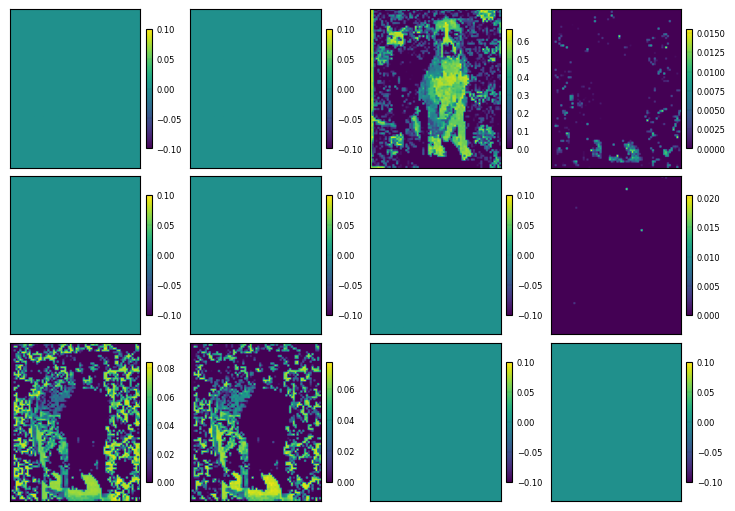

In [46]:
embeddings(encode, shape_=image.shape[0:2], figsize=(15, 5))


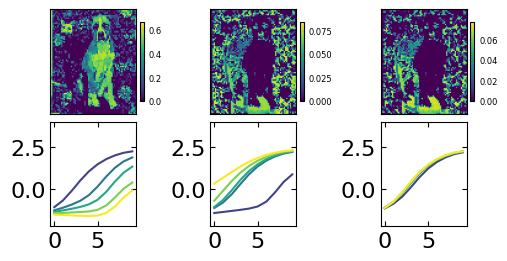

In [47]:
latent_generator(decoder, encode, image, 5, 10, device=device,
                 figsize=(5, 2.5), divider_=False, indx=[2, 8, 9])


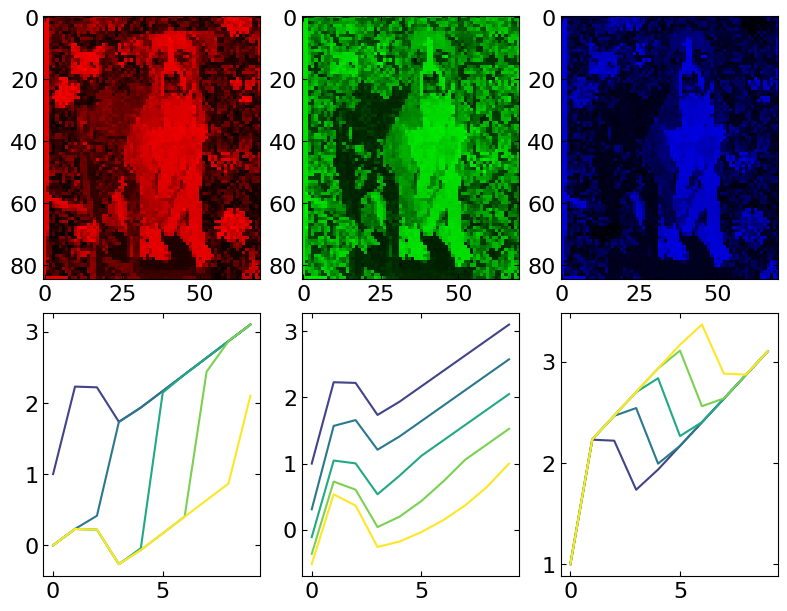

In [48]:
fig, ax = layout_fig(6, mod=3)

ax = ax.ravel()

cmap = plt.cm.viridis

for i, ax in enumerate(ax):
    if i < 3:
        img = np.zeros(image.shape)
        img[:, :, i] = image[:, :, i]
        ax.imshow(img)
    else:
        values = np.zeros((5, 3))
        values[:, i - 3] = np.linspace(0, 1, 5)
        y_data = generate_data(values, length=10)
        for j in range(y_data.shape[0]):
            color = cmap((j + 1) / y_data.shape[0])
            ax.plot(y_data[j], c=color)


In [49]:
from IPython.display import HTML

# Youtube
HTML(
    '<iframe width="560" height="315" src="https://www.youtube.com/embed/ElTwQClLsW0" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>'
)


c:\Users\jca92\.conda\envs\tutorials\lib\site-packages\IPython\core\display.py:419: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


## Beta Variational Autoencoder

- Constrict and sample the latent space from some prior distribution --> generally a gaussian distribution


### Normal Autoencoder

![](https://github.com/jagar2/m3_learning/blob/main/m3_learning/Tutorials/Unsupervised_Learning_with_AEs/figs/VAE1.png?raw=true)


### VAE

- Encoder identifies some distribution --> generates from that distribution
  ![](https://github.com/jagar2/m3_learning/blob/main/m3_learning/Tutorials/Unsupervised_Learning_with_AEs/figs/VAE2.png?raw=true)


![](https://github.com/jagar2/m3_learning/blob/main/m3_learning/Tutorials/Unsupervised_Learning_with_AEs/figs/VAE3.png?raw=true)


![](https://github.com/jagar2/m3_learning/blob/main/m3_learning/Tutorials/Unsupervised_Learning_with_AEs/figs/VAE4.png?raw=true)


### Builds the Model


In [50]:
latent_dim = 12


class Encoder(nn.Module):
    def __init__(self, latent_dim=12):
        self.latent_dim = latent_dim
        super(Encoder, self).__init__()
        self.lstm = nn.LSTM(1, 12, batch_first=True, bidirectional=True)
        self.embedding = nn.Linear(24, self.latent_dim)
        self.relu = nn.ReLU()
        # extracts the mean and standard deviation
        self.mn = nn.Linear(self.latent_dim, self.latent_dim)
        self.sd = nn.Linear(self.latent_dim, self.latent_dim)

    def forward(self, x):
        x, (_, __) = self.lstm(x)
        x = x[:, -1, :]
        x = self.embedding(x)
        x = self.relu(x)
        mn = self.mn(x)
        sd = self.sd(x)
        std = torch.exp(sd * 0.5).cuda()
        eps = torch.normal(0, 1, size=std.size()).cuda()
        out = eps.mul(std).add_(mn).cuda()

        return out, mn, sd


class Decoder(nn.Module):
    def __init__(self, latent_dim=12):
        self.latent_dim = latent_dim
        super(Decoder, self).__init__()
        self.lstm = nn.LSTM(
            latent_dim, 12, batch_first=True, bidirectional=True)
        self.tdd = nn.Conv1d(24, 1, 1)

    def forward(self, x):
        x = x[:, :, None]
        x = x.transpose(1, 2)
        x = x.repeat([1, 10, 1])
        x, (_, __) = self.lstm(x)
        x = x.transpose(1, 2)
        x = self.tdd(x)
        x = x.transpose(1, 2)
        return x


In [51]:
encoder = Encoder().to(device)
decoder = Decoder().to(device)
model = Autoencoder(encoder, decoder).to(device)

# optimizer
optimizer = optim.Adam(model.parameters(), lr=3e-4)


### Training


In [52]:
# training with beta regularization scheduling

def Train(
    model,
    encoder,
    decoder,
    train_iterator,
    optimizer,
    epochs,
    coef=0,
    coef_1=0,
    ln_parm=1,
    beta_step_size=0,
    epoch_per_beta=10,
    initial_epochs=10,
    device=device,
    save=False,
):

    N_EPOCHS = epochs
    best_train_loss = float("inf")

    for epoch in range(N_EPOCHS):

        if epoch < initial_epochs:
            # starts training with no VAE regularization
            beta = 0
        else:
            # adds VAE regularization
            beta = ((epoch - initial_epochs) //
                    epoch_per_beta + 1) * beta_step_size

        train_loss = loss_function(
            model,
            encoder,
            decoder,
            train_iterator,
            optimizer,
            coef,
            coef_1,
            ln_parm,
            beta=beta,
            mse=False,
        )

        train_loss /= len(train_iterator)
        print(f"Epoch {epoch}, Train Loss: {train_loss:.4f}")
        print(".............................")

        if save:
            if (
                (epoch - initial_epochs) // epoch_per_beta
                == (epoch - initial_epochs) / epoch_per_beta
            ) and (epoch >= initial_epochs):

                best_train_loss = float("inf")

            if best_train_loss > train_loss:
                best_train_loss = train_loss
                patience_counter = 1
                checkpoint = {
                    "net": model.state_dict(),
                    "optimizer": optimizer.state_dict(),
                    "epoch": epoch,
                    "encoder": encoder.state_dict(),
                    "decoder": decoder.state_dict(),
                }
                if epoch >= 0:
                    torch.save(
                        checkpoint, f"./test__Train_Loss:{train_loss:.4f}-{epoch}.pkl"
                    )


In [53]:
random_seed(seed=42)

Train(
    model,
    encoder,
    decoder,
    train_iterator,
    optimizer,
    500,
    beta_step_size=0.05,
    epoch_per_beta=100,
    initial_epochs=200,
    device=device,
)


Pytorch seed was set to 42
Numpy seed was set to 42
tensorflow seed was set to 42


100%|██████████| 19/19 [00:00<00:00, 31.29it/s]


Epoch 0, Train Loss: 1.8868
.............................


100%|██████████| 19/19 [00:00<00:00, 45.94it/s]


Epoch 1, Train Loss: 1.8601
.............................


100%|██████████| 19/19 [00:00<00:00, 52.50it/s]


Epoch 2, Train Loss: 1.8369
.............................


100%|██████████| 19/19 [00:00<00:00, 60.48it/s]


Epoch 3, Train Loss: 1.8194
.............................


100%|██████████| 19/19 [00:00<00:00, 65.37it/s]


Epoch 4, Train Loss: 1.7971
.............................


100%|██████████| 19/19 [00:00<00:00, 61.83it/s]


Epoch 5, Train Loss: 1.7614
.............................


100%|██████████| 19/19 [00:00<00:00, 65.87it/s]


Epoch 6, Train Loss: 1.7277
.............................


100%|██████████| 19/19 [00:00<00:00, 67.74it/s]


Epoch 7, Train Loss: 1.6581
.............................


100%|██████████| 19/19 [00:00<00:00, 70.83it/s]


Epoch 8, Train Loss: 1.5673
.............................


100%|██████████| 19/19 [00:00<00:00, 53.13it/s]


Epoch 9, Train Loss: 1.4347
.............................


100%|██████████| 19/19 [00:00<00:00, 58.56it/s]


Epoch 10, Train Loss: 1.2674
.............................


100%|██████████| 19/19 [00:00<00:00, 57.88it/s]


Epoch 11, Train Loss: 1.1148
.............................


100%|██████████| 19/19 [00:00<00:00, 55.54it/s]


Epoch 12, Train Loss: 0.9595
.............................


100%|██████████| 19/19 [00:00<00:00, 68.09it/s]


Epoch 13, Train Loss: 0.8134
.............................


100%|██████████| 19/19 [00:00<00:00, 68.29it/s]


Epoch 14, Train Loss: 0.6702
.............................


100%|██████████| 19/19 [00:00<00:00, 60.69it/s]


Epoch 15, Train Loss: 0.5385
.............................


100%|██████████| 19/19 [00:00<00:00, 57.44it/s]


Epoch 16, Train Loss: 0.4226
.............................


100%|██████████| 19/19 [00:00<00:00, 67.46it/s]


Epoch 17, Train Loss: 0.3489
.............................


100%|██████████| 19/19 [00:00<00:00, 64.31it/s]


Epoch 18, Train Loss: 0.3002
.............................


100%|██████████| 19/19 [00:00<00:00, 68.07it/s]


Epoch 19, Train Loss: 0.2694
.............................


100%|██████████| 19/19 [00:00<00:00, 69.04it/s]


Epoch 20, Train Loss: 0.2484
.............................


100%|██████████| 19/19 [00:00<00:00, 74.23it/s]


Epoch 21, Train Loss: 0.2366
.............................


100%|██████████| 19/19 [00:00<00:00, 61.48it/s]


Epoch 22, Train Loss: 0.2302
.............................


100%|██████████| 19/19 [00:00<00:00, 64.21it/s]


Epoch 23, Train Loss: 0.2195
.............................


100%|██████████| 19/19 [00:00<00:00, 70.89it/s]


Epoch 24, Train Loss: 0.2134
.............................


100%|██████████| 19/19 [00:00<00:00, 54.62it/s]


Epoch 25, Train Loss: 0.2084
.............................


100%|██████████| 19/19 [00:00<00:00, 49.50it/s]


Epoch 26, Train Loss: 0.2034
.............................


100%|██████████| 19/19 [00:00<00:00, 53.52it/s]


Epoch 27, Train Loss: 0.1974
.............................


100%|██████████| 19/19 [00:00<00:00, 52.10it/s]


Epoch 28, Train Loss: 0.1946
.............................


100%|██████████| 19/19 [00:00<00:00, 62.06it/s]


Epoch 29, Train Loss: 0.1912
.............................


100%|██████████| 19/19 [00:00<00:00, 69.91it/s]


Epoch 30, Train Loss: 0.1883
.............................


100%|██████████| 19/19 [00:00<00:00, 57.43it/s]


Epoch 31, Train Loss: 0.1846
.............................


100%|██████████| 19/19 [00:00<00:00, 53.85it/s]


Epoch 32, Train Loss: 0.1818
.............................


100%|██████████| 19/19 [00:00<00:00, 64.21it/s]


Epoch 33, Train Loss: 0.1795
.............................


100%|██████████| 19/19 [00:00<00:00, 69.21it/s]


Epoch 34, Train Loss: 0.1763
.............................


100%|██████████| 19/19 [00:00<00:00, 57.97it/s]


Epoch 35, Train Loss: 0.1745
.............................


100%|██████████| 19/19 [00:00<00:00, 72.41it/s]


Epoch 36, Train Loss: 0.1719
.............................


100%|██████████| 19/19 [00:00<00:00, 74.58it/s]


Epoch 37, Train Loss: 0.1700
.............................


100%|██████████| 19/19 [00:00<00:00, 64.27it/s]


Epoch 38, Train Loss: 0.1682
.............................


100%|██████████| 19/19 [00:00<00:00, 63.60it/s]


Epoch 39, Train Loss: 0.1660
.............................


100%|██████████| 19/19 [00:00<00:00, 66.45it/s]


Epoch 40, Train Loss: 0.1636
.............................


100%|██████████| 19/19 [00:00<00:00, 58.85it/s]


Epoch 41, Train Loss: 0.1618
.............................


100%|██████████| 19/19 [00:00<00:00, 52.61it/s]


Epoch 42, Train Loss: 0.1596
.............................


100%|██████████| 19/19 [00:00<00:00, 56.84it/s]


Epoch 43, Train Loss: 0.1581
.............................


100%|██████████| 19/19 [00:00<00:00, 62.44it/s]


Epoch 44, Train Loss: 0.1561
.............................


100%|██████████| 19/19 [00:00<00:00, 54.70it/s]


Epoch 45, Train Loss: 0.1540
.............................


100%|██████████| 19/19 [00:00<00:00, 62.16it/s]


Epoch 46, Train Loss: 0.1523
.............................


100%|██████████| 19/19 [00:00<00:00, 49.94it/s]


Epoch 47, Train Loss: 0.1502
.............................


100%|██████████| 19/19 [00:00<00:00, 50.68it/s]


Epoch 48, Train Loss: 0.1483
.............................


100%|██████████| 19/19 [00:00<00:00, 54.94it/s]


Epoch 49, Train Loss: 0.1460
.............................


100%|██████████| 19/19 [00:00<00:00, 58.29it/s]


Epoch 50, Train Loss: 0.1448
.............................


100%|██████████| 19/19 [00:00<00:00, 63.33it/s]


Epoch 51, Train Loss: 0.1428
.............................


100%|██████████| 19/19 [00:00<00:00, 65.18it/s]


Epoch 52, Train Loss: 0.1410
.............................


100%|██████████| 19/19 [00:00<00:00, 68.35it/s]


Epoch 53, Train Loss: 0.1391
.............................


100%|██████████| 19/19 [00:00<00:00, 67.52it/s]


Epoch 54, Train Loss: 0.1376
.............................


100%|██████████| 19/19 [00:00<00:00, 67.29it/s]


Epoch 55, Train Loss: 0.1361
.............................


100%|██████████| 19/19 [00:00<00:00, 62.44it/s]


Epoch 56, Train Loss: 0.1344
.............................


100%|██████████| 19/19 [00:00<00:00, 56.39it/s]


Epoch 57, Train Loss: 0.1331
.............................


100%|██████████| 19/19 [00:00<00:00, 53.52it/s]


Epoch 58, Train Loss: 0.1316
.............................


100%|██████████| 19/19 [00:00<00:00, 53.59it/s]


Epoch 59, Train Loss: 0.1302
.............................


100%|██████████| 19/19 [00:00<00:00, 43.89it/s]


Epoch 60, Train Loss: 0.1289
.............................


100%|██████████| 19/19 [00:00<00:00, 58.77it/s]


Epoch 61, Train Loss: 0.1276
.............................


100%|██████████| 19/19 [00:00<00:00, 53.10it/s]


Epoch 62, Train Loss: 0.1266
.............................


100%|██████████| 19/19 [00:00<00:00, 59.23it/s]


Epoch 63, Train Loss: 0.1255
.............................


100%|██████████| 19/19 [00:00<00:00, 63.30it/s]


Epoch 64, Train Loss: 0.1247
.............................


100%|██████████| 19/19 [00:00<00:00, 68.29it/s]


Epoch 65, Train Loss: 0.1233
.............................


100%|██████████| 19/19 [00:00<00:00, 65.14it/s]


Epoch 66, Train Loss: 0.1224
.............................


100%|██████████| 19/19 [00:00<00:00, 59.77it/s]


Epoch 67, Train Loss: 0.1214
.............................


100%|██████████| 19/19 [00:00<00:00, 70.23it/s]


Epoch 68, Train Loss: 0.1204
.............................


100%|██████████| 19/19 [00:00<00:00, 67.71it/s]


Epoch 69, Train Loss: 0.1196
.............................


100%|██████████| 19/19 [00:00<00:00, 69.82it/s]


Epoch 70, Train Loss: 0.1191
.............................


100%|██████████| 19/19 [00:00<00:00, 60.05it/s]


Epoch 71, Train Loss: 0.1180
.............................


100%|██████████| 19/19 [00:00<00:00, 55.15it/s]


Epoch 72, Train Loss: 0.1171
.............................


100%|██████████| 19/19 [00:00<00:00, 54.21it/s]


Epoch 73, Train Loss: 0.1162
.............................


100%|██████████| 19/19 [00:00<00:00, 56.71it/s]


Epoch 74, Train Loss: 0.1157
.............................


100%|██████████| 19/19 [00:00<00:00, 61.88it/s]


Epoch 75, Train Loss: 0.1146
.............................


100%|██████████| 19/19 [00:00<00:00, 64.91it/s]


Epoch 76, Train Loss: 0.1141
.............................


100%|██████████| 19/19 [00:00<00:00, 55.20it/s]


Epoch 77, Train Loss: 0.1135
.............................


100%|██████████| 19/19 [00:00<00:00, 50.60it/s]


Epoch 78, Train Loss: 0.1125
.............................


100%|██████████| 19/19 [00:00<00:00, 61.60it/s]


Epoch 79, Train Loss: 0.1119
.............................


100%|██████████| 19/19 [00:00<00:00, 62.07it/s]


Epoch 80, Train Loss: 0.1113
.............................


100%|██████████| 19/19 [00:00<00:00, 61.36it/s]


Epoch 81, Train Loss: 0.1106
.............................


100%|██████████| 19/19 [00:00<00:00, 72.48it/s]


Epoch 82, Train Loss: 0.1097
.............................


100%|██████████| 19/19 [00:00<00:00, 67.78it/s]


Epoch 83, Train Loss: 0.1091
.............................


100%|██████████| 19/19 [00:00<00:00, 60.23it/s]


Epoch 84, Train Loss: 0.1085
.............................


100%|██████████| 19/19 [00:00<00:00, 68.80it/s]


Epoch 85, Train Loss: 0.1080
.............................


100%|██████████| 19/19 [00:00<00:00, 69.43it/s]


Epoch 86, Train Loss: 0.1072
.............................


100%|██████████| 19/19 [00:00<00:00, 59.39it/s]


Epoch 87, Train Loss: 0.1068
.............................


100%|██████████| 19/19 [00:00<00:00, 51.80it/s]


Epoch 88, Train Loss: 0.1059
.............................


100%|██████████| 19/19 [00:00<00:00, 47.72it/s]


Epoch 89, Train Loss: 0.1054
.............................


100%|██████████| 19/19 [00:00<00:00, 50.85it/s]


Epoch 90, Train Loss: 0.1048
.............................


100%|██████████| 19/19 [00:00<00:00, 49.98it/s]


Epoch 91, Train Loss: 0.1043
.............................


100%|██████████| 19/19 [00:00<00:00, 41.24it/s]


Epoch 92, Train Loss: 0.1037
.............................


100%|██████████| 19/19 [00:00<00:00, 34.10it/s]


Epoch 93, Train Loss: 0.1032
.............................


100%|██████████| 19/19 [00:00<00:00, 44.19it/s]


Epoch 94, Train Loss: 0.1026
.............................


100%|██████████| 19/19 [00:00<00:00, 48.09it/s]


Epoch 95, Train Loss: 0.1022
.............................


100%|██████████| 19/19 [00:00<00:00, 53.20it/s]


Epoch 96, Train Loss: 0.1016
.............................


100%|██████████| 19/19 [00:00<00:00, 48.96it/s]


Epoch 97, Train Loss: 0.1011
.............................


100%|██████████| 19/19 [00:00<00:00, 56.38it/s]


Epoch 98, Train Loss: 0.1007
.............................


100%|██████████| 19/19 [00:00<00:00, 65.45it/s]


Epoch 99, Train Loss: 0.1001
.............................


100%|██████████| 19/19 [00:00<00:00, 52.81it/s]


Epoch 100, Train Loss: 0.0997
.............................


100%|██████████| 19/19 [00:00<00:00, 57.28it/s]


Epoch 101, Train Loss: 0.0993
.............................


100%|██████████| 19/19 [00:00<00:00, 59.90it/s]


Epoch 102, Train Loss: 0.0986
.............................


100%|██████████| 19/19 [00:00<00:00, 54.95it/s]


Epoch 103, Train Loss: 0.0983
.............................


100%|██████████| 19/19 [00:00<00:00, 60.82it/s]


Epoch 104, Train Loss: 0.0976
.............................


100%|██████████| 19/19 [00:00<00:00, 59.01it/s]


Epoch 105, Train Loss: 0.0971
.............................


100%|██████████| 19/19 [00:00<00:00, 52.38it/s]


Epoch 106, Train Loss: 0.0966
.............................


100%|██████████| 19/19 [00:00<00:00, 56.59it/s]


Epoch 107, Train Loss: 0.0960
.............................


100%|██████████| 19/19 [00:00<00:00, 68.35it/s]


Epoch 108, Train Loss: 0.0958
.............................


100%|██████████| 19/19 [00:00<00:00, 57.62it/s]


Epoch 109, Train Loss: 0.0949
.............................


100%|██████████| 19/19 [00:00<00:00, 63.67it/s]


Epoch 110, Train Loss: 0.0945
.............................


100%|██████████| 19/19 [00:00<00:00, 74.32it/s]


Epoch 111, Train Loss: 0.0937
.............................


100%|██████████| 19/19 [00:00<00:00, 72.74it/s]


Epoch 112, Train Loss: 0.0931
.............................


100%|██████████| 19/19 [00:00<00:00, 64.01it/s]


Epoch 113, Train Loss: 0.0924
.............................


100%|██████████| 19/19 [00:00<00:00, 67.28it/s]


Epoch 114, Train Loss: 0.0917
.............................


100%|██████████| 19/19 [00:00<00:00, 65.11it/s]


Epoch 115, Train Loss: 0.0908
.............................


100%|██████████| 19/19 [00:00<00:00, 43.54it/s]


Epoch 116, Train Loss: 0.0901
.............................


100%|██████████| 19/19 [00:00<00:00, 51.82it/s]


Epoch 117, Train Loss: 0.0892
.............................


100%|██████████| 19/19 [00:00<00:00, 57.07it/s]


Epoch 118, Train Loss: 0.0883
.............................


100%|██████████| 19/19 [00:00<00:00, 59.78it/s]


Epoch 119, Train Loss: 0.0872
.............................


100%|██████████| 19/19 [00:00<00:00, 65.29it/s]


Epoch 120, Train Loss: 0.0862
.............................


100%|██████████| 19/19 [00:00<00:00, 63.74it/s]


Epoch 121, Train Loss: 0.0849
.............................


100%|██████████| 19/19 [00:00<00:00, 56.78it/s]


Epoch 122, Train Loss: 0.0836
.............................


100%|██████████| 19/19 [00:00<00:00, 49.82it/s]


Epoch 123, Train Loss: 0.0821
.............................


100%|██████████| 19/19 [00:00<00:00, 53.07it/s]


Epoch 124, Train Loss: 0.0804
.............................


100%|██████████| 19/19 [00:00<00:00, 54.54it/s]


Epoch 125, Train Loss: 0.0786
.............................


100%|██████████| 19/19 [00:00<00:00, 53.11it/s]


Epoch 126, Train Loss: 0.0768
.............................


100%|██████████| 19/19 [00:00<00:00, 65.45it/s]


Epoch 127, Train Loss: 0.0744
.............................


100%|██████████| 19/19 [00:00<00:00, 64.97it/s]


Epoch 128, Train Loss: 0.0723
.............................


100%|██████████| 19/19 [00:00<00:00, 59.16it/s]


Epoch 129, Train Loss: 0.0704
.............................


100%|██████████| 19/19 [00:00<00:00, 53.39it/s]


Epoch 130, Train Loss: 0.0687
.............................


100%|██████████| 19/19 [00:00<00:00, 50.31it/s]


Epoch 131, Train Loss: 0.0670
.............................


100%|██████████| 19/19 [00:00<00:00, 54.81it/s]


Epoch 132, Train Loss: 0.0653
.............................


100%|██████████| 19/19 [00:00<00:00, 62.66it/s]


Epoch 133, Train Loss: 0.0638
.............................


100%|██████████| 19/19 [00:00<00:00, 63.49it/s]


Epoch 134, Train Loss: 0.0623
.............................


100%|██████████| 19/19 [00:00<00:00, 63.88it/s]


Epoch 135, Train Loss: 0.0611
.............................


100%|██████████| 19/19 [00:00<00:00, 65.65it/s]


Epoch 136, Train Loss: 0.0600
.............................


100%|██████████| 19/19 [00:00<00:00, 50.56it/s]


Epoch 137, Train Loss: 0.0588
.............................


100%|██████████| 19/19 [00:00<00:00, 59.90it/s]


Epoch 138, Train Loss: 0.0578
.............................


100%|██████████| 19/19 [00:00<00:00, 66.95it/s]


Epoch 139, Train Loss: 0.0569
.............................


100%|██████████| 19/19 [00:00<00:00, 63.18it/s]


Epoch 140, Train Loss: 0.0560
.............................


100%|██████████| 19/19 [00:00<00:00, 71.26it/s]


Epoch 141, Train Loss: 0.0549
.............................


100%|██████████| 19/19 [00:00<00:00, 68.35it/s]


Epoch 142, Train Loss: 0.0541
.............................


100%|██████████| 19/19 [00:00<00:00, 73.51it/s]


Epoch 143, Train Loss: 0.0533
.............................


100%|██████████| 19/19 [00:00<00:00, 58.51it/s]


Epoch 144, Train Loss: 0.0526
.............................


100%|██████████| 19/19 [00:00<00:00, 52.28it/s]


Epoch 145, Train Loss: 0.0518
.............................


100%|██████████| 19/19 [00:00<00:00, 49.43it/s]


Epoch 146, Train Loss: 0.0512
.............................


100%|██████████| 19/19 [00:00<00:00, 48.33it/s]


Epoch 147, Train Loss: 0.0504
.............................


100%|██████████| 19/19 [00:00<00:00, 47.74it/s]


Epoch 148, Train Loss: 0.0497
.............................


100%|██████████| 19/19 [00:00<00:00, 51.53it/s]


Epoch 149, Train Loss: 0.0489
.............................


100%|██████████| 19/19 [00:00<00:00, 55.37it/s]


Epoch 150, Train Loss: 0.0482
.............................


100%|██████████| 19/19 [00:00<00:00, 60.36it/s]


Epoch 151, Train Loss: 0.0477
.............................


100%|██████████| 19/19 [00:00<00:00, 51.14it/s]


Epoch 152, Train Loss: 0.0471
.............................


100%|██████████| 19/19 [00:00<00:00, 62.63it/s]


Epoch 153, Train Loss: 0.0466
.............................


100%|██████████| 19/19 [00:00<00:00, 62.18it/s]


Epoch 154, Train Loss: 0.0461
.............................


100%|██████████| 19/19 [00:00<00:00, 57.39it/s]


Epoch 155, Train Loss: 0.0454
.............................


100%|██████████| 19/19 [00:00<00:00, 55.84it/s]


Epoch 156, Train Loss: 0.0450
.............................


100%|██████████| 19/19 [00:00<00:00, 60.06it/s]


Epoch 157, Train Loss: 0.0443
.............................


100%|██████████| 19/19 [00:00<00:00, 61.53it/s]


Epoch 158, Train Loss: 0.0438
.............................


100%|██████████| 19/19 [00:00<00:00, 61.23it/s]


Epoch 159, Train Loss: 0.0433
.............................


100%|██████████| 19/19 [00:00<00:00, 55.94it/s]


Epoch 160, Train Loss: 0.0428
.............................


100%|██████████| 19/19 [00:00<00:00, 48.47it/s]


Epoch 161, Train Loss: 0.0423
.............................


100%|██████████| 19/19 [00:00<00:00, 55.02it/s]


Epoch 162, Train Loss: 0.0419
.............................


100%|██████████| 19/19 [00:00<00:00, 51.77it/s]


Epoch 163, Train Loss: 0.0412
.............................


100%|██████████| 19/19 [00:00<00:00, 62.54it/s]


Epoch 164, Train Loss: 0.0408
.............................


100%|██████████| 19/19 [00:00<00:00, 58.46it/s]


Epoch 165, Train Loss: 0.0404
.............................


100%|██████████| 19/19 [00:00<00:00, 48.12it/s]


Epoch 166, Train Loss: 0.0400
.............................


100%|██████████| 19/19 [00:00<00:00, 48.27it/s]


Epoch 167, Train Loss: 0.0396
.............................


100%|██████████| 19/19 [00:00<00:00, 64.93it/s]


Epoch 168, Train Loss: 0.0392
.............................


100%|██████████| 19/19 [00:00<00:00, 51.44it/s]


Epoch 169, Train Loss: 0.0385
.............................


100%|██████████| 19/19 [00:00<00:00, 64.90it/s]


Epoch 170, Train Loss: 0.0380
.............................


100%|██████████| 19/19 [00:00<00:00, 75.07it/s]


Epoch 171, Train Loss: 0.0377
.............................


100%|██████████| 19/19 [00:00<00:00, 63.01it/s]


Epoch 172, Train Loss: 0.0371
.............................


100%|██████████| 19/19 [00:00<00:00, 63.77it/s]


Epoch 173, Train Loss: 0.0369
.............................


100%|██████████| 19/19 [00:00<00:00, 63.85it/s]


Epoch 174, Train Loss: 0.0365
.............................


100%|██████████| 19/19 [00:00<00:00, 57.01it/s]


Epoch 175, Train Loss: 0.0360
.............................


100%|██████████| 19/19 [00:00<00:00, 49.97it/s]


Epoch 176, Train Loss: 0.0356
.............................


100%|██████████| 19/19 [00:00<00:00, 58.18it/s]


Epoch 177, Train Loss: 0.0351
.............................


100%|██████████| 19/19 [00:00<00:00, 57.14it/s]


Epoch 178, Train Loss: 0.0346
.............................


100%|██████████| 19/19 [00:00<00:00, 56.84it/s]


Epoch 179, Train Loss: 0.0343
.............................


100%|██████████| 19/19 [00:00<00:00, 60.59it/s]


Epoch 180, Train Loss: 0.0338
.............................


100%|██████████| 19/19 [00:00<00:00, 54.88it/s]


Epoch 181, Train Loss: 0.0335
.............................


100%|██████████| 19/19 [00:00<00:00, 52.30it/s]


Epoch 182, Train Loss: 0.0331
.............................


100%|██████████| 19/19 [00:00<00:00, 61.67it/s]


Epoch 183, Train Loss: 0.0326
.............................


100%|██████████| 19/19 [00:00<00:00, 58.65it/s]


Epoch 184, Train Loss: 0.0323
.............................


100%|██████████| 19/19 [00:00<00:00, 56.90it/s]


Epoch 185, Train Loss: 0.0317
.............................


100%|██████████| 19/19 [00:00<00:00, 66.97it/s]


Epoch 186, Train Loss: 0.0313
.............................


100%|██████████| 19/19 [00:00<00:00, 55.62it/s]


Epoch 187, Train Loss: 0.0310
.............................


100%|██████████| 19/19 [00:00<00:00, 48.92it/s]


Epoch 188, Train Loss: 0.0304
.............................


100%|██████████| 19/19 [00:00<00:00, 57.06it/s]


Epoch 189, Train Loss: 0.0299
.............................


100%|██████████| 19/19 [00:00<00:00, 41.11it/s]


Epoch 190, Train Loss: 0.0294
.............................


100%|██████████| 19/19 [00:00<00:00, 46.84it/s]


Epoch 191, Train Loss: 0.0288
.............................


100%|██████████| 19/19 [00:00<00:00, 58.48it/s]


Epoch 192, Train Loss: 0.0283
.............................


100%|██████████| 19/19 [00:00<00:00, 56.06it/s]


Epoch 193, Train Loss: 0.0277
.............................


100%|██████████| 19/19 [00:00<00:00, 60.52it/s]


Epoch 194, Train Loss: 0.0272
.............................


100%|██████████| 19/19 [00:00<00:00, 62.50it/s]


Epoch 195, Train Loss: 0.0269
.............................


100%|██████████| 19/19 [00:00<00:00, 54.68it/s]


Epoch 196, Train Loss: 0.0263
.............................


100%|██████████| 19/19 [00:00<00:00, 63.17it/s]


Epoch 197, Train Loss: 0.0259
.............................


100%|██████████| 19/19 [00:00<00:00, 68.46it/s]


Epoch 198, Train Loss: 0.0255
.............................


100%|██████████| 19/19 [00:00<00:00, 69.32it/s]


Epoch 199, Train Loss: 0.0252
.............................


100%|██████████| 19/19 [00:00<00:00, 66.79it/s]


Epoch 200, Train Loss: 2.6322
.............................


100%|██████████| 19/19 [00:00<00:00, 65.65it/s]


Epoch 201, Train Loss: 1.1233
.............................


100%|██████████| 19/19 [00:00<00:00, 68.45it/s]


Epoch 202, Train Loss: 0.7742
.............................


100%|██████████| 19/19 [00:00<00:00, 68.80it/s]


Epoch 203, Train Loss: 0.6060
.............................


100%|██████████| 19/19 [00:00<00:00, 70.19it/s]


Epoch 204, Train Loss: 0.5094
.............................


100%|██████████| 19/19 [00:00<00:00, 65.19it/s]


Epoch 205, Train Loss: 0.4462
.............................


100%|██████████| 19/19 [00:00<00:00, 58.76it/s]


Epoch 206, Train Loss: 0.4063
.............................


100%|██████████| 19/19 [00:00<00:00, 58.55it/s]


Epoch 207, Train Loss: 0.3747
.............................


100%|██████████| 19/19 [00:00<00:00, 62.69it/s]


Epoch 208, Train Loss: 0.3496
.............................


100%|██████████| 19/19 [00:00<00:00, 63.08it/s]


Epoch 209, Train Loss: 0.3333
.............................


100%|██████████| 19/19 [00:00<00:00, 64.68it/s]


Epoch 210, Train Loss: 0.3203
.............................


100%|██████████| 19/19 [00:00<00:00, 64.97it/s]


Epoch 211, Train Loss: 0.3077
.............................


100%|██████████| 19/19 [00:00<00:00, 52.70it/s]


Epoch 212, Train Loss: 0.3000
.............................


100%|██████████| 19/19 [00:00<00:00, 61.99it/s]


Epoch 213, Train Loss: 0.2910
.............................


100%|██████████| 19/19 [00:00<00:00, 66.89it/s]


Epoch 214, Train Loss: 0.2819
.............................


100%|██████████| 19/19 [00:00<00:00, 72.40it/s]


Epoch 215, Train Loss: 0.2749
.............................


100%|██████████| 19/19 [00:00<00:00, 66.45it/s]


Epoch 216, Train Loss: 0.2684
.............................


100%|██████████| 19/19 [00:00<00:00, 62.84it/s]


Epoch 217, Train Loss: 0.2664
.............................


100%|██████████| 19/19 [00:00<00:00, 66.01it/s]


Epoch 218, Train Loss: 0.2622
.............................


100%|██████████| 19/19 [00:00<00:00, 64.20it/s]


Epoch 219, Train Loss: 0.2600
.............................


100%|██████████| 19/19 [00:00<00:00, 59.28it/s]


Epoch 220, Train Loss: 0.2551
.............................


100%|██████████| 19/19 [00:00<00:00, 50.17it/s]


Epoch 221, Train Loss: 0.2516
.............................


100%|██████████| 19/19 [00:00<00:00, 36.67it/s]


Epoch 222, Train Loss: 0.2482
.............................


100%|██████████| 19/19 [00:00<00:00, 50.93it/s]


Epoch 223, Train Loss: 0.2441
.............................


100%|██████████| 19/19 [00:00<00:00, 53.07it/s]


Epoch 224, Train Loss: 0.2412
.............................


100%|██████████| 19/19 [00:00<00:00, 62.62it/s]


Epoch 225, Train Loss: 0.2382
.............................


100%|██████████| 19/19 [00:00<00:00, 69.88it/s]


Epoch 226, Train Loss: 0.2361
.............................


100%|██████████| 19/19 [00:00<00:00, 59.14it/s]


Epoch 227, Train Loss: 0.2343
.............................


100%|██████████| 19/19 [00:00<00:00, 60.03it/s]


Epoch 228, Train Loss: 0.2323
.............................


100%|██████████| 19/19 [00:00<00:00, 65.80it/s]


Epoch 229, Train Loss: 0.2304
.............................


100%|██████████| 19/19 [00:00<00:00, 71.71it/s]


Epoch 230, Train Loss: 0.2305
.............................


100%|██████████| 19/19 [00:00<00:00, 60.01it/s]


Epoch 231, Train Loss: 0.2264
.............................


100%|██████████| 19/19 [00:00<00:00, 66.94it/s]


Epoch 232, Train Loss: 0.2256
.............................


100%|██████████| 19/19 [00:00<00:00, 69.12it/s]


Epoch 233, Train Loss: 0.2229
.............................


100%|██████████| 19/19 [00:00<00:00, 69.52it/s]


Epoch 234, Train Loss: 0.2220
.............................


100%|██████████| 19/19 [00:00<00:00, 71.84it/s]


Epoch 235, Train Loss: 0.2192
.............................


100%|██████████| 19/19 [00:00<00:00, 59.45it/s]


Epoch 236, Train Loss: 0.2173
.............................


100%|██████████| 19/19 [00:00<00:00, 54.02it/s]


Epoch 237, Train Loss: 0.2159
.............................


100%|██████████| 19/19 [00:00<00:00, 54.01it/s]


Epoch 238, Train Loss: 0.2162
.............................


100%|██████████| 19/19 [00:00<00:00, 64.16it/s]


Epoch 239, Train Loss: 0.2119
.............................


100%|██████████| 19/19 [00:00<00:00, 60.47it/s]


Epoch 240, Train Loss: 0.2105
.............................


100%|██████████| 19/19 [00:00<00:00, 61.78it/s]


Epoch 241, Train Loss: 0.2092
.............................


100%|██████████| 19/19 [00:00<00:00, 54.93it/s]


Epoch 242, Train Loss: 0.2083
.............................


100%|██████████| 19/19 [00:00<00:00, 52.38it/s]


Epoch 243, Train Loss: 0.2080
.............................


100%|██████████| 19/19 [00:00<00:00, 61.95it/s]


Epoch 244, Train Loss: 0.2048
.............................


100%|██████████| 19/19 [00:00<00:00, 68.81it/s]


Epoch 245, Train Loss: 0.2044
.............................


100%|██████████| 19/19 [00:00<00:00, 68.83it/s]


Epoch 246, Train Loss: 0.1998
.............................


100%|██████████| 19/19 [00:00<00:00, 67.55it/s]


Epoch 247, Train Loss: 0.1961
.............................


100%|██████████| 19/19 [00:00<00:00, 70.09it/s]


Epoch 248, Train Loss: 0.1948
.............................


100%|██████████| 19/19 [00:00<00:00, 78.44it/s]


Epoch 249, Train Loss: 0.1931
.............................


100%|██████████| 19/19 [00:00<00:00, 67.87it/s]


Epoch 250, Train Loss: 0.1918
.............................


100%|██████████| 19/19 [00:00<00:00, 71.92it/s]


Epoch 251, Train Loss: 0.1872
.............................


100%|██████████| 19/19 [00:00<00:00, 68.84it/s]


Epoch 252, Train Loss: 0.1866
.............................


100%|██████████| 19/19 [00:00<00:00, 62.67it/s]


Epoch 253, Train Loss: 0.1848
.............................


100%|██████████| 19/19 [00:00<00:00, 47.10it/s]


Epoch 254, Train Loss: 0.1814
.............................


100%|██████████| 19/19 [00:00<00:00, 41.29it/s]


Epoch 255, Train Loss: 0.1800
.............................


100%|██████████| 19/19 [00:00<00:00, 50.29it/s]


Epoch 256, Train Loss: 0.1773
.............................


100%|██████████| 19/19 [00:00<00:00, 53.22it/s]


Epoch 257, Train Loss: 0.1760
.............................


100%|██████████| 19/19 [00:00<00:00, 51.60it/s]


Epoch 258, Train Loss: 0.1761
.............................


100%|██████████| 19/19 [00:00<00:00, 47.55it/s]


Epoch 259, Train Loss: 0.1731
.............................


100%|██████████| 19/19 [00:00<00:00, 59.97it/s]


Epoch 260, Train Loss: 0.1726
.............................


100%|██████████| 19/19 [00:00<00:00, 64.71it/s]


Epoch 261, Train Loss: 0.1695
.............................


100%|██████████| 19/19 [00:00<00:00, 59.93it/s]


Epoch 262, Train Loss: 0.1688
.............................


100%|██████████| 19/19 [00:00<00:00, 62.35it/s]


Epoch 263, Train Loss: 0.1689
.............................


100%|██████████| 19/19 [00:00<00:00, 46.80it/s]


Epoch 264, Train Loss: 0.1662
.............................


100%|██████████| 19/19 [00:00<00:00, 40.05it/s]


Epoch 265, Train Loss: 0.1656
.............................


100%|██████████| 19/19 [00:00<00:00, 36.99it/s]


Epoch 266, Train Loss: 0.1650
.............................


100%|██████████| 19/19 [00:00<00:00, 47.70it/s]


Epoch 267, Train Loss: 0.1628
.............................


100%|██████████| 19/19 [00:00<00:00, 52.71it/s]


Epoch 268, Train Loss: 0.1596
.............................


100%|██████████| 19/19 [00:00<00:00, 58.32it/s]


Epoch 269, Train Loss: 0.1605
.............................


100%|██████████| 19/19 [00:00<00:00, 64.20it/s]


Epoch 270, Train Loss: 0.1604
.............................


100%|██████████| 19/19 [00:00<00:00, 70.15it/s]


Epoch 271, Train Loss: 0.1586
.............................


100%|██████████| 19/19 [00:00<00:00, 63.72it/s]


Epoch 272, Train Loss: 0.1576
.............................


100%|██████████| 19/19 [00:00<00:00, 62.79it/s]


Epoch 273, Train Loss: 0.1574
.............................


100%|██████████| 19/19 [00:00<00:00, 57.52it/s]


Epoch 274, Train Loss: 0.1551
.............................


100%|██████████| 19/19 [00:00<00:00, 60.70it/s]


Epoch 275, Train Loss: 0.1546
.............................


100%|██████████| 19/19 [00:00<00:00, 58.68it/s]


Epoch 276, Train Loss: 0.1519
.............................


100%|██████████| 19/19 [00:00<00:00, 56.85it/s]


Epoch 277, Train Loss: 0.1517
.............................


100%|██████████| 19/19 [00:00<00:00, 63.87it/s]


Epoch 278, Train Loss: 0.1516
.............................


100%|██████████| 19/19 [00:00<00:00, 67.06it/s]


Epoch 279, Train Loss: 0.1505
.............................


100%|██████████| 19/19 [00:00<00:00, 63.44it/s]


Epoch 280, Train Loss: 0.1487
.............................


100%|██████████| 19/19 [00:00<00:00, 60.66it/s]


Epoch 281, Train Loss: 0.1471
.............................


100%|██████████| 19/19 [00:00<00:00, 56.75it/s]


Epoch 282, Train Loss: 0.1471
.............................


100%|██████████| 19/19 [00:00<00:00, 49.48it/s]


Epoch 283, Train Loss: 0.1454
.............................


100%|██████████| 19/19 [00:00<00:00, 49.30it/s]


Epoch 284, Train Loss: 0.1456
.............................


100%|██████████| 19/19 [00:00<00:00, 49.79it/s]


Epoch 285, Train Loss: 0.1456
.............................


100%|██████████| 19/19 [00:00<00:00, 50.11it/s]


Epoch 286, Train Loss: 0.1437
.............................


100%|██████████| 19/19 [00:00<00:00, 45.84it/s]


Epoch 287, Train Loss: 0.1445
.............................


100%|██████████| 19/19 [00:00<00:00, 56.37it/s]


Epoch 288, Train Loss: 0.1416
.............................


100%|██████████| 19/19 [00:00<00:00, 58.92it/s]


Epoch 289, Train Loss: 0.1420
.............................


100%|██████████| 19/19 [00:00<00:00, 55.92it/s]


Epoch 290, Train Loss: 0.1412
.............................


100%|██████████| 19/19 [00:00<00:00, 53.70it/s]


Epoch 291, Train Loss: 0.1399
.............................


100%|██████████| 19/19 [00:00<00:00, 60.99it/s]


Epoch 292, Train Loss: 0.1397
.............................


100%|██████████| 19/19 [00:00<00:00, 60.23it/s]


Epoch 293, Train Loss: 0.1396
.............................


100%|██████████| 19/19 [00:00<00:00, 60.62it/s]


Epoch 294, Train Loss: 0.1387
.............................


100%|██████████| 19/19 [00:00<00:00, 58.27it/s]


Epoch 295, Train Loss: 0.1358
.............................


100%|██████████| 19/19 [00:00<00:00, 52.65it/s]


Epoch 296, Train Loss: 0.1365
.............................


100%|██████████| 19/19 [00:00<00:00, 53.47it/s]


Epoch 297, Train Loss: 0.1358
.............................


100%|██████████| 19/19 [00:00<00:00, 59.13it/s]


Epoch 298, Train Loss: 0.1359
.............................


100%|██████████| 19/19 [00:00<00:00, 62.07it/s]


Epoch 299, Train Loss: 0.1344
.............................


100%|██████████| 19/19 [00:00<00:00, 63.47it/s]


Epoch 300, Train Loss: 0.1889
.............................


100%|██████████| 19/19 [00:00<00:00, 57.84it/s]


Epoch 301, Train Loss: 0.1851
.............................


100%|██████████| 19/19 [00:00<00:00, 51.14it/s]


Epoch 302, Train Loss: 0.1802
.............................


100%|██████████| 19/19 [00:00<00:00, 63.23it/s]


Epoch 303, Train Loss: 0.1783
.............................


100%|██████████| 19/19 [00:00<00:00, 60.41it/s]


Epoch 304, Train Loss: 0.1761
.............................


100%|██████████| 19/19 [00:00<00:00, 70.60it/s]


Epoch 305, Train Loss: 0.1763
.............................


100%|██████████| 19/19 [00:00<00:00, 70.16it/s]


Epoch 306, Train Loss: 0.1758
.............................


100%|██████████| 19/19 [00:00<00:00, 71.67it/s]


Epoch 307, Train Loss: 0.1750
.............................


100%|██████████| 19/19 [00:00<00:00, 68.23it/s]


Epoch 308, Train Loss: 0.1740
.............................


100%|██████████| 19/19 [00:00<00:00, 63.26it/s]


Epoch 309, Train Loss: 0.1726
.............................


100%|██████████| 19/19 [00:00<00:00, 59.53it/s]


Epoch 310, Train Loss: 0.1718
.............................


100%|██████████| 19/19 [00:00<00:00, 43.06it/s]


Epoch 311, Train Loss: 0.1701
.............................


100%|██████████| 19/19 [00:00<00:00, 43.71it/s]


Epoch 312, Train Loss: 0.1695
.............................


100%|██████████| 19/19 [00:00<00:00, 37.25it/s]


Epoch 313, Train Loss: 0.1697
.............................


100%|██████████| 19/19 [00:00<00:00, 51.88it/s]


Epoch 314, Train Loss: 0.1684
.............................


100%|██████████| 19/19 [00:00<00:00, 56.62it/s]


Epoch 315, Train Loss: 0.1692
.............................


100%|██████████| 19/19 [00:00<00:00, 46.08it/s]


Epoch 316, Train Loss: 0.1662
.............................


100%|██████████| 19/19 [00:00<00:00, 33.36it/s]


Epoch 317, Train Loss: 0.1671
.............................


100%|██████████| 19/19 [00:00<00:00, 53.60it/s]


Epoch 318, Train Loss: 0.1658
.............................


100%|██████████| 19/19 [00:00<00:00, 58.98it/s]


Epoch 319, Train Loss: 0.1656
.............................


100%|██████████| 19/19 [00:00<00:00, 67.45it/s]


Epoch 320, Train Loss: 0.1645
.............................


100%|██████████| 19/19 [00:00<00:00, 65.08it/s]


Epoch 321, Train Loss: 0.1632
.............................


100%|██████████| 19/19 [00:00<00:00, 61.82it/s]


Epoch 322, Train Loss: 0.1640
.............................


100%|██████████| 19/19 [00:00<00:00, 54.47it/s]


Epoch 323, Train Loss: 0.1643
.............................


100%|██████████| 19/19 [00:00<00:00, 54.43it/s]


Epoch 324, Train Loss: 0.1619
.............................


100%|██████████| 19/19 [00:00<00:00, 53.65it/s]


Epoch 325, Train Loss: 0.1622
.............................


100%|██████████| 19/19 [00:00<00:00, 50.00it/s]


Epoch 326, Train Loss: 0.1604
.............................


100%|██████████| 19/19 [00:00<00:00, 57.40it/s]


Epoch 327, Train Loss: 0.1609
.............................


100%|██████████| 19/19 [00:00<00:00, 61.10it/s]


Epoch 328, Train Loss: 0.1578
.............................


100%|██████████| 19/19 [00:00<00:00, 61.46it/s]


Epoch 329, Train Loss: 0.1584
.............................


100%|██████████| 19/19 [00:00<00:00, 63.47it/s]


Epoch 330, Train Loss: 0.1570
.............................


100%|██████████| 19/19 [00:00<00:00, 58.20it/s]


Epoch 331, Train Loss: 0.1574
.............................


100%|██████████| 19/19 [00:00<00:00, 64.29it/s]


Epoch 332, Train Loss: 0.1589
.............................


100%|██████████| 19/19 [00:00<00:00, 68.32it/s]


Epoch 333, Train Loss: 0.1566
.............................


100%|██████████| 19/19 [00:00<00:00, 66.35it/s]


Epoch 334, Train Loss: 0.1547
.............................


100%|██████████| 19/19 [00:00<00:00, 56.59it/s]


Epoch 335, Train Loss: 0.1551
.............................


100%|██████████| 19/19 [00:00<00:00, 61.86it/s]


Epoch 336, Train Loss: 0.1538
.............................


100%|██████████| 19/19 [00:00<00:00, 57.55it/s]


Epoch 337, Train Loss: 0.1532
.............................


100%|██████████| 19/19 [00:00<00:00, 55.69it/s]


Epoch 338, Train Loss: 0.1512
.............................


100%|██████████| 19/19 [00:00<00:00, 58.40it/s]


Epoch 339, Train Loss: 0.1527
.............................


100%|██████████| 19/19 [00:00<00:00, 53.24it/s]


Epoch 340, Train Loss: 0.1517
.............................


100%|██████████| 19/19 [00:00<00:00, 49.38it/s]


Epoch 341, Train Loss: 0.1502
.............................


100%|██████████| 19/19 [00:00<00:00, 55.58it/s]


Epoch 342, Train Loss: 0.1514
.............................


100%|██████████| 19/19 [00:00<00:00, 56.07it/s]


Epoch 343, Train Loss: 0.1496
.............................


100%|██████████| 19/19 [00:00<00:00, 54.45it/s]


Epoch 344, Train Loss: 0.1487
.............................


100%|██████████| 19/19 [00:00<00:00, 49.56it/s]


Epoch 345, Train Loss: 0.1490
.............................


100%|██████████| 19/19 [00:00<00:00, 55.34it/s]


Epoch 346, Train Loss: 0.1486
.............................


100%|██████████| 19/19 [00:00<00:00, 55.83it/s]


Epoch 347, Train Loss: 0.1487
.............................


100%|██████████| 19/19 [00:00<00:00, 54.02it/s]


Epoch 348, Train Loss: 0.1464
.............................


100%|██████████| 19/19 [00:00<00:00, 51.96it/s]


Epoch 349, Train Loss: 0.1461
.............................


100%|██████████| 19/19 [00:00<00:00, 61.71it/s]


Epoch 350, Train Loss: 0.1442
.............................


100%|██████████| 19/19 [00:00<00:00, 63.85it/s]


Epoch 351, Train Loss: 0.1460
.............................


100%|██████████| 19/19 [00:00<00:00, 49.34it/s]


Epoch 352, Train Loss: 0.1443
.............................


100%|██████████| 19/19 [00:00<00:00, 52.86it/s]


Epoch 353, Train Loss: 0.1434
.............................


100%|██████████| 19/19 [00:00<00:00, 53.25it/s]


Epoch 354, Train Loss: 0.1424
.............................


100%|██████████| 19/19 [00:00<00:00, 52.22it/s]


Epoch 355, Train Loss: 0.1425
.............................


100%|██████████| 19/19 [00:00<00:00, 63.05it/s]


Epoch 356, Train Loss: 0.1416
.............................


100%|██████████| 19/19 [00:00<00:00, 69.29it/s]


Epoch 357, Train Loss: 0.1415
.............................


100%|██████████| 19/19 [00:00<00:00, 63.19it/s]


Epoch 358, Train Loss: 0.1415
.............................


100%|██████████| 19/19 [00:00<00:00, 54.51it/s]


Epoch 359, Train Loss: 0.1396
.............................


100%|██████████| 19/19 [00:00<00:00, 51.36it/s]


Epoch 360, Train Loss: 0.1393
.............................


100%|██████████| 19/19 [00:00<00:00, 56.40it/s]


Epoch 361, Train Loss: 0.1385
.............................


100%|██████████| 19/19 [00:00<00:00, 62.36it/s]


Epoch 362, Train Loss: 0.1380
.............................


100%|██████████| 19/19 [00:00<00:00, 61.47it/s]


Epoch 363, Train Loss: 0.1375
.............................


100%|██████████| 19/19 [00:00<00:00, 55.95it/s]


Epoch 364, Train Loss: 0.1375
.............................


100%|██████████| 19/19 [00:00<00:00, 60.14it/s]


Epoch 365, Train Loss: 0.1364
.............................


100%|██████████| 19/19 [00:00<00:00, 67.79it/s]


Epoch 366, Train Loss: 0.1376
.............................


100%|██████████| 19/19 [00:00<00:00, 68.93it/s]


Epoch 367, Train Loss: 0.1352
.............................


100%|██████████| 19/19 [00:00<00:00, 54.60it/s]


Epoch 368, Train Loss: 0.1359
.............................


100%|██████████| 19/19 [00:00<00:00, 39.50it/s]


Epoch 369, Train Loss: 0.1349
.............................


100%|██████████| 19/19 [00:00<00:00, 47.77it/s]


Epoch 370, Train Loss: 0.1338
.............................


100%|██████████| 19/19 [00:00<00:00, 57.15it/s]


Epoch 371, Train Loss: 0.1351
.............................


100%|██████████| 19/19 [00:00<00:00, 62.33it/s]


Epoch 372, Train Loss: 0.1314
.............................


100%|██████████| 19/19 [00:00<00:00, 60.80it/s]


Epoch 373, Train Loss: 0.1329
.............................


100%|██████████| 19/19 [00:00<00:00, 55.46it/s]


Epoch 374, Train Loss: 0.1301
.............................


100%|██████████| 19/19 [00:00<00:00, 60.94it/s]


Epoch 375, Train Loss: 0.1310
.............................


100%|██████████| 19/19 [00:00<00:00, 55.97it/s]


Epoch 376, Train Loss: 0.1290
.............................


100%|██████████| 19/19 [00:00<00:00, 52.06it/s]


Epoch 377, Train Loss: 0.1294
.............................


100%|██████████| 19/19 [00:00<00:00, 62.37it/s]


Epoch 378, Train Loss: 0.1295
.............................


100%|██████████| 19/19 [00:00<00:00, 54.73it/s]


Epoch 379, Train Loss: 0.1274
.............................


100%|██████████| 19/19 [00:00<00:00, 54.26it/s]


Epoch 380, Train Loss: 0.1273
.............................


100%|██████████| 19/19 [00:00<00:00, 55.46it/s]


Epoch 381, Train Loss: 0.1273
.............................


100%|██████████| 19/19 [00:00<00:00, 54.37it/s]


Epoch 382, Train Loss: 0.1276
.............................


100%|██████████| 19/19 [00:00<00:00, 50.83it/s]


Epoch 383, Train Loss: 0.1254
.............................


100%|██████████| 19/19 [00:00<00:00, 48.70it/s]


Epoch 384, Train Loss: 0.1260
.............................


100%|██████████| 19/19 [00:00<00:00, 47.04it/s]


Epoch 385, Train Loss: 0.1256
.............................


100%|██████████| 19/19 [00:00<00:00, 55.03it/s]


Epoch 386, Train Loss: 0.1243
.............................


100%|██████████| 19/19 [00:00<00:00, 57.95it/s]


Epoch 387, Train Loss: 0.1237
.............................


100%|██████████| 19/19 [00:00<00:00, 52.47it/s]


Epoch 388, Train Loss: 0.1233
.............................


100%|██████████| 19/19 [00:00<00:00, 60.64it/s]


Epoch 389, Train Loss: 0.1233
.............................


100%|██████████| 19/19 [00:00<00:00, 60.44it/s]


Epoch 390, Train Loss: 0.1211
.............................


100%|██████████| 19/19 [00:00<00:00, 61.07it/s]


Epoch 391, Train Loss: 0.1215
.............................


100%|██████████| 19/19 [00:00<00:00, 57.42it/s]


Epoch 392, Train Loss: 0.1208
.............................


100%|██████████| 19/19 [00:00<00:00, 48.14it/s]


Epoch 393, Train Loss: 0.1209
.............................


100%|██████████| 19/19 [00:00<00:00, 55.01it/s]


Epoch 394, Train Loss: 0.1203
.............................


100%|██████████| 19/19 [00:00<00:00, 61.40it/s]


Epoch 395, Train Loss: 0.1189
.............................


100%|██████████| 19/19 [00:00<00:00, 60.04it/s]


Epoch 396, Train Loss: 0.1182
.............................


100%|██████████| 19/19 [00:00<00:00, 54.98it/s]


Epoch 397, Train Loss: 0.1194
.............................


100%|██████████| 19/19 [00:00<00:00, 54.99it/s]


Epoch 398, Train Loss: 0.1184
.............................


100%|██████████| 19/19 [00:00<00:00, 59.83it/s]


Epoch 399, Train Loss: 0.1178
.............................


100%|██████████| 19/19 [00:00<00:00, 62.97it/s]


Epoch 400, Train Loss: 0.1453
.............................


100%|██████████| 19/19 [00:00<00:00, 64.14it/s]


Epoch 401, Train Loss: 0.1418
.............................


100%|██████████| 19/19 [00:00<00:00, 52.10it/s]


Epoch 402, Train Loss: 0.1407
.............................


100%|██████████| 19/19 [00:00<00:00, 56.92it/s]


Epoch 403, Train Loss: 0.1399
.............................


100%|██████████| 19/19 [00:00<00:00, 56.87it/s]


Epoch 404, Train Loss: 0.1398
.............................


100%|██████████| 19/19 [00:00<00:00, 64.25it/s]


Epoch 405, Train Loss: 0.1390
.............................


100%|██████████| 19/19 [00:00<00:00, 64.47it/s]


Epoch 406, Train Loss: 0.1379
.............................


100%|██████████| 19/19 [00:00<00:00, 66.94it/s]


Epoch 407, Train Loss: 0.1374
.............................


100%|██████████| 19/19 [00:00<00:00, 72.64it/s]


Epoch 408, Train Loss: 0.1377
.............................


100%|██████████| 19/19 [00:00<00:00, 66.67it/s]


Epoch 409, Train Loss: 0.1362
.............................


100%|██████████| 19/19 [00:00<00:00, 61.35it/s]


Epoch 410, Train Loss: 0.1358
.............................


100%|██████████| 19/19 [00:00<00:00, 51.56it/s]


Epoch 411, Train Loss: 0.1376
.............................


100%|██████████| 19/19 [00:00<00:00, 45.81it/s]


Epoch 412, Train Loss: 0.1349
.............................


100%|██████████| 19/19 [00:00<00:00, 48.91it/s]


Epoch 413, Train Loss: 0.1341
.............................


100%|██████████| 19/19 [00:00<00:00, 54.72it/s]


Epoch 414, Train Loss: 0.1340
.............................


100%|██████████| 19/19 [00:00<00:00, 57.36it/s]


Epoch 415, Train Loss: 0.1327
.............................


100%|██████████| 19/19 [00:00<00:00, 65.27it/s]


Epoch 416, Train Loss: 0.1327
.............................


100%|██████████| 19/19 [00:00<00:00, 64.49it/s]


Epoch 417, Train Loss: 0.1319
.............................


100%|██████████| 19/19 [00:00<00:00, 48.02it/s]


Epoch 418, Train Loss: 0.1308
.............................


100%|██████████| 19/19 [00:00<00:00, 52.47it/s]


Epoch 419, Train Loss: 0.1303
.............................


100%|██████████| 19/19 [00:00<00:00, 62.11it/s]


Epoch 420, Train Loss: 0.1304
.............................


100%|██████████| 19/19 [00:00<00:00, 60.45it/s]


Epoch 421, Train Loss: 0.1294
.............................


100%|██████████| 19/19 [00:00<00:00, 59.95it/s]


Epoch 422, Train Loss: 0.1295
.............................


100%|██████████| 19/19 [00:00<00:00, 61.32it/s]


Epoch 423, Train Loss: 0.1284
.............................


100%|██████████| 19/19 [00:00<00:00, 64.66it/s]


Epoch 424, Train Loss: 0.1274
.............................


100%|██████████| 19/19 [00:00<00:00, 66.97it/s]


Epoch 425, Train Loss: 0.1277
.............................


100%|██████████| 19/19 [00:00<00:00, 53.84it/s]


Epoch 426, Train Loss: 0.1295
.............................


100%|██████████| 19/19 [00:00<00:00, 52.48it/s]


Epoch 427, Train Loss: 0.1276
.............................


100%|██████████| 19/19 [00:00<00:00, 48.23it/s]


Epoch 428, Train Loss: 0.1283
.............................


100%|██████████| 19/19 [00:00<00:00, 55.09it/s]


Epoch 429, Train Loss: 0.1277
.............................


100%|██████████| 19/19 [00:00<00:00, 55.09it/s]


Epoch 430, Train Loss: 0.1253
.............................


100%|██████████| 19/19 [00:00<00:00, 52.74it/s]


Epoch 431, Train Loss: 0.1275
.............................


100%|██████████| 19/19 [00:00<00:00, 51.69it/s]


Epoch 432, Train Loss: 0.1258
.............................


100%|██████████| 19/19 [00:00<00:00, 48.73it/s]


Epoch 433, Train Loss: 0.1272
.............................


100%|██████████| 19/19 [00:00<00:00, 43.95it/s]


Epoch 434, Train Loss: 0.1242
.............................


100%|██████████| 19/19 [00:00<00:00, 51.84it/s]


Epoch 435, Train Loss: 0.1248
.............................


100%|██████████| 19/19 [00:00<00:00, 60.23it/s]


Epoch 436, Train Loss: 0.1238
.............................


100%|██████████| 19/19 [00:00<00:00, 57.63it/s]


Epoch 437, Train Loss: 0.1249
.............................


100%|██████████| 19/19 [00:00<00:00, 62.62it/s]


Epoch 438, Train Loss: 0.1244
.............................


100%|██████████| 19/19 [00:00<00:00, 64.08it/s]


Epoch 439, Train Loss: 0.1226
.............................


100%|██████████| 19/19 [00:00<00:00, 60.37it/s]


Epoch 440, Train Loss: 0.1243
.............................


100%|██████████| 19/19 [00:00<00:00, 51.40it/s]


Epoch 441, Train Loss: 0.1234
.............................


100%|██████████| 19/19 [00:00<00:00, 34.64it/s]


Epoch 442, Train Loss: 0.1216
.............................


100%|██████████| 19/19 [00:00<00:00, 50.50it/s]


Epoch 443, Train Loss: 0.1218
.............................


100%|██████████| 19/19 [00:00<00:00, 58.09it/s]


Epoch 444, Train Loss: 0.1216
.............................


100%|██████████| 19/19 [00:00<00:00, 59.28it/s]


Epoch 445, Train Loss: 0.1222
.............................


100%|██████████| 19/19 [00:00<00:00, 58.29it/s]


Epoch 446, Train Loss: 0.1210
.............................


100%|██████████| 19/19 [00:00<00:00, 59.88it/s]


Epoch 447, Train Loss: 0.1207
.............................


100%|██████████| 19/19 [00:00<00:00, 65.91it/s]


Epoch 448, Train Loss: 0.1216
.............................


100%|██████████| 19/19 [00:00<00:00, 59.97it/s]


Epoch 449, Train Loss: 0.1206
.............................


100%|██████████| 19/19 [00:00<00:00, 51.98it/s]


Epoch 450, Train Loss: 0.1197
.............................


100%|██████████| 19/19 [00:00<00:00, 54.26it/s]


Epoch 451, Train Loss: 0.1203
.............................


100%|██████████| 19/19 [00:00<00:00, 51.31it/s]


Epoch 452, Train Loss: 0.1195
.............................


100%|██████████| 19/19 [00:00<00:00, 52.78it/s]


Epoch 453, Train Loss: 0.1200
.............................


100%|██████████| 19/19 [00:00<00:00, 44.17it/s]


Epoch 454, Train Loss: 0.1187
.............................


100%|██████████| 19/19 [00:00<00:00, 51.23it/s]


Epoch 455, Train Loss: 0.1174
.............................


100%|██████████| 19/19 [00:00<00:00, 52.75it/s]


Epoch 456, Train Loss: 0.1200
.............................


100%|██████████| 19/19 [00:00<00:00, 57.90it/s]


Epoch 457, Train Loss: 0.1187
.............................


100%|██████████| 19/19 [00:00<00:00, 54.71it/s]


Epoch 458, Train Loss: 0.1188
.............................


100%|██████████| 19/19 [00:00<00:00, 64.44it/s]


Epoch 459, Train Loss: 0.1187
.............................


100%|██████████| 19/19 [00:00<00:00, 58.62it/s]


Epoch 460, Train Loss: 0.1184
.............................


100%|██████████| 19/19 [00:00<00:00, 59.97it/s]


Epoch 461, Train Loss: 0.1176
.............................


100%|██████████| 19/19 [00:00<00:00, 55.86it/s]


Epoch 462, Train Loss: 0.1177
.............................


100%|██████████| 19/19 [00:00<00:00, 61.85it/s]


Epoch 463, Train Loss: 0.1186
.............................


100%|██████████| 19/19 [00:00<00:00, 61.34it/s]


Epoch 464, Train Loss: 0.1171
.............................


100%|██████████| 19/19 [00:00<00:00, 74.21it/s]


Epoch 465, Train Loss: 0.1169
.............................


100%|██████████| 19/19 [00:00<00:00, 69.74it/s]


Epoch 466, Train Loss: 0.1157
.............................


100%|██████████| 19/19 [00:00<00:00, 64.86it/s]


Epoch 467, Train Loss: 0.1169
.............................


100%|██████████| 19/19 [00:00<00:00, 60.21it/s]


Epoch 468, Train Loss: 0.1163
.............................


100%|██████████| 19/19 [00:00<00:00, 60.88it/s]


Epoch 469, Train Loss: 0.1165
.............................


100%|██████████| 19/19 [00:00<00:00, 53.37it/s]


Epoch 470, Train Loss: 0.1167
.............................


100%|██████████| 19/19 [00:00<00:00, 51.88it/s]


Epoch 471, Train Loss: 0.1170
.............................


100%|██████████| 19/19 [00:00<00:00, 59.83it/s]


Epoch 472, Train Loss: 0.1149
.............................


100%|██████████| 19/19 [00:00<00:00, 54.33it/s]


Epoch 473, Train Loss: 0.1152
.............................


100%|██████████| 19/19 [00:00<00:00, 51.34it/s]


Epoch 474, Train Loss: 0.1169
.............................


100%|██████████| 19/19 [00:00<00:00, 53.81it/s]


Epoch 475, Train Loss: 0.1158
.............................


100%|██████████| 19/19 [00:00<00:00, 44.35it/s]


Epoch 476, Train Loss: 0.1148
.............................


100%|██████████| 19/19 [00:00<00:00, 64.10it/s]


Epoch 477, Train Loss: 0.1152
.............................


100%|██████████| 19/19 [00:00<00:00, 66.29it/s]


Epoch 478, Train Loss: 0.1152
.............................


100%|██████████| 19/19 [00:00<00:00, 68.45it/s]


Epoch 479, Train Loss: 0.1147
.............................


100%|██████████| 19/19 [00:00<00:00, 62.27it/s]


Epoch 480, Train Loss: 0.1143
.............................


100%|██████████| 19/19 [00:00<00:00, 65.12it/s]


Epoch 481, Train Loss: 0.1151
.............................


100%|██████████| 19/19 [00:00<00:00, 64.58it/s]


Epoch 482, Train Loss: 0.1133
.............................


100%|██████████| 19/19 [00:00<00:00, 64.36it/s]


Epoch 483, Train Loss: 0.1152
.............................


100%|██████████| 19/19 [00:00<00:00, 51.81it/s]


Epoch 484, Train Loss: 0.1144
.............................


100%|██████████| 19/19 [00:00<00:00, 55.34it/s]


Epoch 485, Train Loss: 0.1143
.............................


100%|██████████| 19/19 [00:00<00:00, 49.99it/s]


Epoch 486, Train Loss: 0.1132
.............................


100%|██████████| 19/19 [00:00<00:00, 51.60it/s]


Epoch 487, Train Loss: 0.1149
.............................


100%|██████████| 19/19 [00:00<00:00, 51.79it/s]


Epoch 488, Train Loss: 0.1129
.............................


100%|██████████| 19/19 [00:00<00:00, 58.25it/s]


Epoch 489, Train Loss: 0.1128
.............................


100%|██████████| 19/19 [00:00<00:00, 51.74it/s]


Epoch 490, Train Loss: 0.1124
.............................


100%|██████████| 19/19 [00:00<00:00, 47.90it/s]


Epoch 491, Train Loss: 0.1123
.............................


100%|██████████| 19/19 [00:00<00:00, 56.86it/s]


Epoch 492, Train Loss: 0.1129
.............................


100%|██████████| 19/19 [00:00<00:00, 58.09it/s]


Epoch 493, Train Loss: 0.1128
.............................


100%|██████████| 19/19 [00:00<00:00, 55.71it/s]


Epoch 494, Train Loss: 0.1122
.............................


100%|██████████| 19/19 [00:00<00:00, 53.09it/s]


Epoch 495, Train Loss: 0.1129
.............................


100%|██████████| 19/19 [00:00<00:00, 59.68it/s]


Epoch 496, Train Loss: 0.1124
.............................


100%|██████████| 19/19 [00:00<00:00, 61.92it/s]


Epoch 497, Train Loss: 0.1126
.............................


100%|██████████| 19/19 [00:00<00:00, 50.18it/s]


Epoch 498, Train Loss: 0.1108
.............................


100%|██████████| 19/19 [00:00<00:00, 51.35it/s]

Epoch 499, Train Loss: 0.1119
.............................


### Validation


In [54]:
encoded_spectra, mn, sd = encoder(
    torch.tensor(np.atleast_3d(dog_data), dtype=torch.float32).to(device)
)
decoded_spectra = decoder(encoded_spectra)


In [55]:
encoded_spectra = encoded_spectra.to("cpu")
encoded_spectra = encoded_spectra.detach().numpy()
decoded_spectra = decoded_spectra.to("cpu")
decoded_spectra = decoded_spectra.detach().numpy()


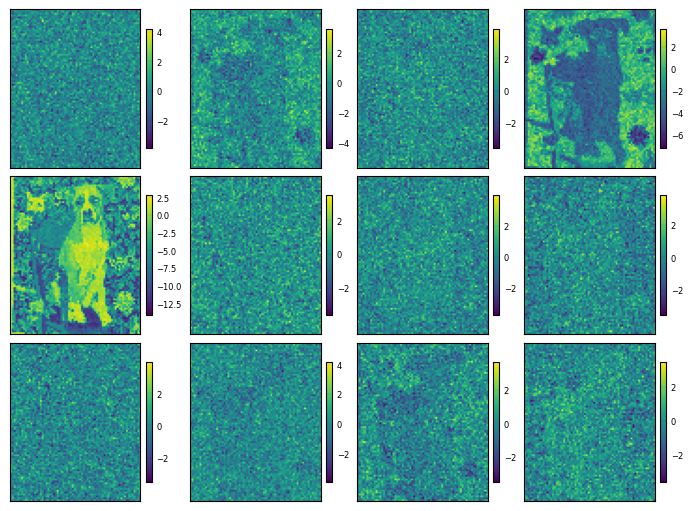

In [56]:
embeddings(encoded_spectra, shape_=image.shape[0:2], figsize=(15, 5))


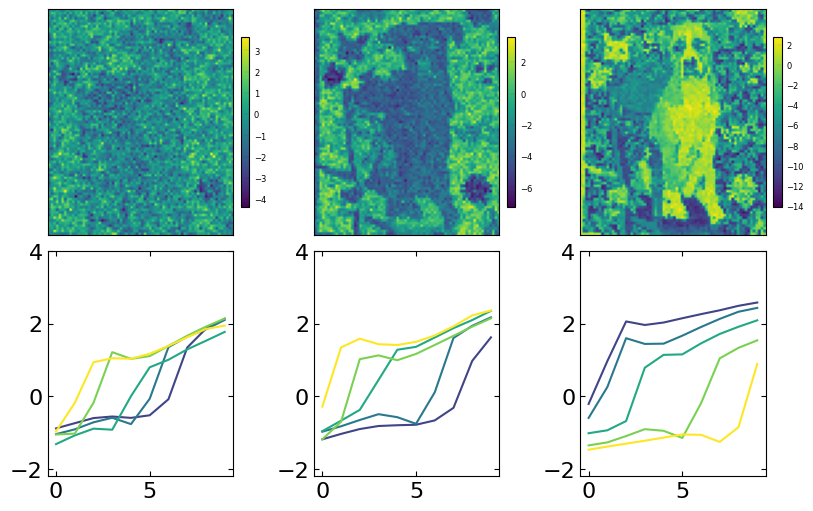

In [57]:
latent_generator(decoder, encoded_spectra, image, 5, 10,
                 device=device, figsize=(15, 5), divider_=False, indx=[1, 3, 4])


- disentanglement with $\beta$ VAE requires careful control of optimiztion.
